# 零、导入与忽略警告

In [153]:
# =================== 基础工具 ===================
import os
import math
from math import log
import numpy as np
import pandas as pd
from tabulate import tabulate
import textwrap

# =================== 可视化 ===================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import missingno as msno

# =================== 科学计算 (scipy) ===================
from scipy import stats
from scipy.stats import (
    chi2_contingency, f_oneway,
    pointbiserialr, pearsonr,
    mannwhitneyu, brunnermunzel,
    zscore, iqr, skew, kurtosis,
    shapiro
)
from scipy.stats import chi2 as chi2_dist  # chi2 分布对象
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform

# =================== 机器学习 (scikit-learn) ===================
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, roc_auc_score
)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.feature_selection import (
    mutual_info_regression, mutual_info_classif,
    f_classif, chi2 as chi2_fs
)
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ========== 缺失值处理 ==========
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer

# =================== 统计建模 (statsmodels) ===================
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.imputation import mice
from statsmodels.stats.outliers_influence import variance_inflation_factor

# =================== 其他统计工具 ===================
import pingouin as pg


In [154]:
import warnings
warnings.filterwarnings('ignore')

# 一、问题定义

## 1.1 Business/Research Need and Research Question
Diabetes is a global chronic disease, and its early identification is critical to reducing complications and alleviating the burden on healthcare systems. The central research need is:

- **To build a predictive model that determines whether an individual has diabetes based on demographic, lifestyle, psychosocial, and medical risk factors.**

The research question can be articulated as:  
*Given a set of features including demographic variables (e.g., age, sex, education, income), lifestyle behaviors (e.g., smoking, alcohol use, physical activity, diet), psychosocial health indicators (e.g., mental and physical unhealthy days), medical history (e.g., stroke, heart disease, hypertension, cholesterol), and healthcare access, can we accurately predict whether an individual is diagnosed with diabetes?*

## 1.2 Task Type
- **Type of task**: Classification (supervised learning)  
- **Target variable**: `Diabetes` 
- The goal is to classify individuals into diabetic or non-diabetic categories based on the input features.

## 1.3 Stakeholders
1. **Public Health Agencies**: Use the model to identify high-risk groups, guide resource allocation, and design preventive strategies.  
2. **Clinicians**: Support risk assessment and provide early intervention for undiagnosed but high-risk individuals.  
3. **Healthcare Insurers**: Optimize resource distribution and cost management through risk stratification.  
4. **Patients and the General Public**: Improve awareness of risk factors, encourage healthier lifestyle changes, and promote self-management.  
5. **Researchers**: Explore the multidimensional determinants of diabetes and contribute to precision medicine studies.

## 1.4 Value and Benefits
- **Early Detection and Prevention**: Enable identification of undiagnosed individuals at high risk of diabetes for timely intervention.  
- **Reduced Healthcare Burden**: Minimize long-term complications (e.g., cardiovascular disease, stroke) and associated costs through prevention.  
- **Decision Support for Health Management**: Provide evidence for healthcare providers and policymakers to design targeted health education and intervention programs.  
- **Equity in Healthcare**: Address disparities by incorporating socioeconomic variables (education, income), highlighting gaps in access to care.  
- **Scientific Contribution**: Advance research in chronic disease prediction with multidimensional health data modeling.

# 二、数据描述

## 2.1 读取数据 
为了通过程序进行数据描述，我们进行了最基础的数据处理：
- 清理第一列ID列
- 转换 Income 列数据类型

In [155]:
# 1. 读取数据集
df = pd.read_csv('diabetes_diagnosis.csv')
print(f"初始数据形状: {df.shape}")

# 2. 清理 Unnamed: 0 列
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
    print("'Unnamed: 0' 列已删除")

# 3. 清理 Income 列
if 'Income' in df.columns:
    df['Income'] = df['Income'].replace('[\$,]', '', regex=True).replace('', np.nan)
    df['Income'] = pd.to_numeric(df['Income'], errors='coerce')
    print(f"'Income' 列已转换为数值型")

初始数据形状: (264802, 23)
'Unnamed: 0' 列已删除
'Income' 列已转换为数值型


## 2.2 数据维度

In [156]:
num_samples, num_columns = df.shape
num_features = num_columns - 1  # 去掉标签列
print(f"数据集维度: {df.shape}, 样本数: {num_samples} 例, 特征数: {num_features} 个")     

数据集维度: (264802, 22), 样本数: 264802 例, 特征数: 21 个


## 2.3 特征类型

唯一值少于20个或 object 类型的数据判定为 categorical_features ，其余为 numeric_features 

这里定义了一个自动区分特征类型工具 ``identify_feature_types(df, verbose=False)``

In [157]:
def identify_feature_types(df, verbose=False, unique_threshold=20):
    """
    区分特征类型：数值型(numeric)与类别型(categorical)

    参数:
    ----
    df : pd.DataFrame
        输入的数据集
    verbose : bool, default=False
        是否打印特征类型表格
    unique_threshold : int, default=20
        唯一值少于该阈值判定为类别型

    返回:
    ----
    numeric_features : list
        数值型特征列表
    categorical_features : list
        类别型特征列表
    """
    feature_types = {}
    numeric_features = []
    categorical_features = []

    for col in df.columns:
        nunique = df[col].nunique(dropna=False)
        if df[col].dtype == 'object' or nunique < unique_threshold:
            feature_types[col] = 'categorical'
            categorical_features.append(col)
        else:
            feature_types[col] = 'numeric'
            numeric_features.append(col)

    if verbose:
        feature_type_df = pd.DataFrame({
            'Feature': list(feature_types.keys()),
            'Type': list(feature_types.values())
        })
        print(tabulate(feature_type_df, headers='keys', tablefmt='grid', showindex=False, stralign='center', numalign='center'))

    return numeric_features, categorical_features

In [158]:
numeric_features, categorical_features = identify_feature_types(df, verbose=True)

+----------------------+-------------+
|       Feature        |    Type     |
+======================+=============+
|      CholCheck       | categorical |
+----------------------+-------------+
|         BMI          |   numeric   |
+----------------------+-------------+
|        Smoker        | categorical |
+----------------------+-------------+
|        Stroke        | categorical |
+----------------------+-------------+
| HeartDiseaseorAttack | categorical |
+----------------------+-------------+
|     PhysActivity     | categorical |
+----------------------+-------------+
|        Fruits        | categorical |
+----------------------+-------------+
|       Veggies        | categorical |
+----------------------+-------------+
|    AnyHealthcare     | categorical |
+----------------------+-------------+
|     NoDocbcCost      | categorical |
+----------------------+-------------+
|    GeneralHealth     | categorical |
+----------------------+-------------+
|    Mental (days)     | 

## 2.4 缺失值

这里我们定义了一个缺失情况可视化工具 ``plot_missing_statistics(df: pd.DataFrame, title: str = 'Missing Value Statistics')``

In [159]:
def plot_missing_statistics(df: pd.DataFrame, title: str = 'Missing Value Statistics'):
    """
    可视化特征缺失值情况（数量+比例），并在图右下角标注总体缺失情况。

    参数:
    ----
    df : pd.DataFrame
        输入的数据集
    title : str, default='Missing Value Statistics'
        图表标题
    """

    # 1. 总体缺失值数量和比例
    total_missing = df.isnull().sum().sum()
    total_rate = total_missing / (df.shape[0] * df.shape[1])

    # 2. 每个特征缺失数量和比例
    missing_count = df.isnull().sum()
    missing_rate = missing_count / len(df)

    missing_df = pd.DataFrame({
        'missing_count': missing_count,
        'missing_rate': missing_rate
    }).sort_values('missing_rate', ascending=False)

    # 3. 平均缺失率
    mean_missing_rate = missing_rate.mean()

    # 4. 颜色映射
    norm = plt.Normalize(missing_df['missing_count'].min(), missing_df['missing_count'].max())
    colors = plt.cm.Blues(norm(missing_df['missing_count']))

    # 5. 绘制
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # 柱状图：缺失数量
    ax1.bar(
        missing_df.index,
        missing_df['missing_count'],
        color=colors
    )
    ax1.set_ylabel('Missing Count', fontsize=12)
    ax1.set_xlabel('Feature', fontsize=12)
    ax1.set_xticklabels(missing_df.index, rotation=45, ha='right')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # 折线图：缺失比例
    ax2 = ax1.twinx()
    ax2.plot(
        missing_df.index,
        missing_df['missing_rate'],
        color='red',
        marker='o',
        label='Missing Rate'
    )
    ax2.set_ylabel('Missing Rate', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='red')

    # 平均缺失率虚线
    ax2.axhline(mean_missing_rate, linestyle='--', color='orange', label='Mean Missing Rate')

    # 图例
    ax2.legend(loc='upper right')

    # 在右下角加总体缺失信息
    plt.text(
        0.99, 0.01,
        f"Total Missing: {total_missing} ({total_rate:.2%})",
        transform=fig.transFigure,
        fontsize=12,
        ha='right', va='bottom',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

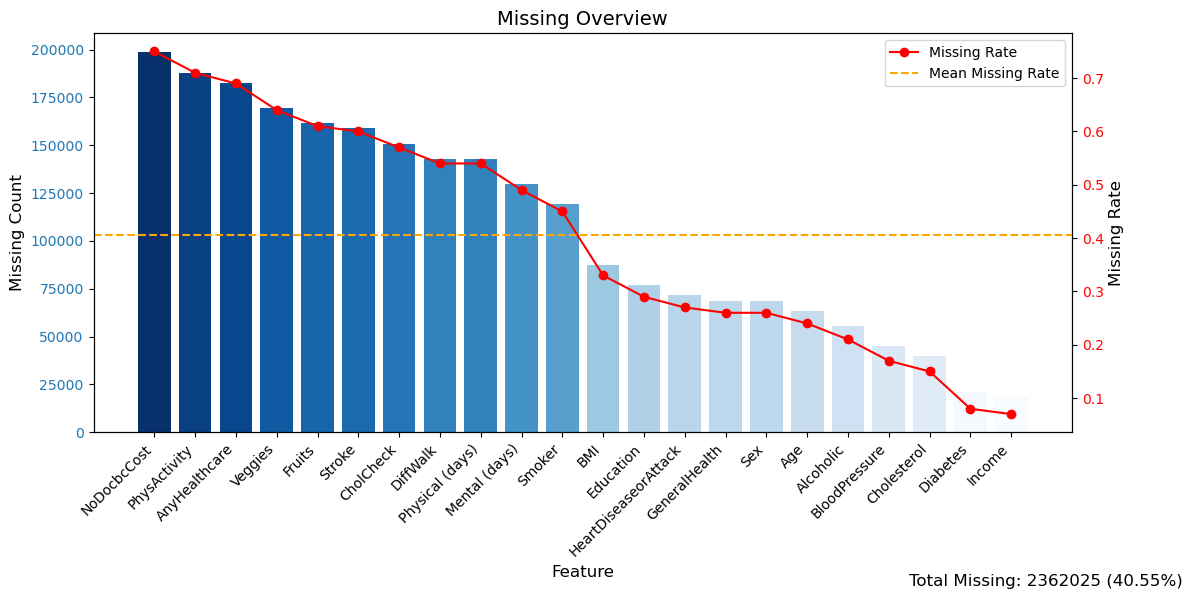

In [160]:
plot_missing_statistics(df, title='Missing Overview')

## 2.5 分布可视化

这里我们定义了 分布可视化工具 ``plot_distributions(df: pd.DataFrame, unique_threshold: int = 20,numeric_title: str = "Numeric Feature Distributions",categorical_title: str = "Categorical Feature Distributions",n_cols: int = 4, wrap_width: int = 50)`` ，调用:
- 连续型特征分布可视化工具 ``plot_numeric_distributions(df: pd.DataFrame, numeric_features: list, title: str = "Numeric Feature Distributions")``
- 离散型特征分布可视化工具 ``plot_categorical_distributions(df: pd.DataFrame, categorical_features: list, n_cols: int = 4, title: str = "Categorical Feature Distributions", wrap_width: int = 50)``

In [ ]:
def plot_numeric_distributions(df: pd.DataFrame, numeric_features: list, title: str = "Numeric Feature Distributions"):
    """
    绘制数值型特征的小提琴图，并添加合理的辅助线。
    会自动跳过 DataFrame 中不存在的列，避免 KeyError

    参数:
    ----
    df : pd.DataFrame
        输入数据集
    numeric_features : list
        数值型特征列名
    title : str, default="Numeric Feature Distributions"
        图表标题
    """
    existing_cols = [col for col in numeric_features if col in df.columns]
    missing_cols = [col for col in numeric_features if col not in df.columns]

    if missing_cols:
        print(f"警告：以下数值列在 DataFrame 中不存在，将被跳过：{missing_cols}")

    if not existing_cols:
        print("没有有效的数值特征可绘制。")
        return

    X_num = df[existing_cols]

    plt.figure(figsize=(len(existing_cols) * 3, 6))
    for i, col in enumerate(existing_cols):
        plt.subplot(1, len(existing_cols), i + 1)
        sns.violinplot(y=X_num[col], inner="box", color="skyblue")
        plt.title(col, fontsize=10)
        plt.xlabel("Density")
        plt.ylabel("")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_categorical_distributions(df: pd.DataFrame, categorical_features: list, n_cols: int = 4, title: str = "Categorical Feature Distributions", wrap_width: int = 50):
    """
    绘制分类特征的分布图（含缺失值标记为 Unknown），自动处理标题过长换行。
    会自动跳过 DataFrame 中不存在的列，避免 KeyError
    """
    def wrap_label(label, width=wrap_width):
        return "\n".join(textwrap.wrap(label, width=width))

    existing_cols = [col for col in categorical_features if col in df.columns]
    missing_cols = [col for col in categorical_features if col not in df.columns]

    if missing_cols:
        print(f"⚠️ 警告：以下分类列在 DataFrame 中不存在，将被跳过：{missing_cols}")

    if not existing_cols:
        print("❌ 没有有效的分类特征可绘制。")
        return

    X_plot = df[existing_cols].fillna("Unknown")
    plt.rcParams.update({'font.size': 10})

    n_rows = len(existing_cols) // n_cols + (1 if len(existing_cols) % n_cols > 0 else 0)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(existing_cols):
        value_counts = X_plot[col].value_counts(dropna=False)
        value_props = value_counts / value_counts.sum()

        norm = plt.Normalize(value_counts.min(), value_counts.max())
        bar_colors = cm.Blues(norm(value_counts.values))

        color_list = ["lightgray" if cat == "Unknown" else bar_colors[idx] 
                      for idx, cat in enumerate(value_counts.index)]

        bars = axes[i].bar(value_counts.index.astype(str), value_counts.values, color=color_list)
        axes[i].set_title(wrap_label(f'{col} Distribution'), fontsize=10) 
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)
        for label in axes[i].get_xticklabels():
            label.set_horizontalalignment('right')

        for bar, prop in zip(bars, value_props):
            axes[i].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f'{prop:.2%}',
                ha='center',
                va='bottom'
            )

    # 隐藏多余子图
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()  # 不设置 rect
    plt.suptitle(title, fontsize=14, x=0.5, ha='center', y=1.02)
    plt.show()

In [162]:
def plot_distributions(df: pd.DataFrame, unique_threshold: int = 20,numeric_title: str = "Numeric Feature Distributions",categorical_title: str = "Categorical Feature Distributions",n_cols: int = 4, wrap_width: int = 50):
    """
    分布可视化总函数：区分特征类型并绘制分布图

    参数:
    ----
    df : pd.DataFrame
        输入数据集
    unique_threshold : int, default=20
        唯一值少于该阈值判定为类别型
    numeric_title : str, default="Numeric Feature Distributions"
        数值特征图表标题
    categorical_title : str, default="Categorical Feature Distributions"
        分类特征图表标题
    verbose : bool, default=False
        是否打印特征类型表格
    n_cols : int, default=4
        分类特征子图每行数量
    """
    print("=== 数据集基本信息 ===")
    print(f"样本数: {df.shape[0]}, 特征数: {df.shape[1]}")
    
    # 区分特征类型
    numeric_features, categorical_features = identify_feature_types(df, unique_threshold=unique_threshold)

    # 绘制数值型特征分布
    if numeric_features:
        print("\n=== 连续特征分布（小提琴图） ===")
        plot_numeric_distributions(df, numeric_features, title=numeric_title)
    else:
        print("没有数值型特征可绘制。")
    
    # 绘制分类特征分布
    if categorical_features:
        print("\n=== 分类特征分布（柱状图） ===")
        plot_categorical_distributions(df, categorical_features, n_cols=n_cols, title=categorical_title, wrap_width=wrap_width)
    else:
        print("没有分类特征可绘制。")

=== 数据集基本信息 ===
样本数: 264802, 特征数: 22

=== 连续特征分布（小提琴图） ===


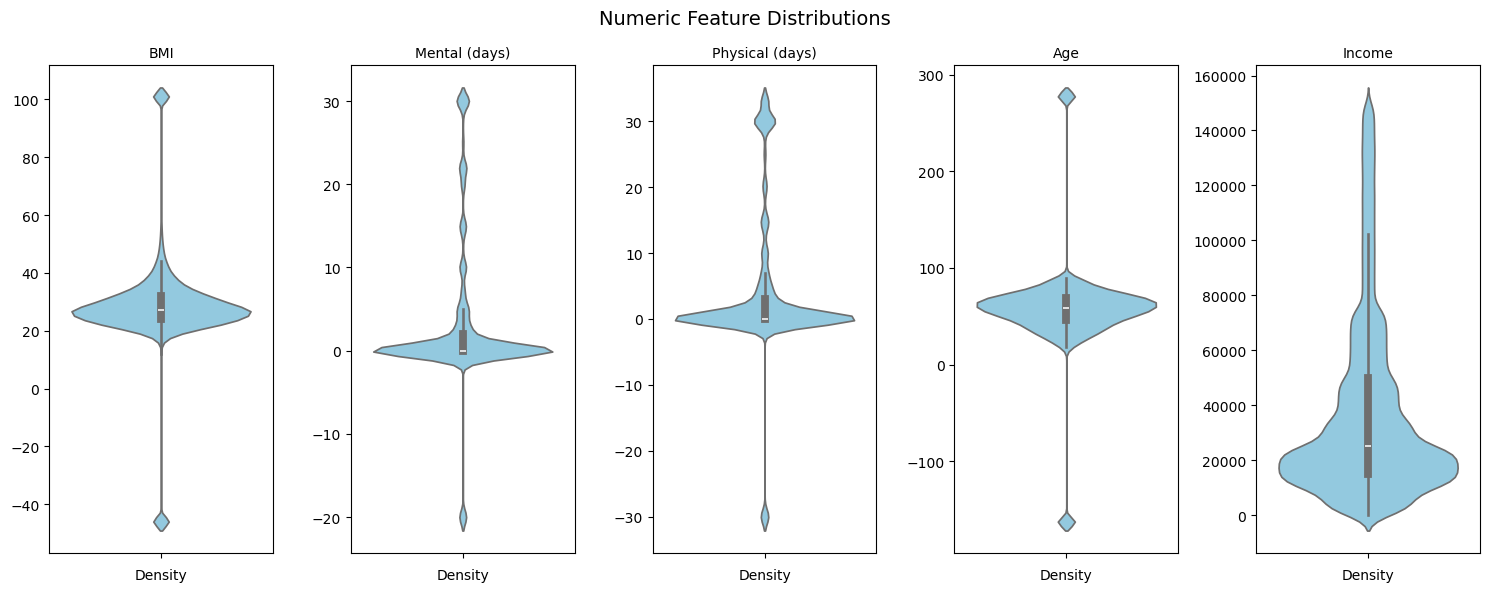


=== 分类特征分布（柱状图） ===


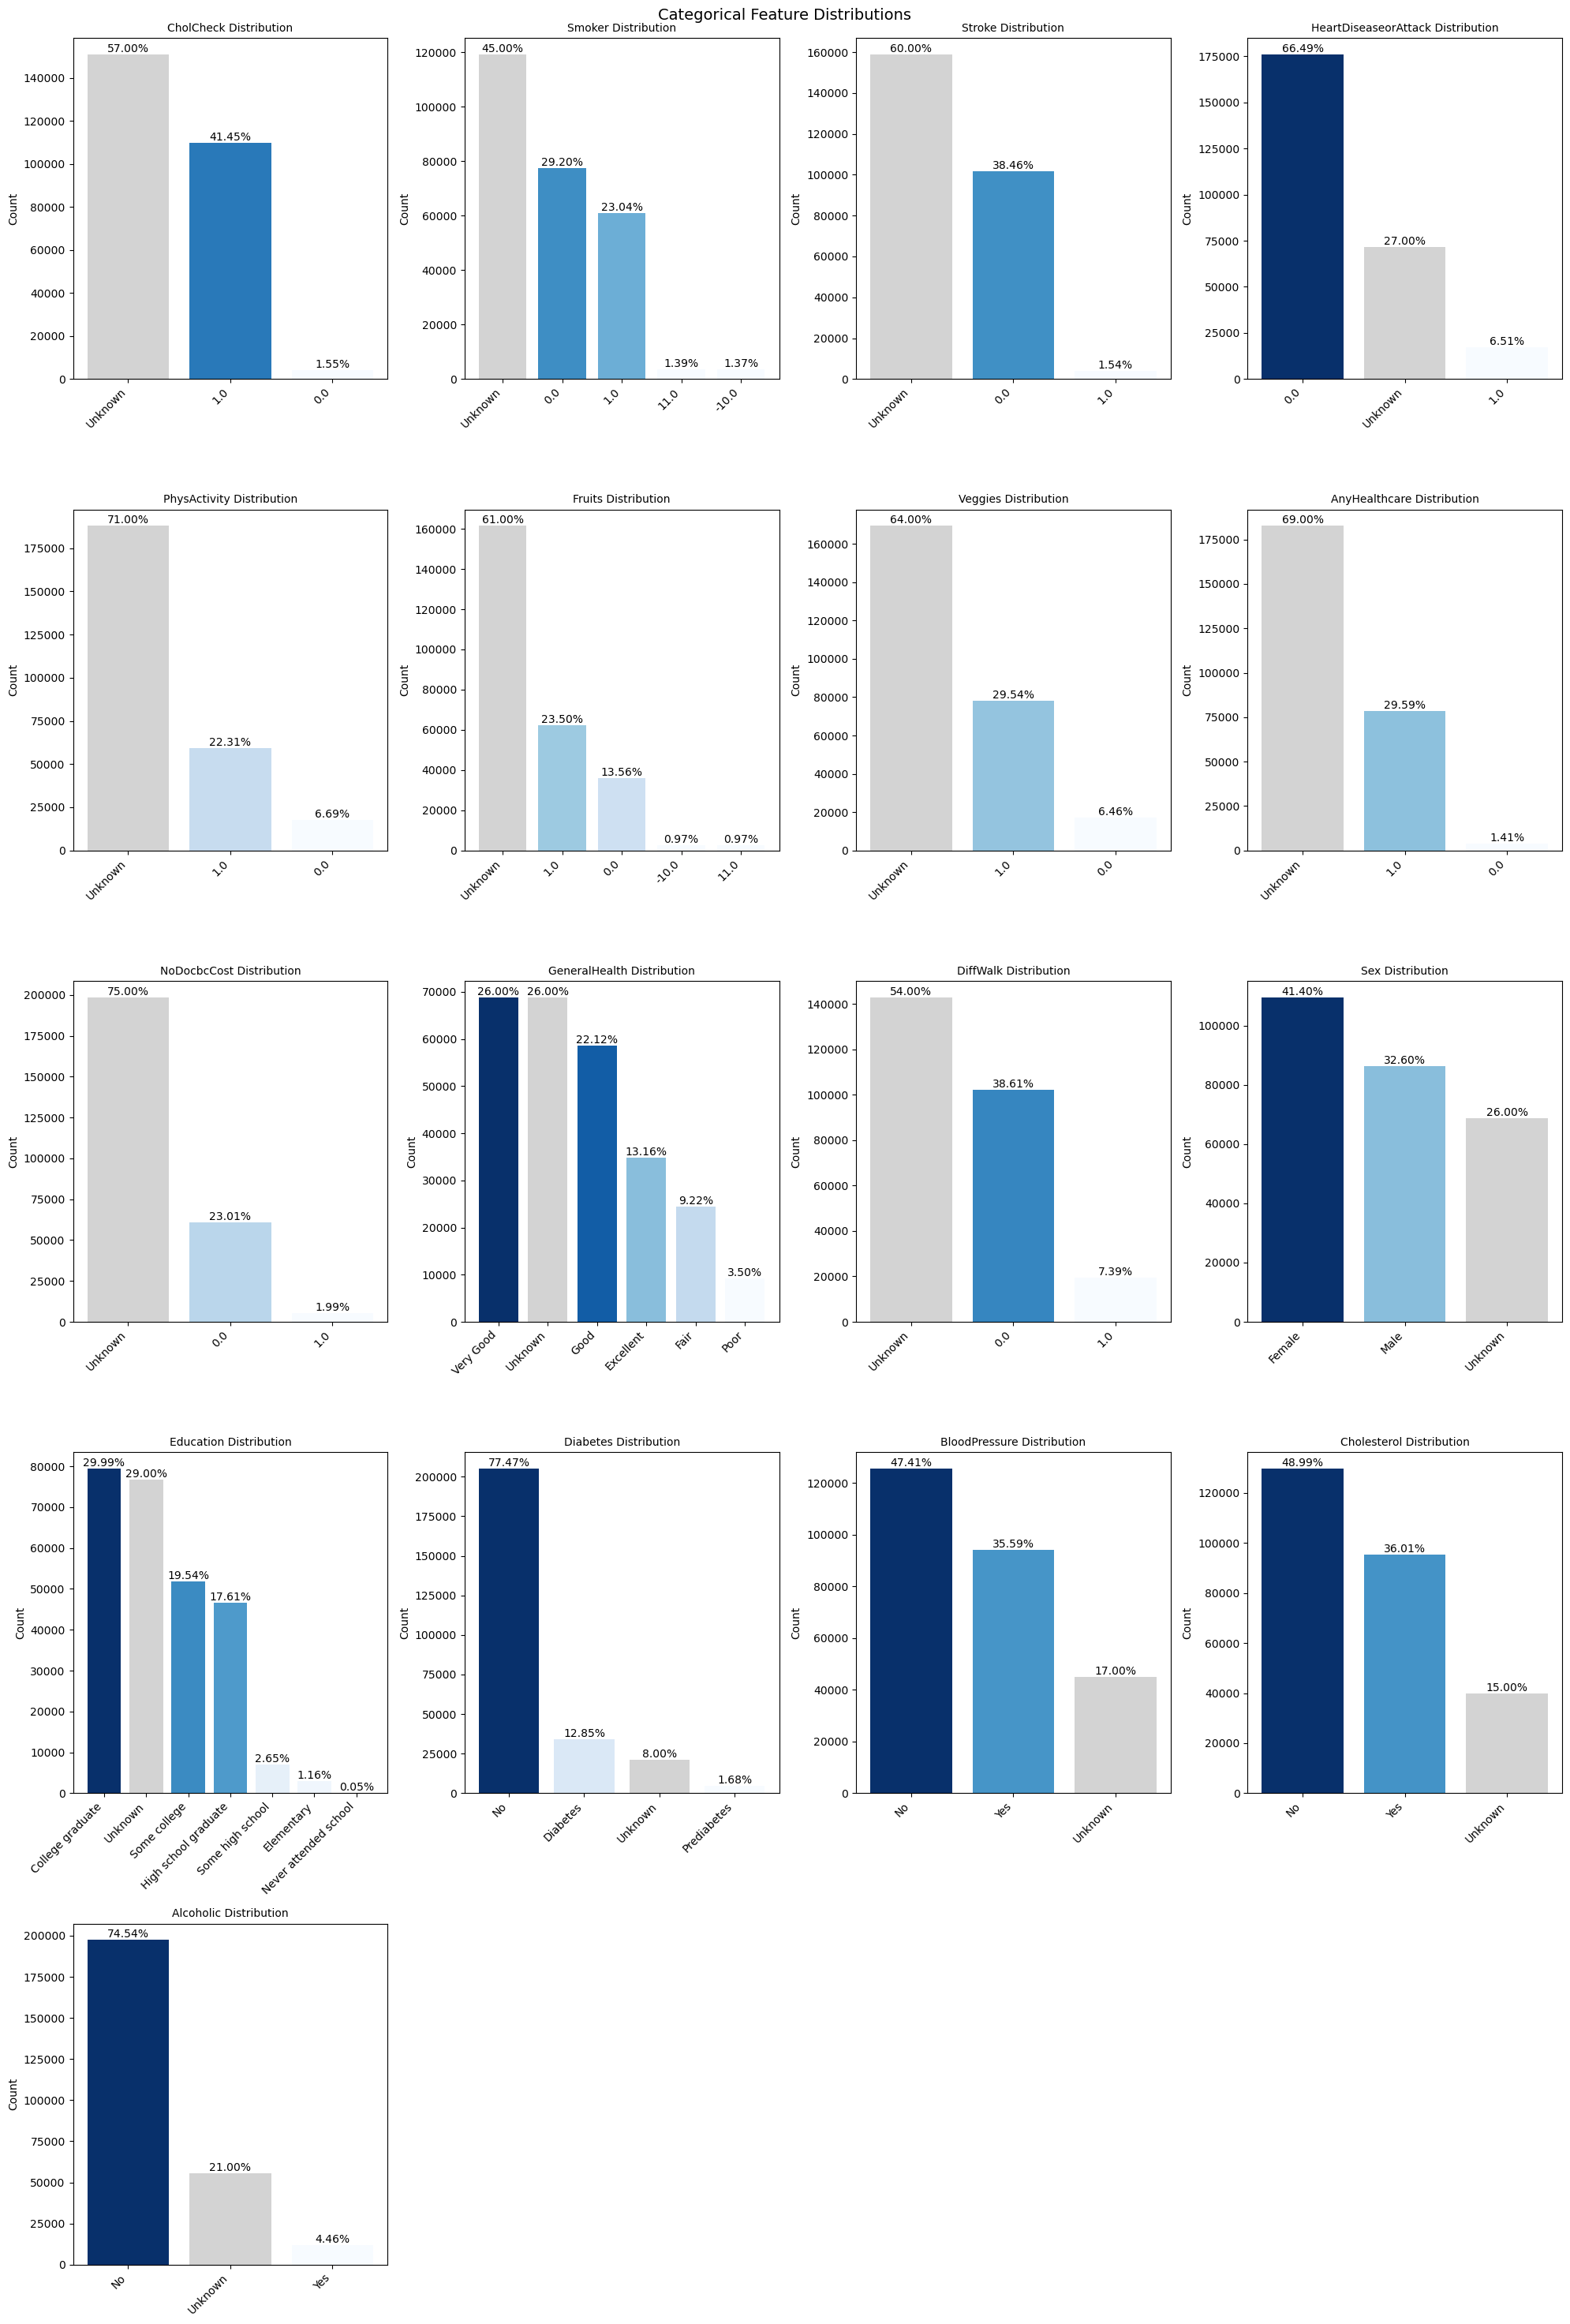

In [163]:
plot_distributions(df)

# 三、数据清洗与处理

分为以下三个部份：
1. **数据清洗** → 保证样本有效性。  
2. **异常值处理** → 避免极端值干扰统计与插补。  
3. **冗余特征处理** → 优化特征结构，避免冗余噪声。  
4. **缺失值处理** → 在干净、稳定的特征空间中进行插补，确保结果更可靠。  

## 3.1 数据清洗

1. 删除无意义列
    - **操作**：若存在 `Unnamed: 0` 列（通常是索引残留），则删除。  

2. Income 清理
    - **操作**：去除 `$`、`,` 等符号，将空字符串替换为缺失值，并转换为数值型。  

3. 删除 Diabetes 缺失行
    - **操作**：若 `Diabetes`（标签列）为空，则删除该行。  

4. GeneralHealth 映射
    - **映射规则**：  
    - Excellent → 5  
    - Very Good → 4  
    - Good → 3  
    - Fair → 2  
    - Poor → 1  

5. Sex 映射
    - **映射规则**：  
    - Male → 1  
    - Female → 0  
 
6. Education 映射
    - **映射规则**：  
    - Never attended school → 0  
    - Elementary → 1  
    - Some high school → 2  
    - High school graduate → 3  
    - Some college → 4  
    - College graduate → 5  

7. 二分类变量映射
    - **适用列**：`BloodPressure`、`Cholesterol`、`Alcoholic`  
    - **映射规则**：  
    - Yes → 1  
    - No → 0  
  
8. Diabetes 标签映射
    - **映射规则**：  
    - No → 0  
    - Diabetes → 1  
    - Prediabetes → 2  

这里定义了
- 数据清洗工具 ``clean_data(df: pd.DataFrame, verbose: bool = True)``
- 特征 & 标签分离工具 ``split_features_labels(df, label_col='Diabetes', verbose=False)``

In [164]:
def clean_data(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    数据清洗函数：对 diabetes_diagnosis 数据集进行基础清理，保证格式一致与可解析。

    步骤：
    - 删除无意义列
    - Income 转换为数值型
    - 删除 Diabetes 缺失行
    - GeneralHealth, Sex, Education 等字段映射
    - 二分类变量映射
    - Diabetes 标签映射

    参数
    ----
    df : pd.DataFrame
        原始数据集
    verbose : bool, default=True
        是否打印检查日志

    返回
    ----
    df : pd.DataFrame
        清理后的数据集
    """

    # 删除可能存在的无意义索引列
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    # Income 清理（去符号、转数值）
    if 'Income' in df.columns and not pd.api.types.is_numeric_dtype(df['Income']):
        df['Income'] = (
            df['Income']
            .replace('[\$,]', '', regex=True)
            .replace('', np.nan)
        )
        df['Income'] = pd.to_numeric(df['Income'], errors='coerce')

    # 去掉 Diabetes 缺失的行（作为标签列）
    if 'Diabetes' in df.columns:
        df = df.dropna(subset=['Diabetes'])

    # GeneralHealth 映射
    health_map = {"Excellent": 5, "Very Good": 4, "Good": 3, "Fair": 2, "Poor": 1}
    if 'GeneralHealth' in df.columns and not pd.api.types.is_numeric_dtype(df['GeneralHealth']):
        original_vals = set(df["GeneralHealth"].dropna().unique())
        df["GeneralHealth"] = df["GeneralHealth"].map(health_map)
        unmapped = original_vals - set(health_map.keys())
        if unmapped:
            print(f"警告: GeneralHealth 存在未映射值: {unmapped}")
        elif verbose:
            print("GeneralHealth 映射完成，无异常。")

    # Sex 映射
    sex_map = {"Male": 1, "Female": 0}
    if 'Sex' in df.columns and not pd.api.types.is_numeric_dtype(df['Sex']):
        original_vals = set(df["Sex"].dropna().unique())
        df["Sex"] = df["Sex"].map(sex_map)
        unmapped = original_vals - set(sex_map.keys())
        if unmapped:
            print(f"警告: Sex 存在未映射值: {unmapped}")
        elif verbose:
            print("Sex 映射完成，无异常。")

    # Education 映射
    edu_map = {
        "Never attended school": 0,
        "Elementary": 1,
        "Some high school": 2,
        "High school graduate": 3,
        "Some college": 4,
        "College graduate": 5
    }
    if 'Education' in df.columns and not pd.api.types.is_numeric_dtype(df['Education']):
        original_vals = set(df["Education"].dropna().unique())
        df["Education"] = df["Education"].map(edu_map)
        unmapped = original_vals - set(edu_map.keys())
        if unmapped:
            print(f"警告: Education 存在未映射值: {unmapped}")
        elif verbose:
            print("Education 映射完成，无异常。")

    # 二分类变量映射
    binary_map = {"No": 0, "Yes": 1}
    for col in ['BloodPressure', 'Cholesterol', 'Alcoholic']:
        if col in df.columns and not pd.api.types.is_numeric_dtype(df[col]):
            original_vals = set(df[col].dropna().unique())
            df[col] = df[col].map(binary_map)
            unmapped = original_vals - set(binary_map.keys())
            if unmapped:
                print(f"警告: {col} 存在未映射值: {unmapped}")
            elif verbose:
                print(f"{col} 映射完成，无异常。")

    # Diabetes 映射（标签）
    y_map = {'No': 0, 'Diabetes': 1, 'Prediabetes': 2}
    if 'Diabetes' in df.columns and not pd.api.types.is_numeric_dtype(df['Diabetes']):
        original_vals = set(df["Diabetes"].dropna().unique())
        df['Diabetes'] = df['Diabetes'].map(y_map)
        unmapped = original_vals - set(y_map.keys())
        if unmapped:
            print(f"警告: Diabetes 存在未映射值: {unmapped}")
        elif verbose:
            print("Diabetes 标签映射完成，无异常。")

    return df

In [165]:
def split_features_labels(df, label_col='Diabetes', verbose=False):
    """
    将标签列与特征列分离，并对标签进行数值映射。

    参数:
    ----
    df : pd.DataFrame
        原始数据集
    label_col : str, default='Diabetes'
        标签列名
    verbose : bool, default=False
        是否输出标签统计信息

    返回:
    ----
    X : pd.DataFrame
        特征数据
    y : pd.Series
        标签数据（数值型）
    mapping_rule : dict
        类别到数值的映射规则
    """
    # 特征列
    X = df.drop(columns=[label_col])
    y = df[label_col].copy()

    # 映射规则
    mapping_rule = {'No': 0, 'Diabetes': 1, 'Prediabetes': 2}

    # 判断 y 是否已部分映射为数值
    if y.dtype == 'O' or y.isin(mapping_rule.keys()).any():
        # 只映射未处理的部分
        y = y.map(lambda v: mapping_rule[v] if v in mapping_rule else v)

    # 检查是否仍有异常值
    unique_vals = y.unique()
    expected_vals = set(mapping_rule.values())
    unexpected_vals = [v for v in unique_vals if v not in expected_vals]

    if verbose:
        counts = y.value_counts(dropna=False)
        ratios = y.value_counts(normalize=True, dropna=False)
        result = pd.DataFrame({
            'Value': counts.index.astype('Int64'),
            'Class': counts.index.map({v:k for k,v in mapping_rule.items()}).fillna("Unknown"),
            'Count': counts.values,
            'Proportion': (ratios.loc[counts.index]*100).round(2).astype(str) + '%'
        })
        print(tabulate(result[['Value','Class','Count','Proportion']], headers='keys', tablefmt='grid', showindex=False, stralign='center', numalign='center'))

    # 报告异常值
    if len(unexpected_vals) > 0:
        print(f"警告: 标签列存在未映射或异常值: {unexpected_vals}")
    else:
        if verbose:
            print("标签列检查完成，没有发现异常值。")

    return X, y

In [438]:
df = pd.read_csv('diabetes_diagnosis.csv')
df = clean_data(df, verbose=True)
# plot_distributions(df)
X, y = split_features_labels(df, label_col='Diabetes', verbose=True)
numeric_features, categorical_features = identify_feature_types(df, verbose=True)


GeneralHealth 映射完成，无异常。
Sex 映射完成，无异常。
Education 映射完成，无异常。
BloodPressure 映射完成，无异常。
Cholesterol 映射完成，无异常。
Alcoholic 映射完成，无异常。
Diabetes 标签映射完成，无异常。
+---------+-------------+---------+--------------+
|  Value  |    Class    |  Count  |  Proportion  |
+=========+=============+=========+==============+
|    0    |     No      | 205133  |    84.2%     |
+---------+-------------+---------+--------------+
|    1    |  Diabetes   |  34026  |    13.97%    |
+---------+-------------+---------+--------------+
|    2    | Prediabetes |  4459   |    1.83%     |
+---------+-------------+---------+--------------+
标签列检查完成，没有发现异常值。
+----------------------+-------------+
|       Feature        |    Type     |
+======================+=============+
|      CholCheck       | categorical |
+----------------------+-------------+
|         BMI          |   numeric   |
+----------------------+-------------+
|        Smoker        | categorical |
+----------------------+-------------+
|        Stroke        | cat

## 3.2 异常值处理

离散型变量的数值通常是编码后的类别标签，其数值本身并不具备可比较的大小关系，也没有明确的量化意义。在这种情况下，针对离散型变量直接进行异常值检测没有统计意义，因为数值大小并不表示强度或量度关系。若误将离散变量的编码值作为连续数值处理，可能导致错误剔除或修改类别，从而破坏原有类别信息。因此，异常值处理仅针对连续型变量进行，确保处理的数值有实际量化意义，并不会改变类别结构。

### 3.2.1 连续特征分布

连续特征分布可视化中：
- 一维分布 → 检测明显极端值，最简单直观。
- 二维分布 → 捕捉联合异常点，兼顾直观性和有效性。
- 三维及以上 → 可视化价值有限，统计估计困难，通常用算法替代。
因此我们对连续特征进行一维和二维分布的可视化。

In [439]:
# -------- 参考线函数 --------
def add_reference_lines(ax, varname: str, axis: str = "x"):
    """
    在指定坐标轴上添加参考线
    """
    name = varname.lower()
    if axis == "x":
        if name == "bmi":
            ax.axvline(10, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
            ax.axvline(60, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
        elif name in ["mental (days)", "physical (days)"]:
            ax.axvline(0, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
            ax.axvline(31, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
        elif name in ["age", "income"]:
            ax.axvline(0, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
    else:
        if name == "bmi":
            ax.axhline(10, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
            ax.axhline(60, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
        elif name in ["mental (days)", "physical (days)"]:
            ax.axhline(0, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
            ax.axhline(31, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
        elif name in ["age", "income"]:
            ax.axhline(0, color="red", linestyle="--", linewidth=0.8, alpha=0.5)

# -------- 多项式拟合函数 --------
def add_polynomial_fit(ax, x, y, degree: int = 3, color: str = "black"):
    """
    在散点图上添加多项式拟合曲线
    """
    x = np.array(x)
    y = np.array(y)
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]
    if len(x) < degree + 1:  # 数据不足以拟合
        return

    coeffs = np.polyfit(x, y, degree)
    poly = np.poly1d(coeffs)

    x_fit = np.linspace(x.min(), x.max(), 500)
    y_fit = poly(x_fit)

    ax.plot(
        x_fit, y_fit,
        color="black",      # 黑色
        lw=1,               # 更细的线条
        linestyle="--",     # 虚线
        alpha=0.8
    )

# -------- 主函数 --------
def plot_continuous_distributions_2d(
    X: pd.DataFrame,
    numeric_features: list,
    add_refs: bool = False,
    add_fit: bool = False,
    degree: int = 3,
    main_title: str = "Continuous Features Distributions"
):
    """
    绘制连续型变量的一维(小提琴图)与二维(散点矩阵)分布
    """
    X_num = X[numeric_features]

    # -------- 1. 小提琴图 --------
    plt.figure(figsize=(len(numeric_features) * 3, 6))
    for i, col in enumerate(numeric_features):
        ax = plt.subplot(1, len(numeric_features), i + 1)
        sns.violinplot(y=X_num[col], inner="box", color="skyblue", ax=ax)
        ax.set_title(col, fontsize=10)
        ax.set_xlabel("Density")
        ax.set_ylabel("")
        if add_refs:
            add_reference_lines(ax, col, axis="y")

    if main_title:
        plt.suptitle(main_title + " - Violin Plots", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    # -------- 2. 散点矩阵 --------
    sampled_X = X_num.sample(min(1000, len(X_num)), random_state=42)
    g = sns.pairplot(sampled_X)

    if main_title:
        g.fig.suptitle(main_title + " - Scatter Matrix", fontsize=14, y=1.02)
    else:
        g.fig.suptitle("Scatter Matrix of Continuous Features (Sampled)", fontsize=14, y=1.02)

    for i, row_var in enumerate(g.y_vars):
        for j, col_var in enumerate(g.x_vars):
            ax = g.axes[i, j]
            if i == j:
                if add_refs:
                    add_reference_lines(ax, row_var, axis="x")
            else:
                if add_refs:
                    add_reference_lines(ax, row_var, axis="y")
                    add_reference_lines(ax, col_var, axis="x")
                if add_fit:
                    add_polynomial_fit(ax, sampled_X[col_var], sampled_X[row_var], degree)

    plt.show()

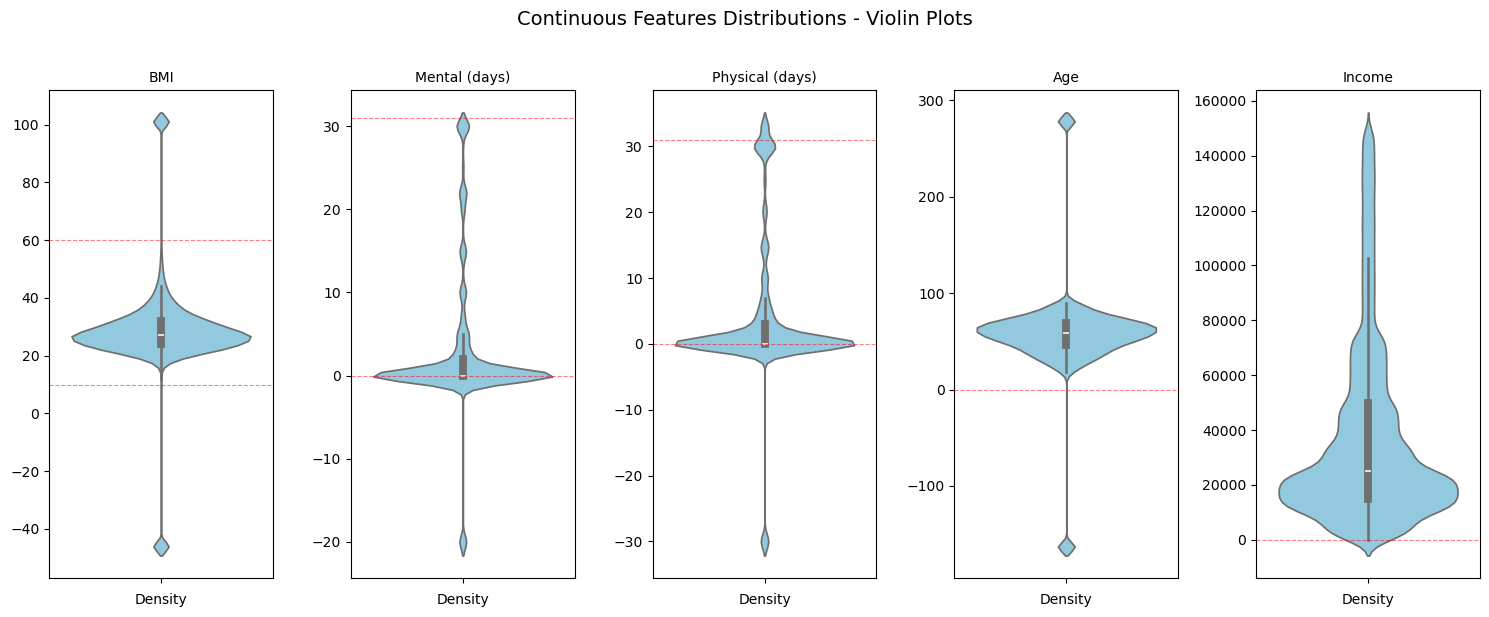

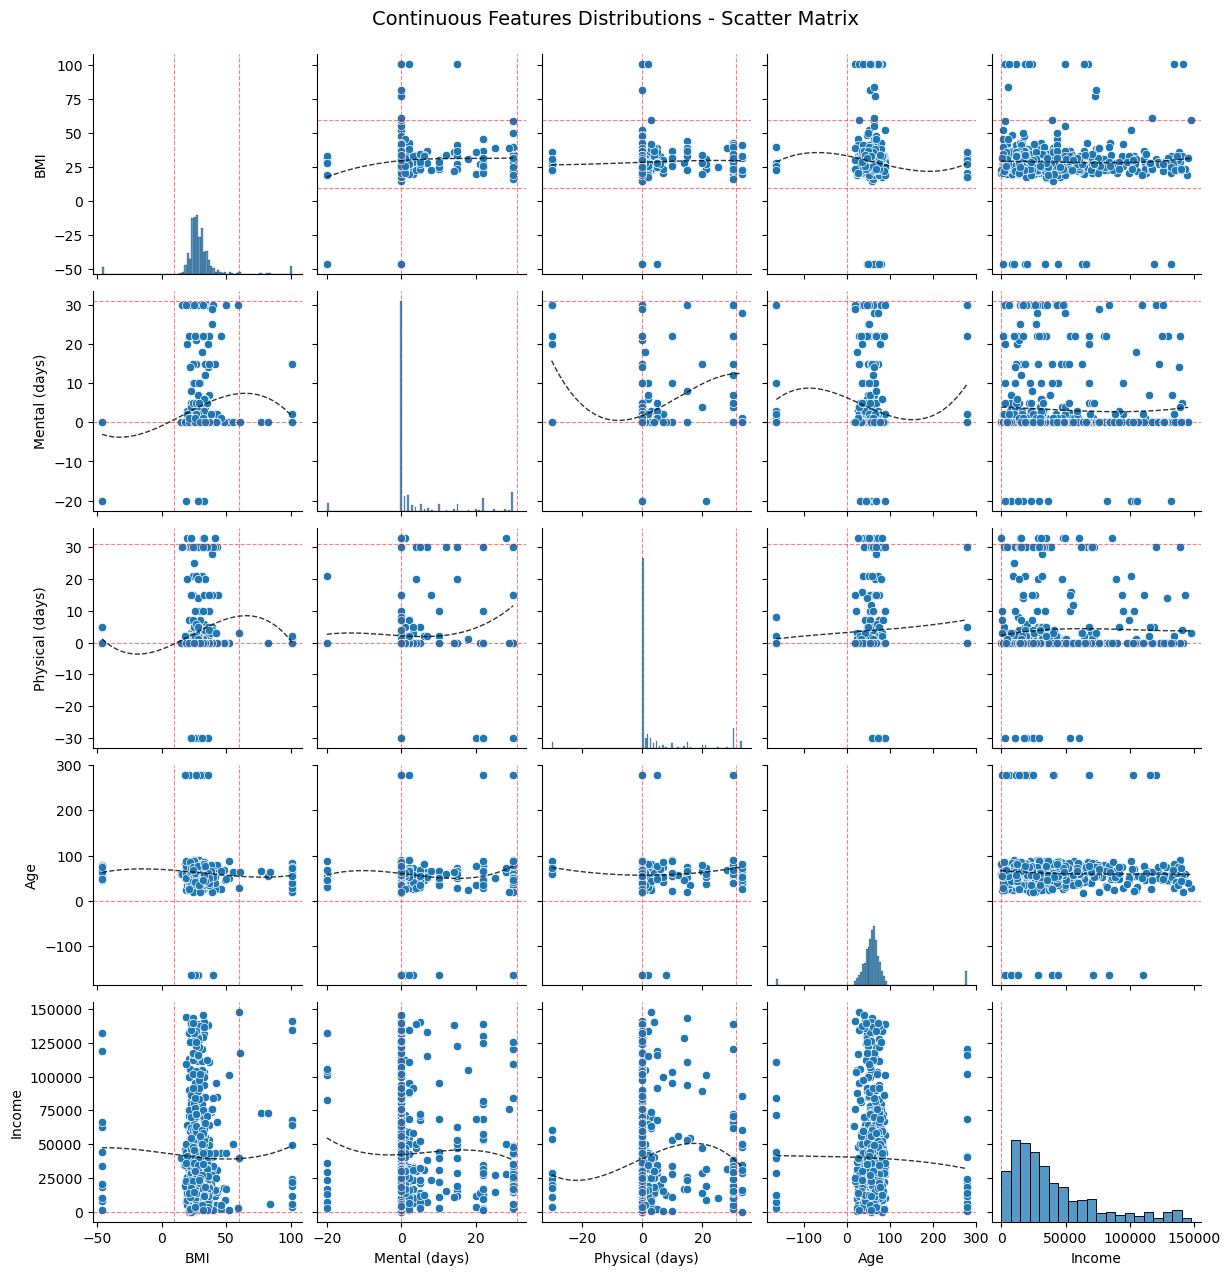

In [440]:
plot_continuous_distributions_2d(X, numeric_features, add_refs=True, add_fit=True, degree=3)

### 3.2.2 初步处理方案分析

在本数据集中，数值型特征包括 **BMI (Body Mass Index)**、**Age**、**Income**、以及涉及天数的 **Mental (days)** 和 **Physical (days)**。结合统计学原则、医学和社会学背景，可得以下结论：

1. **理论范围与背景知识**  
   - **BMI**：根据世界卫生组织（WHO）标准，人体BMI通常在 **10–60** 之间。BMI <10 或 >60 极端异常。  
   - **Age（年龄）**：理论上应大于等于 0。负值或极端异常均不符合生物学规律。  
   - **Mental (days) / Physical (days)**：天数应在 **0–31** 之间。负值或大于31均为异常数据。  
   - **Income（收入）**：社会经济背景允许收入分布较宽，因此即便出现偏态或极端值，也可以认为在可接受范围内，不直接视为异常。  

2. **集中出现的异常值**  
    - Mental (days)：-20  
    - Physical (days)：-30, 33  
    - BMI：-46, 101  
    - Age：-163, 278  

这些集中出现的异常值均超出理论合理范围，且可能源于数据采集过程中的人工编码或特殊标记，尚不明确其具体含义。基于统计学稳健性原则，这类异常值会对均值、方差、回归模型等分析产生显著影响，应当剔除。上述集中出现的异常基本都出现在理论范围外，因此可以直接应用理论范围，但是BMI超出 60 的部份还有很多没有其中趋势，因此对BMI 需要进行进一步分析

### 3.2.3 初步处理
- **处理范围**：
  - BMI < 0 或 = 101 → NaN  
  - Age < 0 或 = 278 → NaN  
  - Mental (days) < 0 或 > 31 → NaN  
  - Physical (days) < 0 或 > 31 → NaN  
- 之后对BMI进行更深入分析

In [441]:

def handle_anomalies(df: pd.DataFrame, conditions: dict, save_path: str = None) -> pd.DataFrame:
    """
    处理数据中的异常值：统计异常数量和占比，并替换为 NaN。
    
    参数:
    ----
    df : pd.DataFrame
        输入的原始数据
    conditions : dict
        每列的异常条件，例如:
        {
            'BMI': (df['BMI'] < 0) | (df['BMI'] == 101),
            'Age': (df['Age'] < 0) | (df['Age'] == 278),
        }
    save_path : str, default=None
        保存清洗后的数据路径，若为 None 则不保存
    
    返回:
    ----
    df_clean : pd.DataFrame
        清洗后的数据
    """
    df_clean = df.copy()
    n_rows = len(df)

    # 统计异常
    anomaly_summary = []
    for col, cond in conditions.items():
        count = cond.sum()
        ratio = count / n_rows * 100
        anomaly_summary.append([col, count, f"{ratio:.2f}%"])
        
        # 替换异常为 NaN
        df_clean.loc[cond, col] = np.nan

    # 输出异常汇总表
    print(tabulate(anomaly_summary,headers=['Feature', 'Replaced as NaN', 'Proportion'],tablefmt='grid',stralign='center',numalign='center'))

    # 保存结果（如果指定了路径）
    if save_path:
        df_clean.to_csv(save_path, index=False, encoding="utf-8-sig")
        print(f" initial_anomaly_handled data saved at: {os.path.abspath(save_path)}")

    return df_clean

In [442]:
conditions = {
    'BMI': (df['BMI'] < 0) | (df['BMI'] == 101),
    'Age': (df['Age'] < 0) | (df['Age'] == 278),
    'Mental (days)': (df['Mental (days)'] < 0) | (df['Mental (days)'] > 31),
    'Physical (days)': (df['Physical (days)'] < 0) | (df['Physical (days)'] > 31)
}

df = handle_anomalies(df, conditions, save_path = '[Step1:PreliminaryOutlierProcessing]diabetes_diagnosis.csv')

+-----------------+-------------------+--------------+
|     Feature     |  Replaced as NaN  |  Proportion  |
+=================+===================+==============+
|       BMI       |       8144        |    3.34%     |
+-----------------+-------------------+--------------+
|       Age       |       9283        |    3.81%     |
+-----------------+-------------------+--------------+
|  Mental (days)  |       3093        |    1.27%     |
+-----------------+-------------------+--------------+
| Physical (days) |       5667        |    2.33%     |
+-----------------+-------------------+--------------+
 initial_anomaly_handled data saved at: /Users/guocy/Projects/5310_a1/diabetes/[Step1:PreliminaryOutlierProcessing]diabetes_diagnosis.csv


### 3.2.4 BMI 处理方案验证

我们需要验证 WHO 提供的 [10, 60] 的 BMI 范围在本数据集上的适用性。首先，应对 BMI 列计算其基本统计特征。

In [506]:
def plot_single_continuous_distribution(df: pd.DataFrame, column: str = "BMI"):
    """
    绘制单个连续型特征分布的小提琴图，标注统计量、IQR范围和异常值比例。
    如果 IQR 上下界限超出数据范围，则不在图上标注。
    """
    # --- 1. 提取非 NaN 数据 ---
    data = df[column].dropna()

    # --- 2. 计算统计特征 ---
    Q1 = data.quantile(0.25)
    Median = data.median()
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data_min, data_max = data.min(), data.max()

    stats = {
        'Count': len(data),
        'Mean': data.mean(),
        'Std': data.std(),
        'Min': data_min,
        '25%': Q1,
        '50% (Median)': Median,
        '75%': Q3,
        'Max': data_max,
        'IQR': IQR,
        'Skewness': data.skew(),
        'Kurtosis': data.kurtosis()
    }

    # --- 3. 计算异常值 ---
    lower_outliers = data[data < lower_bound]
    upper_outliers = data[data > upper_bound]
    n_lower, n_upper = len(lower_outliers), len(upper_outliers)
    pct_lower, pct_upper = n_lower / len(data) * 100, n_upper / len(data) * 100
    outlier_text = f"Lower outliers: {n_lower} ({pct_lower:.1f}%)\nUpper outliers: {n_upper} ({pct_upper:.1f}%)"

    # --- 4. 绘图 ---
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.violinplot(y=data, inner=None, color='skyblue', ax=ax)
    sns.boxplot(
        y=data, width=0.1, showcaps=True,
        boxprops={'facecolor': 'none'},
        whiskerprops={'color': 'black'},
        medianprops={'color': 'red'},
        ax=ax
    )

    # --- 5. 统计信息标注 ---
    stats_table = "\n".join([f"{k}: {v:.2f}" if isinstance(v, (int, float)) else f"{k}: {v}" 
                             for k, v in stats.items()])
    annotation = stats_table + "\n" + outlier_text
    ax.text(
        0.05, 0.95, annotation,
        transform=ax.transAxes,
        fontsize=10, color='black',
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

    # --- 6. IQR 上下界限标注（只在有效范围内显示） ---
    if data_min <= lower_bound <= data_max:
        ax.text(0.99, lower_bound, f'Lower bound = {lower_bound:.2f}',
                transform=ax.get_yaxis_transform(), ha='right', va='center', fontsize=9, color='black')
    if data_min <= upper_bound <= data_max:
        ax.text(0.99, upper_bound, f'Upper bound = {upper_bound:.2f}',
                transform=ax.get_yaxis_transform(), ha='right', va='center', fontsize=9, color='black')

    # --- 7. 美化 ---
    ax.set_ylabel(column)
    ax.set_title(f"{column} Distribution with IQR", fontsize=14)
    # 删除 ax.legend()，因为没有绘制图例，否则会报错
    plt.tight_layout()
    plt.show()

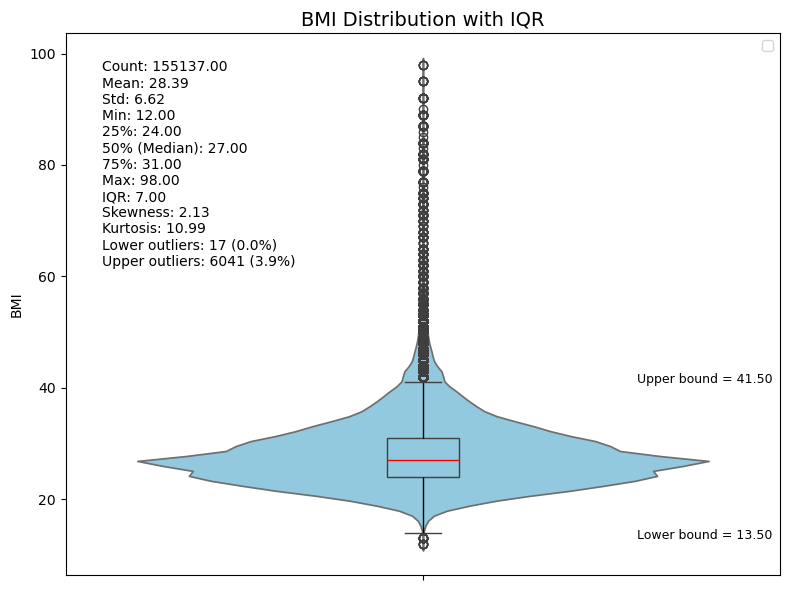

In [444]:
plot_single_continuous_distribution(df, column = "BMI")

整体 BMI 数据分析显示，样本量为 155137，均值 28.39 高于中位数 27.00，说明整体分布明显右偏（右尾较长）。标准差为 6.62，极值范围从 12 到 98，偏度 2.13、峰度 10.99 进一步表明数据右偏且集中在中低 BMI 范围。

通过计算 IQR（Q3-Q1=7），下界和上界分别为 Q1-1.5*IQR=13.5 和 Q3+1.5*IQR=41.5。实际数据中，低于下界的样本有 17，占比约 0.0%，高于上界的样本有 6041，占比 3.9%，这些异常值主要集中在高 BMI 区间。

基于此，为了分析不同 BMI 区间对糖尿病患病风险的影响，我们结合理论值 10-60、IQR 上下界和中位数，将 BMI 分为 5 个区间进行亚组分析。亚组分析的目的是在控制总体分布偏态的前提下，进一步通过可视化和 Mann-Whitney U 检验量化每个 BMI 区间糖尿病组与非糖尿病组的 BMI 分布差异，从而识别各亚组的风险趋势。

In [445]:
def bin_numeric_column(df: pd.DataFrame, col: str, user_bins: list = None):
    """
    对数值列进行分箱（结合 IQR + 中位数 + 用户自定义边界），
    对用户边界进行简单修正：
        - 小于实际最小值 → 最小值
        - 大于实际最大值 → 最大值

    参数:
    ----
    df : pd.DataFrame
        数据集
    col : str
        数值列名
    user_bins : list, optional
        用户自定义边界

    返回:
    ----
    df_copy : pd.DataFrame
        带 'group_label' 列的副本
    bins : list
        实际用于分箱的边界
    labels : list
        分箱标签
    """
    df_copy = df[[col]].copy().dropna()
    min_val, max_val = df_copy[col].min(), df_copy[col].max()

    # 1. 默认边界
    Q1, Median, Q3 = df_copy[col].quantile([0.25, 0.5, 0.75])
    IQR = Q3 - Q1
    default_min = max(min_val, Q1 - 1.5*IQR)
    default_max = min(max_val, Q3 + 1.5*IQR)
    default_bins = [min_val, default_min, Median, default_max, max_val]

    # 2. 合并用户边界
    if user_bins:
        # 修正超出边界的用户值
        user_bins_corrected = [max(min_val, min(b, max_val)) for b in user_bins]
        all_bins = sorted(set(default_bins + user_bins_corrected))
    else:
        all_bins = default_bins

    # 3. 去掉严格重复的边界
    clean_bins = [all_bins[0]]
    for b in all_bins[1:]:
        if b > clean_bins[-1]:
            clean_bins.append(b)

    # 4. 生成标签
    labels = [f"[{clean_bins[i]:.1f}-{clean_bins[i+1]:.1f})" for i in range(len(clean_bins)-1)]

    # 5. 分箱
    df_copy['group_label'] = pd.cut(df_copy[col], bins=clean_bins, labels=labels, right=False)

    return df_copy, clean_bins, labels


def plot_group(
    df: pd.DataFrame,
    numeric_col: str,
    label_col: str,
    main_title: str = None,
    mapping: dict = None,
    user_bins: list = None
):
    """
    绘制数值列分组后的类别比例折线 + 分组柱状图（柱状图显示数量，折线显示比例）。
    柱状图蓝色系（从深到浅），折线图红色系，不在折线上标注比例。
    """
    import matplotlib.ticker as mtick

    # --- 1. 分箱 ---
    df_binned, bins, labels = bin_numeric_column(df, numeric_col, user_bins=user_bins)
    df_binned[label_col] = df.loc[df_binned.index, label_col]

    # --- 2. 类别映射 ---
    if mapping:
        df_binned['category_mapped'] = df_binned[label_col].map(mapping)
    else:
        df_binned['category_mapped'] = df_binned[label_col]

    # --- 3. 分组统计 ---
    group_counts = df_binned.groupby('group_label')['category_mapped'].value_counts().unstack().fillna(0)
    group_perc = group_counts.div(group_counts.sum(axis=1), axis=0) * 100

    # --- 4. 绘图 ---
    fig, ax1 = plt.subplots(figsize=(10,8))
    
    # 左轴：柱状图（stacked），蓝色系从深到浅
    n_colors = group_counts.shape[1]
    bar_colors = plt.cm.Blues(np.linspace(0.9, 0.5, n_colors))  # 深->浅
    group_counts.plot(kind='bar', stacked=True, ax=ax1, color=bar_colors, edgecolor='black', legend=False)
    ax1.set_ylabel("Count")
    ax1.set_xlabel(f"{numeric_col} Groups")
    ax1.set_xticklabels(labels, rotation=45, ha='right')

    # 右轴：折线图（比例），红色系
    ax2 = ax1.twinx()
    colors = plt.cm.Reds(np.linspace(0.5, 0.9, group_perc.shape[1]))
    for i, col_name in enumerate(group_perc.columns):
        y_vals = group_perc[col_name].values
        ax2.plot(range(len(labels)), y_vals, marker='o', linestyle='-', linewidth=1.8, color=colors[i], label=col_name)
        # 去掉折线上比例标注
        # for j, val in enumerate(y_vals):
        #     ax2.text(j, val+1.5, f"{val:.1f}%", ha='center', va='bottom', fontsize=8, color=colors[i])

    ax2.set_ylabel("Percentage (%)")
    ax2.set_ylim(0, 105)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

    # --- 5. 图例 ---
    ax2.legend(title=label_col, loc='upper right', fontsize=9)

    ax1.set_title(main_title if main_title else f"{numeric_col} Groups: Count & Proportion", fontsize=14)
    plt.tight_layout()
    plt.show()

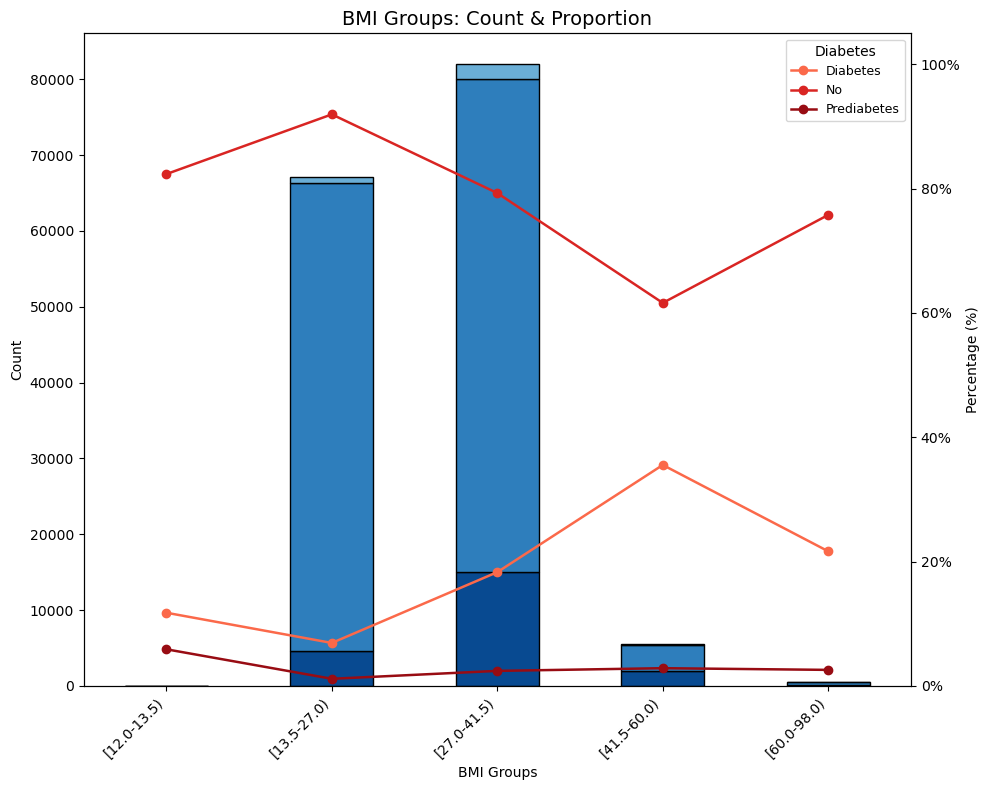

In [446]:
diabetes_mapping = {0: "No", 1: "Diabetes", 2: "Prediabetes"}
user_bins = [10, 60]

plot_group(df, numeric_col='BMI', label_col = 'Diabetes', mapping=diabetes_mapping, user_bins=user_bins)

在 IQR 范围内，糖尿病比例随 BMI 增加呈上升趋势，这与流行病学理论一致。然而，在 IQR 范围之外的部份分箱出现比例异常。考虑到这些分箱的数据量较少，这些异常可能仅反映样本稀疏而非真实趋势。

为了科学评估各分箱与糖尿病之间的关系是否具有统计学显著性，可以对每个分箱进行 Mann-Whitney U 检验（适用于非正态分布或偏态分布的数据）。通过检验 p 值和效应大小，可以判断这些异常分箱是否可靠，从而决定是否将其纳入分析，或者将其视为数据噪声或无效信息。

In [447]:
def mann_whitney_u_test(group1, group2, alternative='two-sided'):
    """
    对两组数值进行 Mann-Whitney U 检验

    参数:
    ----
    group1, group2 : array-like
        待检验的两组数值
    alternative : str
        检验类型，可选 'two-sided', 'less', 'greater'

    返回:
    ----
    stat : float
        Mann-Whitney U 统计量
    p_value : float
        p 值
    """
    if len(group1) > 1 and len(group2) > 1:
        stat, p_value = mannwhitneyu(group1, group2, alternative=alternative)
        return stat, p_value
    else:
        return None, None
    
def mwu_summary_numeric_vs_category(
    df: pd.DataFrame,
    numeric_col: str,
    label_col: str,
    user_bins: list = None
):
    """
    对数值列分组后的数据进行 Mann-Whitney U 检验，统计各组样本量和中位数。
    内部自动分箱，不污染外部变量。

    参数:
    ----
    df : pd.DataFrame
        数据集
    numeric_col : str
        用于分组的数值列
    label_col : str
        类别列
    positive_values : list, optional
        将类别列哪些值视为“正类”或事件（默认 [1,2]）
    user_bins : list, optional
        用户自定义分界线列表，会与默认分界线合并
    """
    # --- 1. 分箱 ---
    df_binned, bins, labels = bin_numeric_column(df, numeric_col, user_bins=user_bins)
    df_binned[label_col] = df.loc[df_binned.index, label_col]

    # --- 2. 构造二分类列（正类 / 非正类） ---
    df_binned['is_positive'] = df_binned[label_col].apply(lambda x: 1 if x in [1,2] else 0)

    # --- 3. 分组统计 + Mann-Whitney U ---
    results = []
    for group, subset in df_binned.groupby('group_label'):
        neg = subset[subset['is_positive']==0][numeric_col]
        pos = subset[subset['is_positive']==1][numeric_col]

        stat, p_value = mann_whitney_u_test(neg, pos)

        results.append([
            group,
            len(subset),
            len(neg),
            len(pos),
            neg.median() if len(neg)>0 else None,
            pos.median() if len(pos)>0 else None,
            f"{stat:.2e}" if stat is not None else None,
            f"{p_value:.2e}" if p_value is not None else None
        ])

    headers = ["Group", "Total", "Neg_n", "Pos_n", "Median_Neg", "Median_Pos", "U_stat", "p_value"]
    result_df = pd.DataFrame(results, columns=headers)
    print(tabulate(result_df, headers=headers, tablefmt="grid", showindex=False))

In [448]:
mwu_summary_numeric_vs_category(df, numeric_col='BMI', label_col='Diabetes', user_bins=user_bins)

+-------------+---------+---------+---------+--------------+--------------+--------------+-----------+
| Group       |   Total |   Neg_n |   Pos_n |   Median_Neg |   Median_Pos |       U_stat |   p_value |
+=============+=========+=========+=========+==============+==============+==============+===========+
| [12.0-13.5) |      17 |      14 |       3 |           13 |           13 |    13.5      |  0.265    |
+-------------+---------+---------+---------+--------------+--------------+--------------+-----------+
| [13.5-27.0) |   67111 |   61716 |    5395 |           24 |           24 |     1.38e+08 |  7.68e-99 |
+-------------+---------+---------+---------+--------------+--------------+--------------+-----------+
| [27.0-41.5) |   81968 |   64995 |   16973 |           30 |           32 |     4.29e+08 |  0        |
+-------------+---------+---------+---------+--------------+--------------+--------------+-----------+
| [41.5-60.0) |    5492 |    3384 |    2108 |           45 |           45

从结果来看，[13.5-27.0) 和 [27.0-41.5) 分箱位于 IQR 范围内，样本量充足且 Mann-Whitney U 检验 p 值极小（分别为 7.68e-99 和 0），说明这两个分箱中糖尿病比例与 BMI 的变化高度显著，符合流行病学预期。中位数上，[13.5-27.0) 和 [27.0-41.5) 分箱中正类中位数分别为 24 和 32，与 BMI 的增加趋势一致，支持其在分析中保留。

[12.0-13.5) 分箱位于 IQR 以下，样本量仅为 17，正类数量为 3。尽管 Mann-Whitney U 检验 p 值为 0.265，不具统计显著性，但由于样本量极小，不能完全排除其潜在意义。在可解释性上，这个低 BMI 分箱属于临床可接受范围，保留可供观察异常低 BMI 对糖尿病比例的影响。

[41.5-60.0) 分箱处于 IQR 之外，样本量为 5,492，正类 2,108，p 值为 1.02e-5，显示统计上显著，可选择保留。

[60.0-98.0) 分箱样本量仅 545，正类 132，中位数正类为 65，低于该组总中位数 77，与总体 BMI-糖尿病趋势不一致，且 Mann-Whitney U 检验仍显著（p = 4.99e-14）但样本量极小，数据可能噪声或异常值的反映。因此删除该分箱可提高数据清洁度和分析可靠性。

### 3.2.5 BMI 处理

综上，我们决定支持 WHO 提供的 [10, 60] 的 BMI 范围。

In [449]:
df = pd.read_csv('[Step1:PreliminaryOutlierProcessing]diabetes_diagnosis.csv')

conditions = {
    'BMI': (df['BMI'] < 0) | (df['BMI'] > 60),
    'Age': (df['Age'] < 0) | (df['Age'] == 278),
    'Mental (days)': (df['Mental (days)'] < 0) | (df['Mental (days)'] > 31),
    'Physical (days)': (df['Physical (days)'] < 0) | (df['Physical (days)'] > 31)
}

df = handle_anomalies(df, conditions, save_path = '[Step2:BMIOutlierProcessing]diabetes_diagnosis.csv')

+-----------------+-------------------+--------------+
|     Feature     |  Replaced as NaN  |  Proportion  |
+=================+===================+==============+
|       BMI       |        503        |    0.21%     |
+-----------------+-------------------+--------------+
|       Age       |         0         |    0.00%     |
+-----------------+-------------------+--------------+
|  Mental (days)  |         0         |    0.00%     |
+-----------------+-------------------+--------------+
| Physical (days) |         0         |    0.00%     |
+-----------------+-------------------+--------------+
 initial_anomaly_handled data saved at: /Users/guocy/Projects/5310_a1/diabetes/[Step2:BMIOutlierProcessing]diabetes_diagnosis.csv


## 3.3 冗余特征处理

在数据集中，特征之间可能存在 **冗余（redundancy）** 或 **重复信息（duplication）**，可能导致：
- **模型估计不稳定**：多重共线性导致系数方差膨胀，回归结果不可靠。
- **信息冗余**：不同特征携带的是相同信息，增加维度却未提升模型解释力。
- **过拟合风险**：噪声在冗余特征间被反复放大，模型泛化能力下降。
- **计算负担加重**：无效特征增加模型复杂度，降低效率。

不同类型的特征之间，冗余的表现形式与检测方法并不相同，我们将冗余关系划分为连续–连续、离散–离散、连续–离散以及多特征共同作用四个部分





其次，离散–离散特征之间的冗余主要体现在类别分布的重合与依赖性。例如“是否吸烟”与“是否饮酒”可能存在较强的联合分布关系。此类冗余通常使用 Cramér’s V、卡方独立性检验或互信息等方法来刻画。如果两者之间强依赖，那么在建模过程中重复保留会降低特征集的独立性和解释性。

第三，连续–离散特征之间的冗余则需要考虑不同尺度下的依赖关系。例如教育水平（离散）与收入（连续）之间往往存在阶梯式的单调关系。在这种情况下，可以通过 ANOVA 方差分析、η² 效应量或基于树模型的分裂增益来刻画相关性。这类冗余的本质在于一个离散分组变量几乎能解释大部分连续变量的变异，因此保留两者往往没有必要。

最后，多特征共同作用的冗余属于更复杂的情况。在真实数据集中，一个目标变量往往并非由单一特征决定，而是由多个特征的线性或非线性组合共同解释。例如，年龄、体重和血压三者联合可能高度预测健康风险。此类冗余无法仅凭两两相关性检测，而需要多元回归、主成分分析（PCA）或基于特征重要性的模型方法（如随机森林、Lasso 回归）来识别。该部分的意义在于提醒我们单一 pairwise 检测不足以揭示全局冗余结构，必须考虑特征之间的协同作用。

综上所述，将冗余检测分为连续–连续、离散–离散、连续–离散与多特征共同作用四个部分，不仅有助于从统计特性上分类讨论问题，还能够为后续特征筛选提供明确的技术路径，使模型既能保持解释性，又能避免信息冗余带来的性能下降。

In [450]:
df = pd.read_csv('[Step2:BMIOutlierProcessing]diabetes_diagnosis.csv')
X, y = split_features_labels(df, label_col='Diabetes', verbose=True)
numeric_features, categorical_features = identify_feature_types(X)

+---------+-------------+---------+--------------+
|  Value  |    Class    |  Count  |  Proportion  |
+=========+=============+=========+==============+
|    0    |     No      | 205133  |    84.2%     |
+---------+-------------+---------+--------------+
|    1    |  Diabetes   |  34026  |    13.97%    |
+---------+-------------+---------+--------------+
|    2    | Prediabetes |  4459   |    1.83%     |
+---------+-------------+---------+--------------+
标签列检查完成，没有发现异常值。


### 3.3.1 连续型 - 连续型

- **潜在问题**：两个连续变量高度线性或单调相关，本质上提供重复信息。
- **检测方法**：
  - **Pearson 相关系数**：检测线性相关性（适用于正态分布变量）。
  - **Spearman 秩相关系数**：检测单调相关性（对异常值和非线性更鲁棒）。
- **判别依据**：若相关系数接近 ±1，说明变量间信息高度重合，其中一个可被视为冗余。

定义了工具 ``plot_numeric_correlations(X: pd.DataFrame, numeric_features: list = None, per_feature_size=0.5)``

In [451]:
def plot_numeric_correlations(
    X: pd.DataFrame, 
    numeric_features: list = None, 
    per_feature_size=0.5, 
    suptitle: str = "Numeric Feature Correlations"
):
    """
    绘制数值型特征的 Pearson 与 Spearman 相关性热力图，图像大小自适应特征数量。

    参数:
    ----
    X : pd.DataFrame
        输入数据集
    numeric_features : list, optional
        需要计算相关性的数值型特征列表。如果为 None 或空列表，则自动选择所有数值型特征
    per_feature_size : float, default=0.5
        每个特征额外分配的图像尺寸，用于动态调整
    suptitle : str, default="Numeric Feature Correlations"
        统一图表标题
    """
    # 如果 numeric_features 没有提供，则使用所有数值型特征
    if not numeric_features:
        numeric_features = X.select_dtypes(include='number').columns.tolist()
        if not numeric_features:
            raise ValueError("数据集中没有数值型特征可以计算相关性。")

    n_features = len(numeric_features)

    # 每张子图占用的尺寸
    width_per_subplot = max(6, n_features * per_feature_size)
    height = max(5, n_features * per_feature_size)

    # 总宽度 = 两张子图宽度 + 子图间距
    total_width = width_per_subplot * 2 + 2  # 2 英寸间隔

    # 计算相关系数矩阵
    pearson_corr = X[numeric_features].corr(method="pearson")
    spearman_corr = X[numeric_features].corr(method="spearman")

    # 绘制子图
    fig, axes = plt.subplots(1, 2, figsize=(total_width, height))

    sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[0])
    axes[0].set_title("Pearson Correlation", fontsize=10)  # 子图标题 10

    sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[1])
    axes[1].set_title("Spearman Correlation", fontsize=10)  # 子图标题 10

    # 添加统一标题
    fig.suptitle(suptitle, fontsize=14)  # 大标题 14

    plt.subplots_adjust(wspace=0.3, hspace=0.3, top=0.88)  # 给标题留空间
    plt.show()

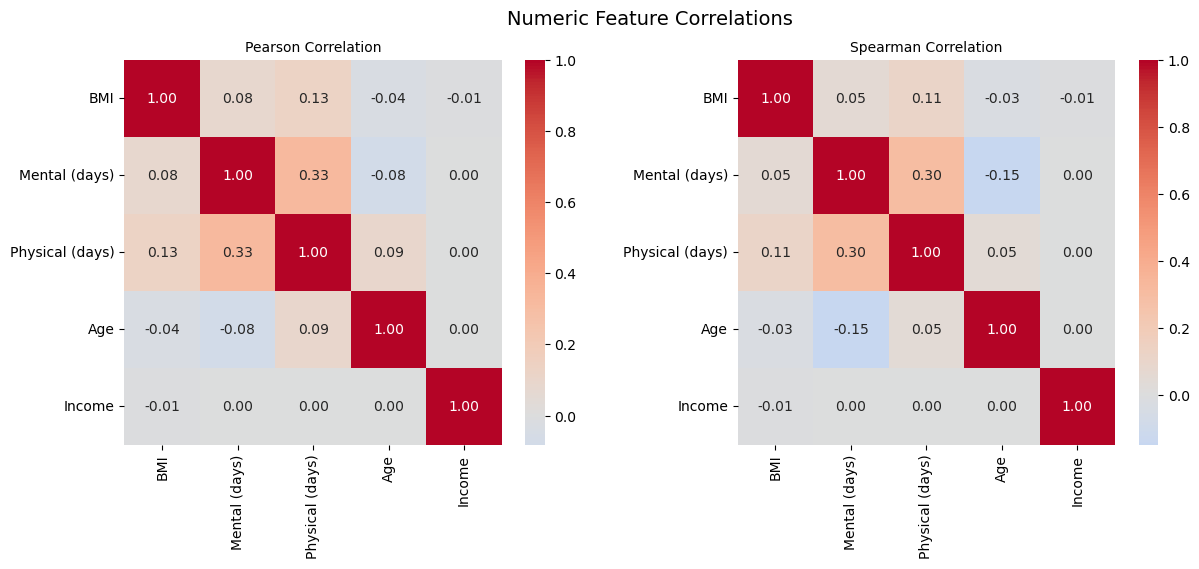

In [452]:
plot_numeric_correlations(X, numeric_features=numeric_features)

最大相关系数（绝对值）为 0.33，可以得出连续特征之间冗余性低，几乎不存在高度重复信息。

### 3.3.2 离散型 vs 离散型
- **潜在问题**：两个分类变量分布高度依赖，携带的判别信息几乎相同。
- **检测方法**：**Cramér’s V**：基于卡方统计，量化两个分类变量的对称性相关性。
- **判定依据**：Cramér’s V ≈ 1 → 两个变量几乎完全依赖。

定义了
- Cramér’s V 计算工具 ``cramers_v(x, y)``
- 以及对 Cramér’s V 结果对可视化工具 ``plot_cramers_v(X: pd.DataFrame, categorical_features: list = None, per_feature_size=0.5, nunique_threshold=20,suptitle: str = "Cramér’s V Correlations (Categorical Features)")``

In [453]:
def cramers_v(x: pd.Series, y: pd.Series) -> float:
    """
    计算 Cramér's V，用于衡量两个类别型变量的相关性。

    参数:
    ----
    x, y : pd.Series
        输入的两个类别型变量

    返回:
    ----
    float
        Cramér's V 值，范围在 [0, 1]
    """
    # 1. 构建列联表（交叉频数表）
    contingency_table = pd.crosstab(x, y)

    # 2. 计算卡方统计量
    chi2, _, _, _ = chi2_contingency(contingency_table)

    # 3. 总样本数
    n_samples = contingency_table.values.sum()

    # 4. 行数和列数
    n_rows, n_cols = contingency_table.shape

    # 5. 自由度的最小值
    min_dim = min(n_rows - 1, n_cols - 1)

    # 6. 代入公式（避免除以零）
    if min_dim == 0:
        return 0.0
    return np.sqrt((chi2 / n_samples) / min_dim)

def plot_cramers_v(
    X: pd.DataFrame,
    categorical_features: list = None,
    per_feature_size=0.5,
    nunique_threshold=20,
    suptitle: str = "Cramér’s V Correlations (Categorical Features)",
    show_values: bool = True,
    vmax: float = 1.0
):
    """
    绘制类别型特征的 Cramér's V 相关性热力图。
    自动识别类别型特征：
    - dtype 为 object
    - 或唯一值数量小于 nunique_threshold 的特征

    参数:
    ----
    X : pd.DataFrame
        输入数据集
    categorical_features : list, optional
        类别型特征列表。如果为 None 或空列表，则自动选择符合条件的特征
    per_feature_size : float, default=0.5
        每个特征额外分配的图像尺寸，用于动态调整
    nunique_threshold : int, default=20
        唯一值数量低于该阈值的数值型特征也视为类别型
    suptitle : str, default="Cramér’s V Correlations (Categorical Features)"
        图表统一标题
    show_values : bool, default=True
        是否在热力图上显示数值
    vmax : float, default=1.0
        热力图色条的最大值范围

    返回:
    ----
    None，直接显示热力图
    """
    # 如果用户提供了 categorical_features，先过滤不存在的特征
    if categorical_features:
        valid_features = [col for col in categorical_features if col in X.columns]
        invalid_features = [col for col in categorical_features if col not in X.columns]
        if invalid_features:
            print(f"警告：以下特征在数据中不存在，将被忽略: {invalid_features}")
        categorical_features = valid_features

    # 自动识别类别型特征
    if not categorical_features:
        categorical_features = []
        for col in X.columns:
            nunique = X[col].nunique()
            if X[col].dtype == 'object' or nunique < nunique_threshold:
                categorical_features.append(col)
        if not categorical_features:
            raise ValueError("数据集中没有符合条件的类别型特征。")

    n_features = len(categorical_features)

    # 动态调整图像大小
    width = max(8, n_features * per_feature_size)
    height = max(6, n_features * per_feature_size)

    # 构建 Cramér's V 矩阵
    cramers_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features, dtype=float)
    for col1 in categorical_features:
        for col2 in categorical_features:
            cramers_matrix.loc[col1, col2] = cramers_v(X[col1], X[col2])

    # 绘制热力图
    fig, ax = plt.subplots(figsize=(width, height))
    sns.heatmap(
        cramers_matrix.astype(float),
        annot=show_values,
        fmt=".2f" if show_values else "",
        cmap="Reds",
        vmin=0,
        vmax=vmax,
        cbar_kws={'label': "Cramér's V"},
        ax=ax
    )
    ax.set_title("Cramér’s V Matrix", fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    fig.suptitle(suptitle, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

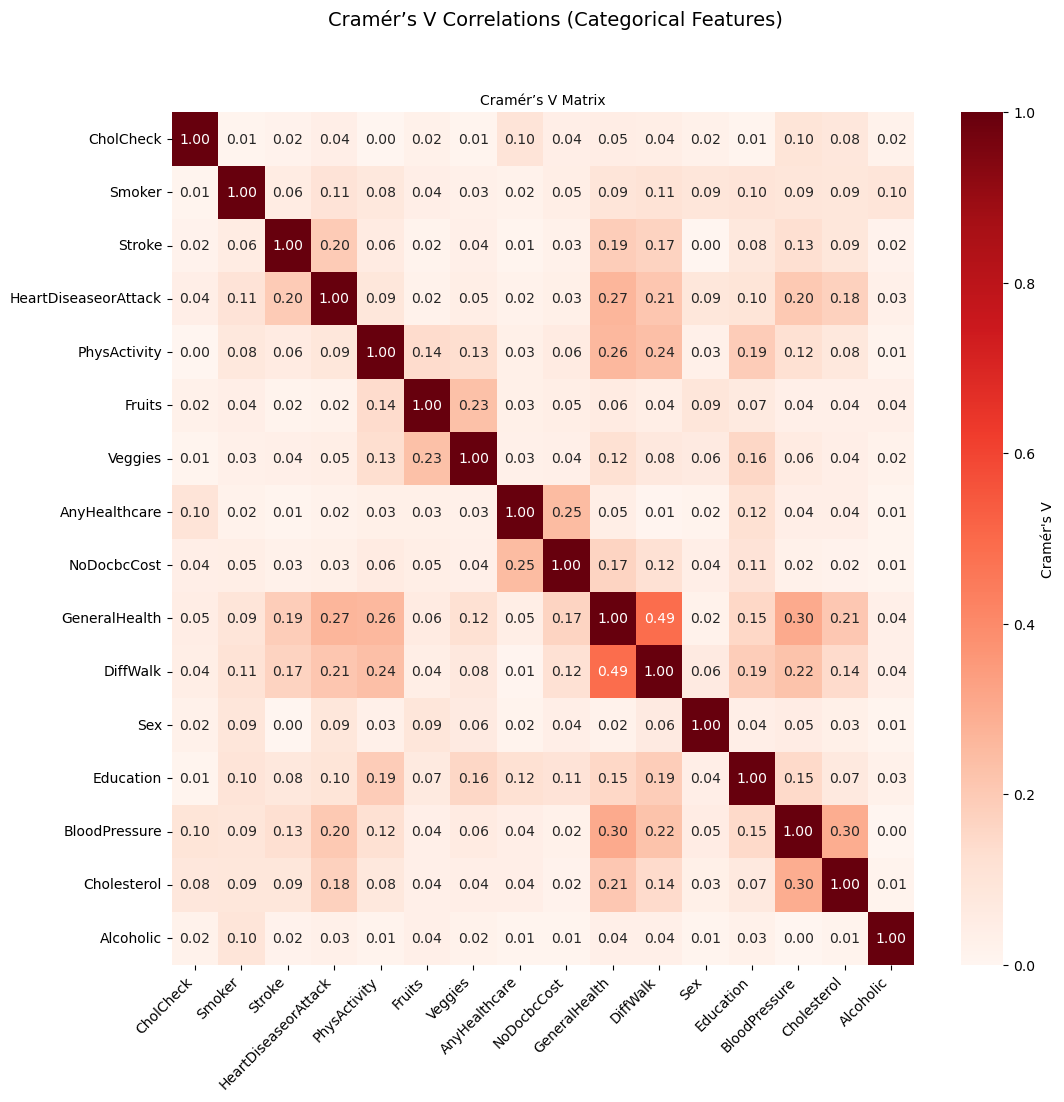

In [454]:
plot_cramers_v(X, categorical_features=categorical_features, per_feature_size=0.7)

最大值为 0.49，对应特征 DiffWalk 与 GeneralHealth，意味着这两个离散特征之间存在一定的信息重叠，DiffWalk 对 GeneralHealth 的分布有一定预测能力，这对特征可能存在部分冗余，可以在后续特征选择或降维时重点关注

### 3.2.3 连续型 vs 离散型
- **潜在问题**：某些连续变量和分类变量之间存在替代关系（redundancy），即分类变量几乎能完全解释连续变量的差异。这种冗余可能导致模型复杂度增加、共线性问题、过拟合风险，同时降低模型解释性。
- **检测方法**：通过 **方差分析 (ANOVA)** 检验连续变量在不同分类水平间是否存在显著差异。ANOVA 的 F 值衡量组间方差与组内方差的比值
- **判断依据**：
  - **F 值大且 p 值显著** → 连续变量在分类水平间差异显著，说明该连续变量部分信息可由分类变量解释（存在冗余）。
  - **F 值小或 p 值不显著** → 连续变量差异不明显，说明其信息独立。

In [455]:
def compute_anova_pair(X: pd.DataFrame, numeric_col: str, categorical_col: str) -> dict:
    """
    计算单个数值特征与单个分类特征的 ANOVA F 检验结果，并返回 η²。
    """
    valid_idx = X[[categorical_col, numeric_col]].dropna().index
    if len(valid_idx) < 2:
        return {"DiscreteFeature": categorical_col, "NumericFeature": numeric_col,
                "F": np.nan, "p": np.nan, "eta2": 0.0}

    X_valid = X.loc[valid_idx, numeric_col].values.reshape(-1, 1)
    y_valid = X.loc[valid_idx, categorical_col].factorize()[0]

    if len(np.unique(y_valid)) < 2:
        return {"DiscreteFeature": categorical_col, "NumericFeature": numeric_col,
                "F": np.nan, "p": np.nan, "eta2": 0.0}

    f_score, p_val = f_classif(X_valid, y_valid)

    # η² = SS_between / SS_total，可用 F 转换近似计算
    n = len(y_valid)
    k = len(np.unique(y_valid))
    eta2 = (f_score[0] * (k - 1)) / (f_score[0] * (k - 1) + (n - k))

    return {"DiscreteFeature": categorical_col, "NumericFeature": numeric_col,
            "F": float(f_score[0]), "p": float(p_val[0]), "eta2": float(eta2)}

def plot_anova_heatmap(X: pd.DataFrame, numeric_features: list, categorical_features: list,
                       figsize: tuple = (10, 6),
                       suptitle: str = "ANOVA F-values: Continuous vs Discrete Features\n(Stars indicate p-value significance)"):
    """
    批量计算数值型特征与分类特征的 ANOVA F 检验，并绘制热力图（复用 compute_anova_pair）。
    """
    results = []

    for cat_col in categorical_features:
        for num_col in numeric_features:
            res = compute_anova_pair(X, numeric_col=num_col, categorical_col=cat_col)
            results.append(res)

    anova_df = pd.DataFrame(results)

    # 构建热力图数据
    heatmap_F = anova_df.pivot(index="DiscreteFeature", columns="NumericFeature", values="F")
    heatmap_p = anova_df.pivot(index="DiscreteFeature", columns="NumericFeature", values="p")

    # 构建标注（F 值 + 显著性星号）
    annot_labels = heatmap_F.copy().astype(str)
    for i in range(heatmap_F.shape[0]):
        for j in range(heatmap_F.shape[1]):
            f_val = heatmap_F.iloc[i, j]
            p_val = heatmap_p.iloc[i, j]
            if pd.isna(f_val) or pd.isna(p_val):
                annot_labels.iloc[i, j] = "NaN"
                continue
            stars = ""
            if p_val < 0.001:
                stars = "***"
            elif p_val < 0.01:
                stars = "**"
            elif p_val < 0.05:
                stars = "*"
            annot_labels.iloc[i, j] = f"{f_val:.2f}{stars}"

    # 绘图
    plt.figure(figsize=figsize)
    sns.heatmap(
        heatmap_F,
        annot=annot_labels,
        fmt="",
        cmap="Reds",
        cbar_kws={'label': 'ANOVA F value'}
    )
    plt.title(suptitle, fontsize=14)
    plt.ylabel("Discrete Features")
    plt.xlabel("Continuous Features")
    plt.tight_layout()
    plt.show()

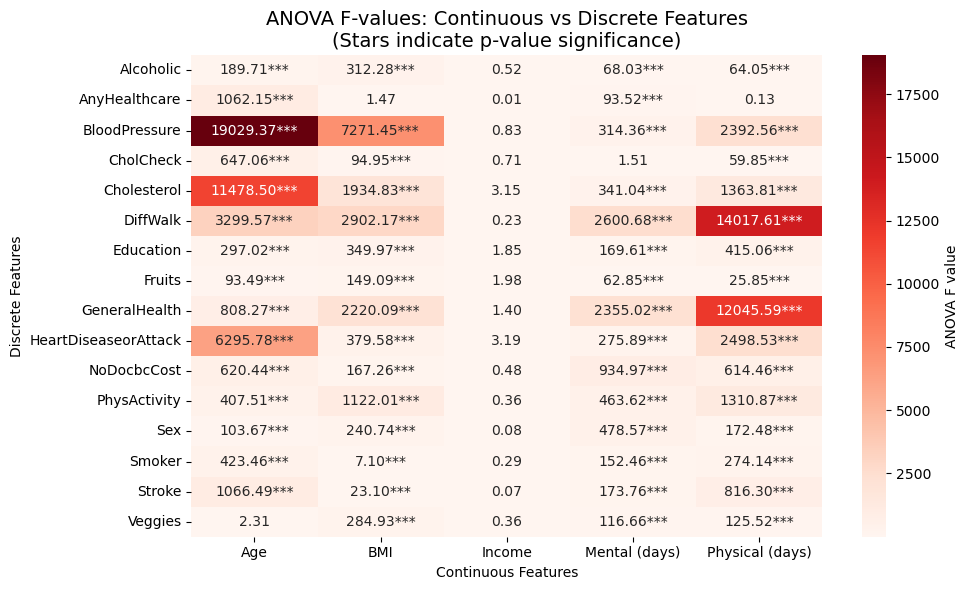

In [456]:
plot_anova_heatmap(df, numeric_features, categorical_features)

Income 几乎无法被分类变量预测，显示其信息高度独立，而 BMI、Age、Physical (days) 等连续变量在多数分类特征下 F 值显著偏高，说明它们部分信息可以被分类变量间接解释。因此，在下一步进行多特征共同作用分析时，应考虑这些连续变量可能与其他特征存在互补或替代作用。

### 3.3.4 多特征共同作用
- **潜在问题**：某个特征可能不是与单一变量相关，而是能被多个特征线性或非线性组合近似重建。
- **检测方法**：**线性回归替代性 (R²)**：用其他所有特征回归预测该变量，若 R² 高，则冗余度高。
- **推断依据**：R² ≈ 1：该特征几乎完全由其他特征线性组合得到，可视为冗余。

In [457]:
def compute_r2(X_input: pd.DataFrame, y_target: pd.Series) -> float:
    """
    使用线性回归预测 y_target，计算 R²。

    参数:
    ----
    X_input : pd.DataFrame
        自变量特征
    y_target : pd.Series
        目标特征

    返回:
    ----
    float : R² 决定系数
    """
    model = LinearRegression()
    model.fit(X_input, y_target)
    preds = model.predict(X_input)
    return r2_score(y_target, preds)

def compute_feature_redundancy(
    X: pd.DataFrame, 
    numeric_features: list, 
    categorical_features: list
) -> dict:
    """
    计算每个特征的冗余度（R²）并打印整齐表格。

    参数:
    ----
    X : pd.DataFrame
        完整特征数据集
    numeric_features : list
        连续型特征列表
    categorical_features : list
        分类特征列表（已映射为数值）

    返回:
    ----
    dict : {feature_name: R²}
    """
    redundancy_scores = {}

    for target_col in X.columns:
        # 删除目标列缺失的行
        mask = X[target_col].notna()
        X_subset = X.loc[mask].copy()

        y = X_subset[target_col]
        others = X_subset.drop(columns=[target_col])

        # 连续特征填充中位数
        for col in numeric_features:
            if col != target_col:
                others[col] = others[col].fillna(others[col].median())

        # 分类特征填充众数
        for col in categorical_features:
            if col != target_col:
                others[col] = others[col].fillna(others[col].mode()[0])

        # 调用 compute_r2 计算 R²
        redundancy_scores[target_col] = compute_r2(others, y)

    # 输出表格
    table = [(feat, f"{score:.3f}") for feat, score in redundancy_scores.items()]
    print(tabulate(table, headers=["Feature", "R²"], tablefmt="grid"))

In [458]:
compute_feature_redundancy(X, numeric_features, categorical_features)

+----------------------+-------+
| Feature              |    R² |
+======================+=======+
| CholCheck            | 0.018 |
+----------------------+-------+
| BMI                  | 0.095 |
+----------------------+-------+
| Smoker               | 0.003 |
+----------------------+-------+
| Stroke               | 0.055 |
+----------------------+-------+
| HeartDiseaseorAttack | 0.107 |
+----------------------+-------+
| PhysActivity         | 0.084 |
+----------------------+-------+
| Fruits               | 0.002 |
+----------------------+-------+
| Veggies              | 0.03  |
+----------------------+-------+
| AnyHealthcare        | 0.041 |
+----------------------+-------+
| NoDocbcCost          | 0.064 |
+----------------------+-------+
| GeneralHealth        | 0.289 |
+----------------------+-------+
| Mental (days)        | 0.1   |
+----------------------+-------+
| Physical (days)      | 0.263 |
+----------------------+-------+
| DiffWalk             | 0.233 |
+---------

Income 的 R² 为 0，说明它几乎完全不可被其他特征线性组合预测，信息独立性极高，属于不可替代特征，保留必要。

BMI、Age、Physical (days) 等连续变量虽然在单特征 ANOVA 检验中显示部分信息可以被分类变量解释，但在多特征线性回归替代性检验中，它们的 R² 分别为 0.095（BMI）、0.166（Age）、0.263（Physical (days)）等，均远小于 1。这说明即便考虑了其他所有特征的线性组合，这些连续变量仍然保留大部分独立信息，不能被完全重建，因此不构成可删除的冗余。

类似地，GeneralHealth（R² = 0.289）、DiffWalk（R² = 0.233）、BloodPressure（R² = 0.198）、Mental (days)（R² = 0.1）等特征的 R² 也均显著低于 1，说明它们虽然可能与其他特征存在一定相关性，但仍提供独立信息。其他绝大多数特征 R² 远小于 0.3，冗余度极低。

综上，多特征线性替代性检验显示当前特征集不存在完全可被删除的冗余特征。每个特征都保留了足够独立的信息贡献，可以继续在后续建模中保留。

## 3.4 缺失值处理

由于数据缺失比较严重，所以我们要进行缺失模式的判断，以决定后续的缺失值处理策略。

### 3.4.1 缺失模式判定

下面几个方面进行判断是为了**从直观、建模、依赖性和统计显著性多角度验证缺失机制**，确保对缺失类型的判断科学可靠：

- **直观可视方法**：通过缺失矩阵可视化可观察缺失值在样本和特征维度上是否随机分布，若未出现成块聚集或规律性则支持MCAR。这一方法直观、快速，可初步排除明显的结构性缺失。

- **建模检验法**：通过回归法检测时以缺失指示变量为因变量做线性回归，若模型R²接近0且MSE接近基准误差则说明缺失与其他特征无关，符合MCAR。此方法量化了缺失与其他变量的线性关系，提供统计依据。

- **缺失间依赖性检验**：通过缺失模式相关性矩阵计算特征间缺失的相关性，若矩阵接近对角阵且无显著相关性则表明缺失事件独立，符合MCAR。这可以判断不同特征缺失是否相互依赖，进一步支持MCAR假设。

- **统计显著性检验**：通过Little’s MCAR test，对整体缺失模式进行假设检验。若 P 值 > 0.05，则无法拒绝 MCAR 假设，表明缺失可能是完全随机的。这提供了正式的统计显著性证据。

#### （1）缺失矩阵

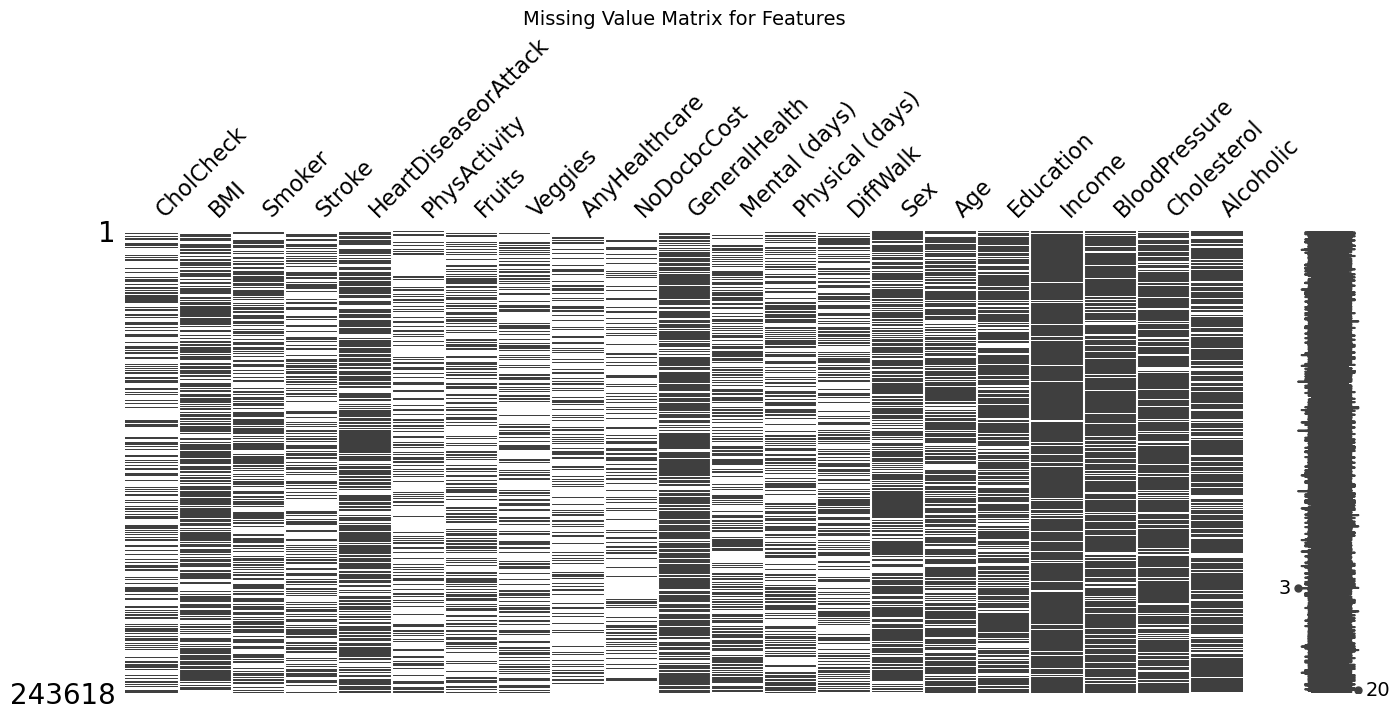

In [459]:
msno.matrix(X, figsize=(16, 6), sparkline=True)
plt.title("Missing Value Matrix for Features", fontsize=14)
plt.show()

在缺失矩阵可视化中没有明显的聚集或与其他特征成块的缺失模式，缺失点散布随机，无法从其他特征推测其位置。

#### （2）回归法检测

In [460]:
def linear_regression_test(X_input: pd.DataFrame, y_target: pd.Series, test_size: float = 0.2, random_state: int = 0) -> dict:
    """
    核心回归函数：输入 X, y，输出 R², MSE, Baseline_MSE
    
    参数:
    ----
    X_input : pd.DataFrame
        自变量
    y_target : pd.Series
        因变量（缺失指示变量）
    test_size : float
        测试集比例
    random_state : int
        随机种子
    
    返回:
    ----
    dict : {'R²', 'MSE', 'Baseline_MSE', 'MSE-Baseline_MSE'}
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X_input, y_target, test_size=test_size, random_state=random_state
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = abs(r2_score(y_test, y_pred))  # 取绝对值
    mse = mean_squared_error(y_test, y_pred)
    baseline_pred = np.full_like(y_test, y_test.mean(), dtype=float)
    baseline_mse = mean_squared_error(y_test, baseline_pred)
    
    return {
        "R²": r2,
        "MSE": mse,
        "Baseline_MSE": baseline_mse,
        "MSE-Baseline_MSE": mse - baseline_mse
    }

def missingness_model_check(
    X: pd.DataFrame,
    test_size: float = 0.2,
    random_state: int = 0,
    print_table: bool = False
) -> pd.DataFrame:
    """
    对每个特征的缺失模式进行建模检验（MCAR）。
    
    参数:
    ----
    X : pd.DataFrame
        原始特征集
    test_size : float
        测试集比例
    random_state : int
        随机种子
    print_table : bool
        是否打印结果表格
    
    返回:
    ----
    pd.DataFrame : 各特征缺失建模检验结果
    """
    missing_indicators = X.isnull().astype(int)
    results = []
    
    for col in X.columns:
        y = missing_indicators[col]
        X_others = X.drop(columns=[col]).copy()
        X_others = X_others.fillna(X_others.median())
        
        res = linear_regression_test(X_others, y, test_size=test_size, random_state=random_state)
        res["Variable"] = col
        results.append(res)
    
    result_df = pd.DataFrame(results)[["Variable", "R²", "MSE", "Baseline_MSE", "MSE-Baseline_MSE"]]
    
    if print_table:
        print(tabulate(result_df, headers="keys", tablefmt="grid", showindex=False))
    
    return result_df

def plot_missingness_model_check(
    X: pd.DataFrame,
    figsize=(12,6),
    title: str = "Missingness Modeling Results",
    test_size: float = 0.2,
    random_state: int = 0
):
    """
    可视化缺失模式建模检验结果。
    按 R² 升序排序，柱状图蓝色，折线红色，凸显 MSE 与 Baseline MSE 接近情况。
    
    参数:
    ----
    X : pd.DataFrame
        原始特征集
    figsize : tuple, optional
        图形大小
    title : str, optional
        图形标题
    test_size : float, optional
        测试集比例
    random_state : int, optional
        随机种子
    """
    # 获取缺失模式检验结果
    result_df = missingness_model_check(X, test_size=test_size, random_state=random_state, print_table=False)

    # 按 R² 升序排序
    result_df = result_df.sort_values(by="R²", ascending=True).reset_index(drop=True)

    fig, ax1 = plt.subplots(figsize=figsize)
    x = np.arange(len(result_df))
    width = 0.4

    # 左轴：MSE 与 Baseline_MSE
    ax1.plot(x, result_df["MSE"], marker='o', linestyle='-', color='tab:red', label='MSE', alpha=0.8)
    ax1.plot(x, result_df["Baseline_MSE"], marker='s', linestyle='--', color='tab:red', label='Baseline MSE', alpha=0.5)
    
    # 使用阴影填充凸显 MSE 与 Baseline 差异
    ax1.fill_between(x, result_df["MSE"], result_df["Baseline_MSE"], color='tab:red', alpha=0.1)
    
    ax1.set_ylabel("MSE", color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # x 轴设置
    ax1.set_xticks(x)
    ax1.set_xticklabels(result_df["Variable"], rotation=45, ha='right')

    # 右轴：R²
    ax2 = ax1.twinx()
    ax2.bar(x, result_df["R²"], width=width, color='tab:blue', alpha=0.6, label='R²')
    ax2.set_ylabel("R²", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # 图例
    lines, labels = ax1.get_legend_handles_labels()
    bars, bar_labels = ax2.get_legend_handles_labels()
    ax1.legend(lines + bars, labels + bar_labels, loc='upper right', fontsize=9)

    # 标题
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

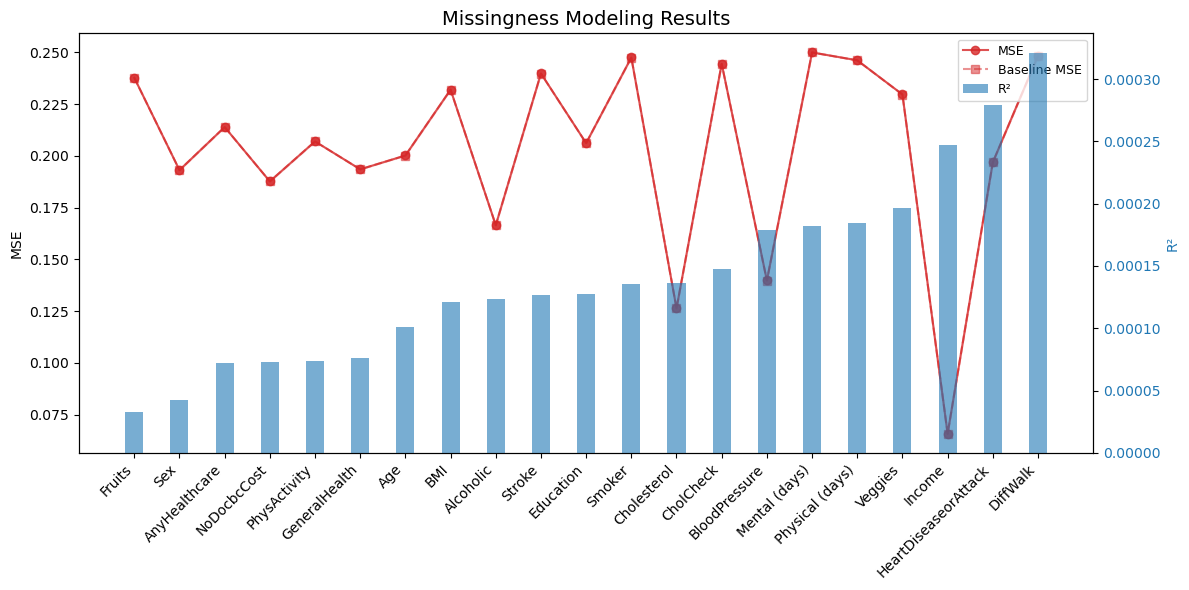

In [461]:
plot_missingness_model_check(X)

从结果来看，所有特征的 R² 值都非常接近零，说明用其他特征线性预测某个特征的缺失指示变量几乎没有解释力，缺失与其他特征没有相关性。
MSE 与 Baseline_MSE 非常接近，差值微乎其微，说明利用其他特征预测缺失并不能显著降低误差，进一步证明缺失模式高度随机。
这表明数据集缺失模式符合 MCAR 假设。

#### （3）相关性矩阵

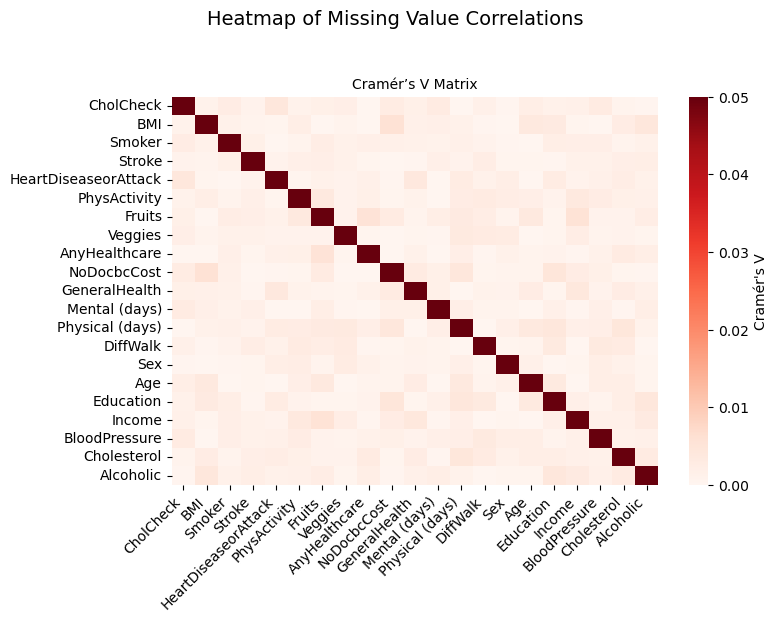

In [462]:
missing_matrix = X.isnull().astype(int)
plot_cramers_v(missing_matrix, per_feature_size=0.3,suptitle='Heatmap of Missing Value Correlations',show_values=False,vmax=0.05)

#### （5） Little's MCAR Test Result

In [463]:
def little_mcar_test(data: pd.DataFrame, alpha: float = 0.05):
    """
    简化版 Little's MCAR 检验，用于判断数据缺失是否符合 MCAR 假设。
    直接以 tabulate 风格打印结果，不返回。
    
    参数:
    ----
    data : pd.DataFrame
        输入数据集
    alpha : float, default=0.05
        显著性水平，用于判断是否拒绝 MCAR 假设
    """
    # 缺失模式矩阵 (1=缺失, 0=非缺失)
    missing_matrix = data.isnull().astype(int)
    # 缺失模式相关性矩阵
    corr_matrix = missing_matrix.corr()
    # 差异矩阵
    diff_matrix = corr_matrix - np.mean(corr_matrix.values)

    # 统计量
    chi2_stat = np.sum(diff_matrix.values ** 2)
    # 自由度
    dfree = data.shape[1] * (data.shape[1] - 1) / 2
    # p 值
    p_value = 1 - chi2_dist.cdf(chi2_stat, dfree)

    # 结论
    conclusion = (
        "P > α, 无法拒绝 MCAR 假设，数据可能为 MCAR"
        if p_value > alpha
        else "P <= α, 拒绝 MCAR 假设，数据可能不是 MCAR"
    )
    # 构造结果表
    result_table = [
        ["Chi-Square Statistic", f"{chi2_stat:.4f}"],
        ["Degrees of Freedom", f"{int(dfree)}"],
        ["P-Value", f"{p_value:.4f}"],
        ["Conclusion", conclusion]
    ]
    # 打印表格
    print(tabulate(result_table, headers=["Metric", "Value"], tablefmt="grid"))

In [464]:
little_mcar_test(X)

+----------------------+--------------------------------------------+
| Metric               | Value                                      |
+======================+============================================+
| Chi-Square Statistic | 20.0168                                    |
+----------------------+--------------------------------------------+
| Degrees of Freedom   | 210                                        |
+----------------------+--------------------------------------------+
| P-Value              | 1.0000                                     |
+----------------------+--------------------------------------------+
| Conclusion           | P > α, 无法拒绝 MCAR 假设，数据可能为 MCAR |
+----------------------+--------------------------------------------+


### 3.4.2 缺失值处理方案制定  

在制定缺失值处理策略时，首先依据缺失率对特征进行分层。缺失率过高的特征通常直接删除；缺失率较低的特征则通过简单插补保留；而处于中间区间的特征，需要结合其预测价值与重要性进行综合判断。  

**缺失率分层参考标准**  

- **缺失率 < 20%**：特征信息损失较少，可直接采用均值或中位数插补，避免删除特征。  
- **缺失率 20%–50%**：缺失较为显著，建议采用多重插补方法（MICE）以提高数据质量。  
- **缺失率 > 50%**：若该特征对预测模型具有显著价值，可采用 MICE 插补；若价值有限，则建议直接删除。  

#### （1）缺失率分层

In [465]:
def categorize_features_by_missingness(X: pd.DataFrame):
    # 计算缺失率
    missing_ratio = X.isnull().mean()

    # 分类
    high_missing = missing_ratio[missing_ratio > 0.50].index.tolist()
    medium_missing = missing_ratio[(missing_ratio >= 0.20) & (missing_ratio <= 0.50)].index.tolist()
    low_missing = missing_ratio[missing_ratio < 0.20].index.tolist()

    categorized_missingness = {
        "high_missing(>50%)": high_missing,
        "medium_missing(20%-50%)": medium_missing,
        "low_missing(<20%)": low_missing
    }

    # 打印表格
    print(tabulate(categorized_missingness.items(),
                   headers=['Category', 'Features'],
                   tablefmt='grid',
                   stralign='center'))

    return categorized_missingness

In [466]:
categorized = categorize_features_by_missingness(X)

+-------------------------+----------------------------------------------------------------------------------------------------------------------------------------------+
|        Category         |                                                                   Features                                                                   |
+=========================+==============================================================================================================================================+
|   high_missing(>50%)    | ['CholCheck', 'Stroke', 'PhysActivity', 'Fruits', 'Veggies', 'AnyHealthcare', 'NoDocbcCost', 'Mental (days)', 'Physical (days)', 'DiffWalk'] |
+-------------------------+----------------------------------------------------------------------------------------------------------------------------------------------+
| medium_missing(20%-50%) |                      ['BMI', 'Smoker', 'HeartDiseaseorAttack', 'GeneralHealth', 'Sex', 'Age', 'Education', 'Alcoholic

在本研究数据中，缺失率超过 50% 的特征数量较多，若完全依赖经验阈值直接删除，可能会丢失潜在的高价值信息。因此，将缺失率 **20%–50% 与 >50% 的特征统一合并为“中高缺失特征”**，再进一步分析，决定保留或删除。

In [467]:
mid_high_missing = categorized["high_missing(>50%)"] + categorized["medium_missing(20%-50%)"]
print("\n中高缺失特征：", mid_high_missing)

X_mid_high_missing = X[mid_high_missing]   


中高缺失特征： ['CholCheck', 'Stroke', 'PhysActivity', 'Fruits', 'Veggies', 'AnyHealthcare', 'NoDocbcCost', 'Mental (days)', 'Physical (days)', 'DiffWalk', 'BMI', 'Smoker', 'HeartDiseaseorAttack', 'GeneralHealth', 'Sex', 'Age', 'Education', 'Alcoholic']


#### （2）中高缺失特征筛选策略制定

对“中高缺失特征”进一步筛选时，既要量化特征对目标的预测价值（信息），又要量化因缺失导致的信息损失与不确定性，从而在二者之间做出可解释、可复现的权衡。

将“中高缺失特征”的筛选策略形式化为可复现的决策流程，必须在统计度量与领域判断之间建立清晰的桥梁。统计度量既要量化特征对目标的预测价值（信息），又要量化因缺失导致的信息损失与不确定性，从而在二者之间做出可解释、可复现的权衡。但必须明确统计度量本身只是决策的第一道过滤器，而非最终判定，在本数据集样本量充足的情况下，其主要原因是统计度量只能反映关联或方差分解，不能区分因果或测量误差；若某特征是目标因果链的一部分（临床优先级高），即使统计度量结果低也应考虑因其理论重要性而被保留。

#### （3）统计量化

统计量化的核心在于 **Missing–Information Tradeoff** 框架，其本质是对特征缺失率与特征预测能力的平衡。  

- **高预测能力 + 高缺失率**  
特征对目标变量具有较强解释力，但缺失严重 → 可暂保留，建模阶段再进一步评估。  
- **低预测能力 + 高缺失率**  
特征贡献有限且缺失严重 → 建议直接删除以减少噪声。  
- **低预测能力 + 低缺失率**  
特征稳定但预测价值有限 → 视建模需求决定去留。  
- **高预测能力 + 低缺失率**  
理想特征，应优先保留。  

度量层面使用可靠性因子 $(1-MR_j)$ 与有效分类效能 $\mathrm{EffCE}_j$ 合成信息保留指数  
$$
\mathrm{IRI}_j = CE_j\cdot(1-MR_j)^2
$$

下面给出数学定义与解释。

##### a. 缺失率 $MR_j$
对第 $j$ 个特征定义缺失率为
$$
MR_j=\frac{1}{n}\sum_{i=1}^n M_{ij},\qquad M_{ij}=\begin{cases}
1,&\text{第 }i\text{ 个样本在特征 }j\text{ 上缺失},\\
0,&\text{否则}.
\end{cases}
$$

##### b. 分类效能 $CE_j$ 
1. 连续型特征取 ANOVA 的 $\eta^2$：
$$
\eta^2 \;=\; \frac{\mathrm{SS}_{\text{between}}}{\mathrm{SS}_{\text{total}}},
\quad
\mathrm{SS}_{\text{between}}=\sum_{k=1}^K n_k(\bar{x}_k-\bar{x})^2,
\quad
\mathrm{SS}_{\text{total}}=\sum_{i=1}^n (x_i-\bar{x})^2,
$$
其中 $K$ 为类别数（本处 $K=3$），$n_k$ 与 $\bar{x}_k$ 分别为第 $k$ 类的样本数与样本均值，$\bar{x}$ 为总体均值。 $\eta^2$ 表征组间变异占总体变异的比例，可视为连续特征对分类的不确定性减少能力。

2. 离散型特征取 Cramér’s V：
$$
V \;=\; \sqrt{\frac{\chi^2/n}{\min(r-1,k-1)}},
\qquad
\chi^2=\sum_{i=1}^r\sum_{j=1}^k\frac{(O_{ij}-E_{ij})^2}{E_{ij}},
$$
其中 $r$ 为该特征类别数，$k$ 为目标类别数（这里 $k=3$），$O_{ij}$ 与 $E_{ij}$ 分别为观察频数与期望频数。$V\in[0,1]$，数值越大表示与目标依赖越强，可作为离散特征的预测力度量。

综上统一记作
$$
CE_j=\begin{cases}
\eta^2_j,&\text{若特征 }j\ \text{为连续型},\\[4pt]
V_j,&\text{若特征 }j\ \text{为离散型}.
\end{cases}
$$

##### c. 有效分类效能 $\mathrm{EffCE}_j$

样本量减少会降低估计稳定性，因此定义“有效分类效能”：
$$
\mathrm{EffCE}_j = CE_j \cdot (1 - MR_j).
$$

##### d. 可靠性因子 $(1-MR_j)$

有效观测数：
$$
n_{\mathrm{obs},j} = n\cdot(1 - MR_j).
$$

可靠性因子可取与有效样本比例成正比的形式，这里采用线性惩罚 $(1-MR_j)$。

##### e. 保留指数 $IRI$
于是最终的信息保留指数（Information Retention Index，IRI）定义为
$$
\mathrm{IRI}_j \;=\; \mathrm{CE}_j \cdot (1 - MR_j)^2.
$$
该表达式直观地把“原始信息量”（$CE_j$）和“由缺失导致的可用信息比例与置信度惩罚”二者相乘，既反映了特征对目标的解释力，也反映了因缺失带来的可靠性损失。

#### （4）统计量化计算

In [468]:
def compute_iri(X: pd.DataFrame, y: pd.Series, numeric_features: list):
    """
    计算每个特征的 IRI (Information Retention Index)，并以 tabulate 风格输出结果。

    参数:
    ----
    X : pd.DataFrame
        特征矩阵
    y : pd.Series
        目标变量（分类）
    numeric_features : list
        数值型特征列表，其余默认视为分类特征

    返回:
    ----
    pd.DataFrame
        包含每个特征的 CE, MR, IRI 和决策
    """
    results = []

    # 确保 y 是 Series，并设定名称
    if not isinstance(y, pd.Series):
        y = pd.Series(y, name="target")
    elif y.name is None:
        y.name = "target"

    for col in X.columns:
        x = X[col]
        mr = x.isna().mean()  # 缺失率

        if col in numeric_features:   # 数值型特征
            res = compute_anova_pair(pd.concat([X[col], y], axis=1), numeric_col=col, categorical_col=y.name)
            ce = res["eta2"] if res["eta2"] is not None else 0.0
            ftype = "numeric"
        else:   # 类别型特征
            ce = cramers_v(x.astype(str), y.astype(str))
            ftype = "categorical"

        iri = ce * (1 - mr) ** 2

        if iri >= 0.1:
            decision = "Keep"
        elif iri >= 0.02:
            decision = "Review"
        else:
            decision = "Remove"

        results.append({
            "Feature": col,
            "Type": ftype,
            "CE": round(ce, 4),
            "MR": round(mr, 4),
            "IRI": round(iri, 4),
            "Decision": decision
        })

    df = pd.DataFrame(results).sort_values(by="IRI", ascending=False)

    # 直接打印 tabulate 表格
    print(tabulate(df, headers="keys", tablefmt="grid", showindex=False, stralign="center", numalign="center"))

In [469]:
compute_iri(X_mid_high_missing, y, numeric_features)

+----------------------+-------------+--------+--------+--------+------------+
|       Feature        |    Type     |   CE   |   MR   |  IRI   |  Decision  |
+======================+=============+========+========+========+============+
|    GeneralHealth     | categorical | 0.1884 | 0.2601 | 0.1031 |    Keep    |
+----------------------+-------------+--------+--------+--------+------------+
| HeartDiseaseorAttack | categorical | 0.1061 | 0.2704 | 0.0565 |   Review   |
+----------------------+-------------+--------+--------+--------+------------+
|      Education       | categorical | 0.081  | 0.2899 | 0.0408 |   Review   |
+----------------------+-------------+--------+--------+--------+------------+
|         BMI          |   numeric   | 0.0603 | 0.3653 | 0.0243 |   Review   |
+----------------------+-------------+--------+--------+--------+------------+
|      Alcoholic       | categorical | 0.0358 |  0.21  | 0.0223 |   Review   |
+----------------------+-------------+--------+-----

结果表明：
- 强信号少：只有 GeneralHealth 达到 Keep 阈值，说明大部分特征对目标变量解释力有限。
- 缺失率影响很大：像 DiffWalk CE 还可以 (0.1048)，但缺失率 > 54%，直接导致 IRI 掉到 Review 边缘。
- 健康行为变量整体较弱：PhysActivity, Veggies, Fruits, Smoker 等生活方式变量 CE 和 IRI 都低，说明它们在该任务中的解释力不足，可能因为目标变量与这些因素关系较弱或因问卷噪声影响。
- 社会经济变量不突出：Education 在 CE 上略高，但缺失率接近 30%，导致 IRI 偏低。

#### （5）领域判断
领域判断结合变量在理论上的相关性，以保证模型的稳健性与医学可解释性。我们按照如下方面进行综合评估：

| 变量                 | 因果角色                               | 相关方式                           | 类型与信息量       | 理论强度 | 建议                   |
|----------------------|--------------------------------------|----------------------------------|-------------------|----------|------------------------|
| GeneralHealth        | 上游危险因素/健康状态总评             | 直接                               | 分类/主观评价      | 高       | 保留，核心预测变量     |
| BMI                  | 上游危险因素/肥胖指标                  | 直接                               | 连续              | 高       | 保留，预测与调控因子   |
| Age                  | 上游危险因素/时间变量                  | 直接                               | 连续              | 高       | 保留，人口学关键因子   |
| Sex                  | 上游危险因素/生物学基础                | 直接                               | 二值              | 高       | 保留，人口学关键因子   |
| HeartDiseaseorAttack | 下游并发症/心血管疾病                 | 间接                               | 二值              | 中高     | 保留，可作为复审特征   |
| Stroke               | 下游并发症/心脑血管事件                | 间接                               | 二值              | 中高     | 保留，可作为复审特征   |
| DiffWalk             | 功能受限/慢病影响                       | 间接                               | 二值              | 中高     | 保留，反映功能状态     |
| Education            | 社会经济地位（SES）/健康行为调控因素   | 间接                               | 有序分级          | 中       | 保留，混杂控制有用     |
| Physical (days)      | 健康行为/运动频率                       | 间接                               | 连续              | 中       | 保留，生活方式因子     |
| Smoker               | 健康行为/生活方式                      | 直接                               | 二值              | 中       | 保留，生活方式因子     |
| Alcoholic            | 健康行为/生活方式                      | 间接                               | 二值              | 中低     | 保留，可复审           |
| PhysActivity         | 健康行为/运动频率                       | 间接                               | 二值              | 中低     | 保留，信息有限         |
| Veggies              | 健康饮食行为                             | 间接                               | 二值              | 中低     | 保留，信息有限         |
| Fruits               | 健康饮食行为                             | 间接                               | 二值              | 中低     | 保留，信息有限         |
| Mental (days)        | 健康状况/心理压力                         | 间接                               | 连续              | 中低     | 保留，可能有辅助价值   |
| CholCheck            | 医疗行为/可及性                         | 间接                               | 二值              | 低       | 删除，偏倚风险大       |
| NoDocbcCost          | 医疗可及性/经济障碍                       | 间接                               | 二值              | 低       | 删除，SES已涵盖信息    |
| AnyHealthcare        | 医疗行为/可及性                           | 间接                               | 二值              | 低       | 删除，偏倚风险大       |

- 高：生物学和核心风险因素（GeneralHealth, BMI, Age, Sex）
- 中高：糖尿病主要并发症和功能限制（HeartDiseaseorAttack, Stroke, DiffWalk）
- 中：社会经济、生活方式核心因素（Education, Physical (days), Smoker）
- 中低：补充性生活方式和心理特征（Alcoholic, PhysActivity, Veggies, Fruits, Mental (days)）
- 低：医疗可及性相关（CholCheck, NoDocbcCost, AnyHealthcare），更可能引入偏倚而非真实风险

#### （6）中高缺失特征特征筛选策略

最终特征选择原则：在特征筛选过程中，我们同时参考了
1.	统计量化结果（IRI 指标与缺失率分析），以及
2.	理论领域判断（因果角色、相关机制、信息含量与潜在偏倚）。

综合两方面证据后，CholCheck、NoDocbcCost、AnyHealthcare 这三个变量在 统计意义和理论解释 上均显示为信息有限或存在偏倚风险，因此我们将其从特征集中剔除。

### 3.4.3 删除特征


In [583]:
def drop_features_and_save(df, drop_cols, output_path, plot_title="Missing Overview After Feature Drop", plot=True):
    """
    删除指定特征并保存清理后的数据，可选绘制缺失值统计图。

    参数:
    ----
    df : pd.DataFrame
        输入的数据集
    drop_cols : list
        要删除的特征名列表
    output_path : str
        保存路径（包括文件名），如 'diabetes/[Step3:FeatureDrop]diabetes_diagnosis.csv'
    plot_title : str
        缺失值统计图的标题，默认 "Missing Overview After Feature Drop"
    plot : bool, default False
        是否绘制缺失值统计图

    返回:
    ----
    df : pd.DataFrame
        删除指定特征后的数据集
    """
    import os

    # 删除列
    df = df.drop(columns=drop_cols, errors="ignore")

    # 打印结果
    print("剩余特征:")
    print(df.columns.tolist())
    print(f"数据维度: {df.shape}")

    # 可视化缺失情况
    if plot:
        plot_missing_statistics(df, title=plot_title)

    # 保存结果
    dir_name = os.path.dirname(output_path)
    if dir_name:  # 只有在有目录时才创建
        os.makedirs(dir_name, exist_ok=True)

    df.to_csv(output_path, index=False, encoding="utf-8-sig")
    print(f"数据已保存至: {os.path.abspath(output_path)}")

    return df

剩余特征:
['BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'GeneralHealth', 'Mental (days)', 'Physical (days)', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'Diabetes', 'BloodPressure', 'Cholesterol', 'Alcoholic']
数据维度: (243618, 19)


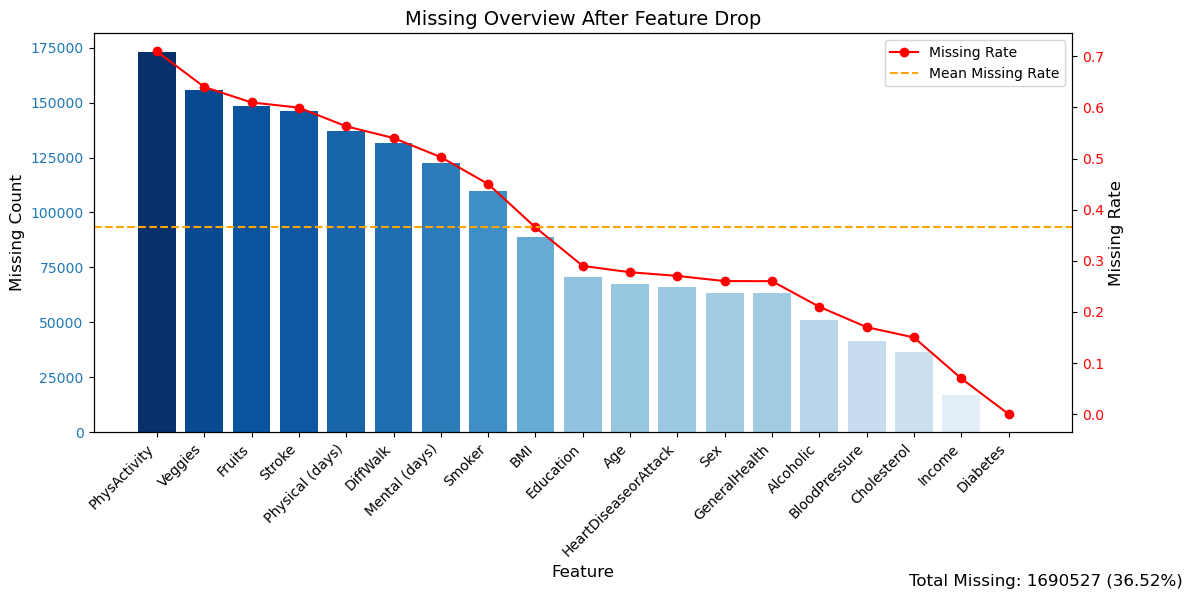

数据已保存至: /Users/guocy/Projects/5310_a1/diabetes/[Step3:FeatureDrop]diabetes_diagnosis.csv


In [471]:
drop_cols = ["CholCheck", "NoDocbcCost", "AnyHealthcare"]
drop_features_and_save(df, drop_cols, '[Step3:FeatureDrop]diabetes_diagnosis.csv', plot_title="Missing Overview After Feature Drop")

### 3.4.4 插补策略

#### （1）插补策略制定

缺失值的处理方法直接决定了数据质量与后续模型的可靠性。常见的基础方法包括：

- **单值插补（Single Imputation）**：如均值/中位数插补，简单易行，但会系统性低估方差，破坏变量间的相关结构。  
- **前向/后向填充（Forward/Backward Fill）**：适合时间序列，但不适合本研究的横断面调查数据。  
- **删除法（Listwise Deletion）**：当缺失完全随机（MCAR）时无偏，但会显著降低样本量，导致统计功效下降。  

因此，本研究不采用以上方法作为主要方案。  

在本研究背景下，存在以下限制条件：  
1. **不能使用预测模型进行插补** —— 避免引入目标变量泄漏或将预测模型“嵌入”到预处理流程，导致偏倚和过拟合。  
2. **变量多为横断面调查类健康特征** —— 缺失机制可能与个体健康行为或调查问卷特征相关，不能简单假设 MCAR。  
3. **需要兼顾数据保真与方差合理性** —— 要求在保留数据分布特征的同时，尽量维持不同变量间的相关结构。  


综合考虑后，制定如下多重插补方案：

1. **均值/中位数插补（Mean/Median Imputation）**  
   - 作为基准方法，用于与更复杂方法对比。  
   - 仅适用于缺失率较低的变量，可快速得到平滑的补齐数据。  
   - 缺点是无法反映真实的方差，因此不作为最终结果的唯一依据。  

2. **随机抽样插补（Random Sampling Imputation）**  
   - 对于缺失值，从观测到的分布中随机抽样补齐。  
   - 保持原始分布特性，避免均值/中位数方法导致的方差缩减。  
   - 特别适合调查类变量（如 BMI、连续健康行为指标）。  

3. **确定性回归插补（Deterministic Regression Imputation）**  
   - 与 MICE 类似，但不加入随机性。  
   - 能保证结果的稳定性，便于方法学比较。  
   - 适合作为稳健性检查，与随机性版本进行对照。  

最终将形成多个插补版本数据集。

#### （2）插补后截断策略

即使采用多重插补方法，也不可避免会引入偏离原始分布的极端值（outliers）。  
如果这些异常值未经处理，可能在后续建模阶段造成严重影响，例如导致参数估计偏差、模型收敛困难、预测性能下降。  

为保证插补数据的合理性与临床可解释性，本研究在插补后对数据进行了**截断与清洗**，具体策略与先前异常值处理策略一致  

1. **全局非负约束**  
   - 对所有特征要求值大于等于零，删除出现负数的样本。  
   - 合理性：研究变量多为健康指标或调查问卷结果（如 BMI、疾病史、行为天数），负值无物理意义。  
   - 意义：避免插补算法在外推时生成不合逻辑的值。  

2. **BMI 合理范围约束**  
   - 限制在 10–60 之间。  
   - 临床依据：BMI < 10 或 > 60 在现实人群中极罕见，极可能为异常插补值。  
   - 处理逻辑：超出范围的样本被判定为不合理并剔除。  

3. **行为天数（Mental/Physical days）范围约束**  
   - 限制在 0–31 天之间。  
   - 设计依据：原始调查问卷以“过去 30 天”为观察窗口，因此最大值应为 31（含“不适应答”情况）。  
   - 意义：保证插补结果与问卷设计逻辑一致。  

截断策略在保证数据质量的同时，也提升了后续建模的稳健性与解释性。  

In [491]:
df = pd.read_csv('[Step3:FeatureDrop]diabetes_diagnosis.csv')
X, y = split_features_labels(df, label_col='Diabetes', verbose=False)
numeric_features, categorical_features = identify_feature_types(df, verbose=False)

In [492]:
def multi_method_imputation(X, y, methods=[1,2,3], verbose=True):
    """
    对 X, y 进行多种插补方法，返回插补后的完整 df 列表。
    支持选择方法 1,2,3。
    方法 1 和 3 只进行一次，方法 2 进行 5 次。
    同时统计截断（删除负数 / 超限）的样本数和比例。

    参数
    ----
    X : pd.DataFrame
        特征矩阵
    y : pd.Series
        标签列
    methods : list of int
        选择要运行的插补方法，支持：
            1: Mean/Median
            2: Random Sampling (5次)
            3: Deterministic Regression
    verbose : bool
        是否打印截断信息

    返回
    ----
    processed : list of (str, pd.DataFrame)
        插补并合并 y 后的完整数据列表，带方法名
    truncation_info : list of dict
        每个插补方法的截断信息，包含删除样本数和比例
    """

    imputations = []
    truncation_info = []

    # ================= 方法1: Mean/Median =================
    if 1 in methods:
        X1 = X.copy()
        mean_imputer = SimpleImputer(strategy="mean")
        median_imputer = SimpleImputer(strategy="median")

        for col in X1.columns:
            if np.issubdtype(X1[col].dtype, np.number):
                X1[col] = mean_imputer.fit_transform(X1[[col]])
            else:
                X1[col] = median_imputer.fit_transform(X1[[col]])

        imputations.append(("MeanMedian", X1))

    # ================= 方法2: Random Sampling (5次) =================
    if 2 in methods:
        for i in range(5):
            X2 = X.copy()
            median_imputer = SimpleImputer(strategy="median")
            for col in X2.columns:
                if np.issubdtype(X2[col].dtype, np.number):
                    missing = X2[col].isna()
                    observed = X2[col].dropna().values
                    if len(observed) > 0:
                        X2.loc[missing, col] = np.random.choice(observed, size=missing.sum())
                else:
                    X2[col] = median_imputer.fit_transform(X2[[col]])
            imputations.append((f"RandomSampling_{i+1}", X2))

    # ================= 方法3: Deterministic Regression =================
    if 3 in methods:
        X3 = X.copy()
        imputer4 = IterativeImputer(
            estimator=LinearRegression(),
            sample_posterior=False,
            random_state=np.random.randint(0,1e6),
            max_iter=10,
            min_value=0
        )
        X3[:] = imputer4.fit_transform(X3)
        imputations.append(("DeterministicRegression", X3))

    # ================= 插补后截断并合并 y =================
    processed = []
    for name, X_df in imputations:
        df_clean = X_df.copy()
        n_before = df_clean.shape[0]

        # 删除负数样本
        mask_valid = (df_clean >= 0).all(axis=1)

        # BMI 限制
        if "BMI" in df_clean.columns:
            mask_valid &= (df_clean["BMI"] >= 10) & (df_clean["BMI"] <= 60)

        # Mental/Physical (days) 限制
        for col in ["Mental (days)", "Physical (days)"]:
            if col in df_clean.columns:
                mask_valid &= (df_clean[col] >= 0) & (df_clean[col] <= 31)

        # 截断后的 X
        df_clean = df_clean[mask_valid].reset_index(drop=True)
        # 对应的 y
        y_clean = y[mask_valid].reset_index(drop=True)

        n_after = df_clean.shape[0]
        n_removed = n_before - n_after
        prop_removed = n_removed / n_before if n_before > 0 else 0

        truncation_info.append({
            'method': name,
            'removed_samples': n_removed,
            'removed_ratio': prop_removed
        })

        if verbose:
            print(f"{name}: 删除 {n_removed} 样本，比例 {prop_removed:.2%}")

        # 合并 X 和 y
        df_full = pd.concat([df_clean, y_clean], axis=1)
        processed.append((name, df_full))  # 保留方法名

    return processed, truncation_info

#### （3）插补

In [474]:
imputations, truncation_info = multi_method_imputation(X, y, methods=[1,2,3], verbose=True)

MeanMedian: 删除 5644 样本，比例 2.32%
RandomSampling_1: 删除 12086 样本，比例 4.96%
RandomSampling_2: 删除 11948 样本，比例 4.90%
RandomSampling_3: 删除 12010 样本，比例 4.93%
RandomSampling_4: 删除 11940 样本，比例 4.90%
RandomSampling_5: 删除 11883 样本，比例 4.88%
DeterministicRegression: 删除 6536 样本，比例 2.68%


### 3.4.5 插补结果评估

#### （1）评估策略

为了评估不同插补方法生成的数据集与原始数据之间的差异性，我们采用基于统计特征差异的量化方法。

1. 对每一个插补后的数据集 **df**，与原始完整数据 **X** 的对应列逐一比较。
2. 在每一列上，分别计算两者的统计特征差异

    - **平均值 (mean)**  
    - **标准差 (std)**  
    - **中位数 (median)**  
    - **四分位距 (IQR, interquartile range)**  
    - **偏度 (skewness)**  
    - **峰度 (kurtosis)**  

3. 将各特征的差异按权重加权求和，得到该列的综合差异分数。

    为了在不同特征间平衡重要性，我们设定以下权重：
    $$
    \text{weights} = \{ \text{mean}:1, \ \text{std}:1, \ \text{median}:1, \ \text{iqr}:1, \ \text{skew}:0.5, \ \text{kurt}:0.5 \}
    $$
    即集中趋势与离散性特征赋予更高权重（1），而偏度与峰度作为分布形态补充信息，权重设为 0.5。

4. 最终，将所有列的差异分数累加，得到插补数据集与原始数据的整体统计学差异。

    对列 $ j $ 的特征差异，首先计算各统计特征的加权绝对差值：
    $$
    D_j = \sum_{k} w_k \cdot | f_{j,k}(df) - f_{j,k}(X) |
    $$

    其中 $ f_{j,k} $ 表示第 $ j $ 列在特征 $ k $ 下的统计量，$ w_k $ 为对应权重。  

    最终，插补数据集与原始数据的整体差异为所有列的差异和：

    $$
    D_{\text{total}} = \sum_j D_j
    $$

In [ ]:
def feature_diff(col1, col2, weights=None):
    """
    计算两列数值型数据的数学特征差异。
    
    参数：
    col1, col2 : array-like, pd.Series 或 np.array
        待比较的两列数据
    weights : dict, 可选
        各特征的权重，如 {'mean':1, 'std':1, 'median':1, 'iqr':1, 'skew':0.5, 'kurt':0.5}
    
    返回：
    total_score : float
        综合差异分数
    detail : dict
        各数学特征的差异
    """
    
    col1 = pd.Series(col1).dropna()
    col2 = pd.Series(col2).dropna()
    
    # 默认权重
    if weights is None:
        weights = {'mean':1, 'std':1, 'median':1, 'iqr':1, 'skew':0.5, 'kurt':0.5}
    
    # 计算特征
    f1 = {
        'mean': col1.mean(),
        'std': col1.std(),
        'median': col1.median(),
        'iqr': iqr(col1),
        'skew': skew(col1),
        'kurt': kurtosis(col1)
    }
    f2 = {
        'mean': col2.mean(),
        'std': col2.std(),
        'median': col2.median(),
        'iqr': iqr(col2),
        'skew': skew(col2),
        'kurt': kurtosis(col2)
    }
    
    # 计算差异
    detail = {}
    total_score = 0
    for key in f1.keys():
        diff = np.abs(f1[key] - f2[key])
        weighted_diff = weights.get(key, 1) * diff
        detail[key] = weighted_diff
        total_score += weighted_diff
    
    return total_score, detail

def dataframe_diff(df1, df2, weights=None):
    """
    计算两个 DataFrame 的数学特征差异。
    
    参数：
    df1, df2 : pd.DataFrame
        待比较的两个数据框
    weights : dict, 可选
        feature_diff 中使用的权重
    
    返回：
    total_score : float
        两个 DataFrame 的总差异分数
    col_detail : dict
        每列的差异分数和各特征明细
    """
    # 对齐列名
    common_cols = [col for col in df1.columns if col in df2.columns]
    
    total_score = 0
    col_detail = {}
    
    for col in common_cols:
        score, detail = feature_diff(df1[col], df2[col], weights=weights)
        col_detail[col] = {'total_score': score, 'detail': detail}
        total_score += score
    
    return total_score, col_detail

def build_feature_diff_matrix(imputed_datasets, X, weights=None, show_table=False):
    """
    构建插补数据集与原始数据的特征差异矩阵。

    参数
    ----
    imputed_datasets : list of pd.DataFrame 或 np.array
        插补后的数据集列表
    X : pd.DataFrame
        原始数据集
    weights : dict, 可选
        特征差异计算的权重
    show_table : bool, default=False
        是否以 tabulate 风格打印结果

    返回
    ----
    diff_matrix : pd.DataFrame
        每个插补数据集的各列差异和总差异
    """
    diff_matrix = pd.DataFrame(columns=list(X.columns) + ['Total'])

    for name, imputed_df in imputed_datasets:  # 解包 name
        df_imputed = pd.DataFrame(imputed_df, columns=X.columns)
        total_score, col_detail = dataframe_diff(X, df_imputed, weights=weights)
        row = {col: col_detail[col]['total_score'] for col in X.columns}
        row['Total'] = total_score
        diff_matrix.loc[name] = row   # 用方法名做索引

    if show_table:
        print(tabulate(diff_matrix, headers="keys", tablefmt="grid", floatfmt=".4f"))

    return diff_matrix

def plot_feature_diff_heatmap(imputed_datasets, X, weights=None, show_table=False):
    """
    构建插补数据集与原始数据的特征差异矩阵，并绘制热图。

    参数
    ----
    imputed_datasets : list of pd.DataFrame 或 np.array
        插补后的数据集列表
    X : pd.DataFrame
        原始数据集
    weights : dict, 可选
        特征差异计算的权重
    show_table : bool, default=False
        是否以 tabulate 风格打印结果

    返回
    ----
    diff_matrix : pd.DataFrame
        每个插补数据集的各列差异和总差异
    """
    # 构建差异矩阵
    diff_matrix = build_feature_diff_matrix(imputed_datasets, X, weights=weights, show_table=show_table)

    # 绘制热图（去掉 Total 列）
    plt.figure(figsize=(20, 8))
    sns.heatmap(
        diff_matrix.drop(columns=['Total']).astype(float),
        cmap="Reds", annot=True, fmt=".2f",
        cbar_kws={'label': 'Feature Diff Score'},
        vmin=0, vmax=200
    )
    plt.title("Feature-wise Difference Scores Across Imputed Datasets", fontsize=14)
    plt.ylabel("Imputed Dataset")
    plt.xlabel("Feature")
    plt.tight_layout()
    plt.show()

#### （2）评估与结果分析

+-------------------------+--------+----------+----------+------------------------+----------------+----------+-----------+-----------------+-----------------+-------------------+------------+--------+---------+-------------+-----------+------------+-----------------+---------------+-------------+-----------+
|                         |    BMI |   Smoker |   Stroke |   HeartDiseaseorAttack |   PhysActivity |   Fruits |   Veggies |   GeneralHealth |   Mental (days) |   Physical (days) |   DiffWalk |    Sex |     Age |   Education |    Income |   Diabetes |   BloodPressure |   Cholesterol |   Alcoholic |     Total |
+=========================+========+==========+==========+========================+================+==========+===========+=================+=================+===================+============+========+=========+=============+===========+============+=================+===============+=============+===========+
| MeanMedian              | 8.0877 |  25.9945 |  19.6283 |         

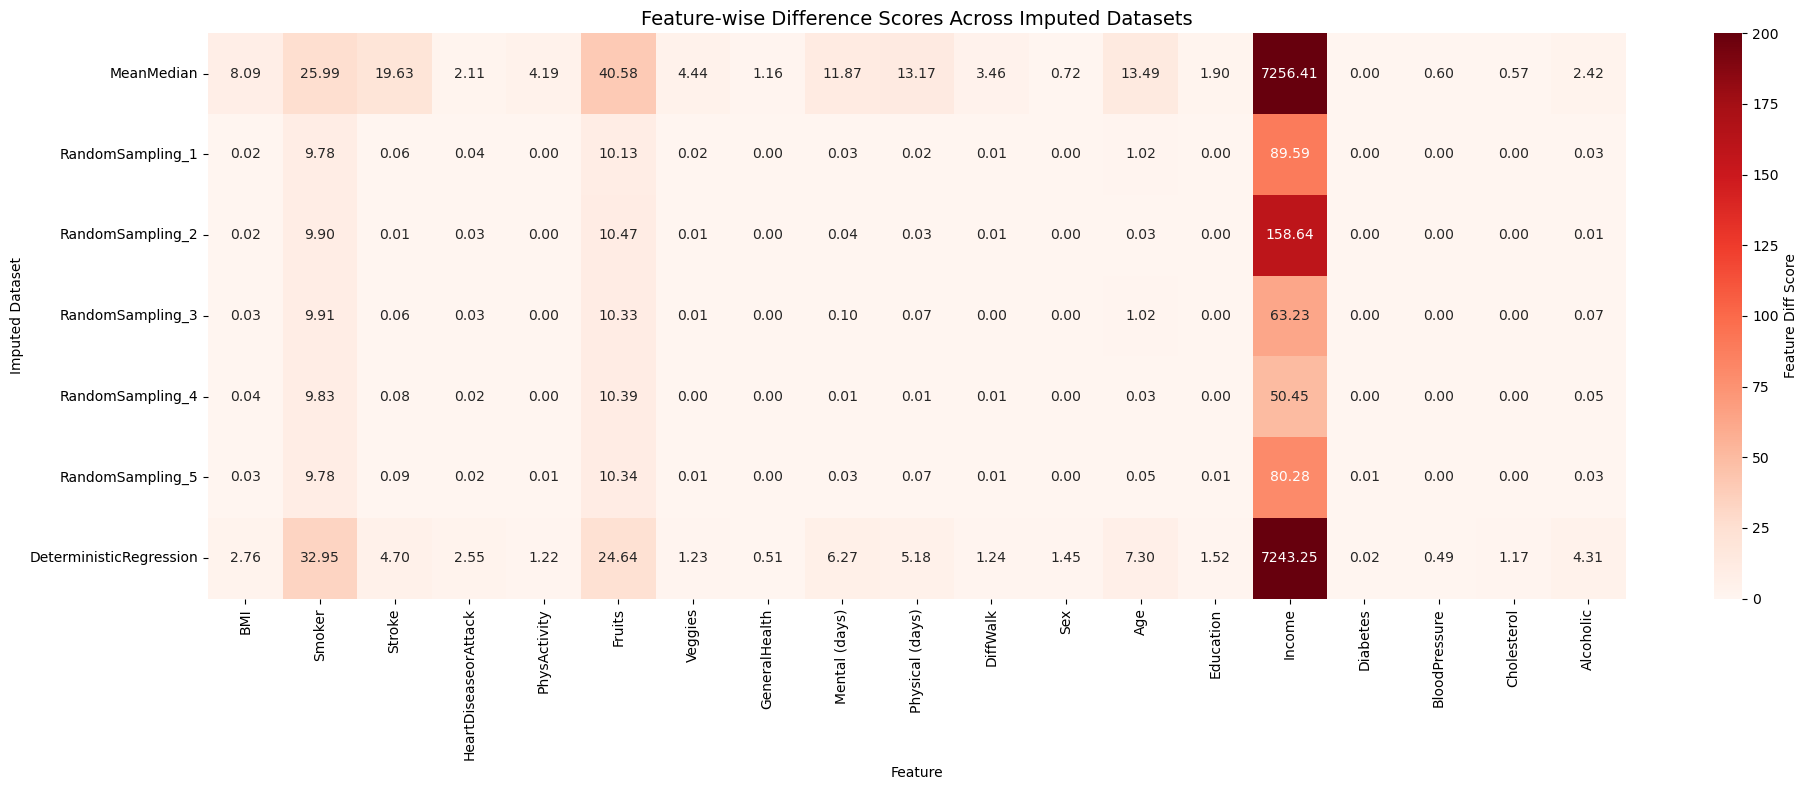

In [494]:
plot_feature_diff_heatmap(imputations, df, show_table=True)

- **整体情况**：大多数特征在不同插补方法下的差异分数均较小（通常 < 100），说明插补方法对这些特征分布的稳定性较好。  
- **异常特征**：唯独 **Income** 特征在所有插补方法下均表现出极端差异（分数在上千到七千不等）。  

这可可能是因为Income 的分布通常具有 **高度偏斜（skewness）** 和 **长尾特征（long-tail distribution）**，在这种情况下，均值/中位数插补会显著改变数据的尾部结构；回归插补或随机采样也难以保留真实的长尾特性。  

此外，Income 在数据集中的 **缺失率是最低的**，绝大多数 Income 样本都是完整的，少量缺失值无法从统计意义上影响整体结果。强行插补极少数缺失值，反而会引入系统性噪声，使分布与原始数据产生严重背离。  

对于 **Income 这种缺失极少但分布高度非对称的特征**，采用 **Complete-case analysis 针对该单一特征（删除含缺失值的少量样本）**，能避免人为改变整体分布结构，减少引入不可靠噪声的风险。  

#### （3）Complete-case analysis

In [495]:
def save_feature_complete_case(df, feature, save_path):
    """
    对指定特征执行 complete-case 删除，并保存为 CSV。

    参数
    ----
    df : pd.DataFrame
        原始数据集
    feature : str
        需要 complete-case 删除的特征名
    save_path : str
        结果 CSV 保存路径

    返回
    ----
    df_complete : pd.DataFrame
        删除缺失行后的完整数据
    """
    df_complete = df.dropna(subset=[feature])

    print(f"原始样本数: {len(df)}, 删除缺失 {feature} 后的样本数: {len(df_complete)}")

    # 仅当 save_path 含有目录时才创建目录
    import os
    dir_name = os.path.dirname(save_path)
    if dir_name:  
        os.makedirs(dir_name, exist_ok=True)

    # 保存 CSV
    df_complete.to_csv(save_path, index=False)
    print(f"已保存到: {save_path}")

    return df_complete

In [496]:
df = save_feature_complete_case(df, feature="Income", save_path="[Step4:IncomeCompleteCase]diabetes_diagnosis.csv")

原始样本数: 243618, 删除缺失 Income 后的样本数: 226619
已保存到: [Step4:IncomeCompleteCase]diabetes_diagnosis.csv


### 3.4.5 再次插补与评估

In [497]:
df = pd.read_csv('[Step4:IncomeCompleteCase]diabetes_diagnosis.csv')
X, y = split_features_labels(df, label_col='Diabetes', verbose=False)
numeric_features, categorical_features = identify_feature_types(df, verbose=False)

In [498]:
imputations_new, truncation_info_new = multi_method_imputation(X, y, methods=[1,2,3], verbose=True)

MeanMedian: 删除 5247 样本，比例 2.32%
RandomSampling_1: 删除 11113 样本，比例 4.90%
RandomSampling_2: 删除 11110 样本，比例 4.90%
RandomSampling_3: 删除 11206 样本，比例 4.94%
RandomSampling_4: 删除 11210 样本，比例 4.95%
RandomSampling_5: 删除 11027 样本，比例 4.87%
DeterministicRegression: 删除 5247 样本，比例 2.32%


+-------------------------+--------+----------+----------+------------------------+----------------+----------+-----------+-----------------+-----------------+-------------------+------------+--------+---------+-------------+----------+------------+-----------------+---------------+-------------+----------+
|                         |    BMI |   Smoker |   Stroke |   HeartDiseaseorAttack |   PhysActivity |   Fruits |   Veggies |   GeneralHealth |   Mental (days) |   Physical (days) |   DiffWalk |    Sex |     Age |   Education |   Income |   Diabetes |   BloodPressure |   Cholesterol |   Alcoholic |    Total |
+=========================+========+==========+==========+========================+================+==========+===========+=================+=================+===================+============+========+=========+=============+==========+============+=================+===============+=============+==========+
| MeanMedian              | 8.0912 |  25.8816 |  19.7007 |               

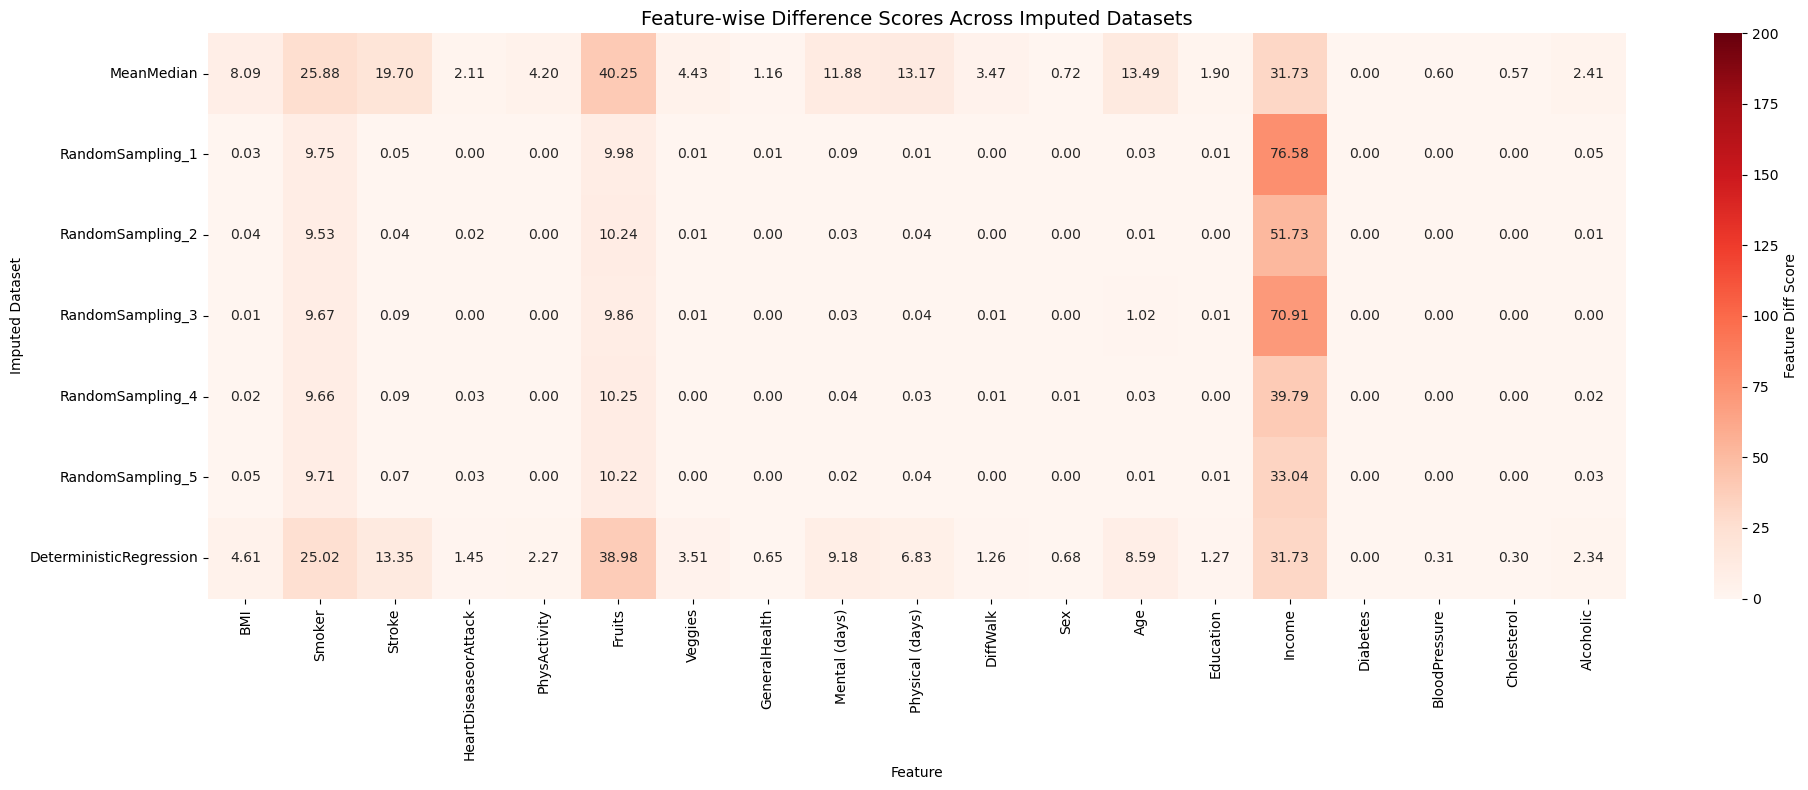

In [499]:
plot_feature_diff_heatmap(imputations_new, df, show_table=True)

绝大多数特征的差异分数均保持在较低水平，**总差异（Total）**明显下降，相比之前包含 Income 缺失的总分有显著降低，说明删除 Income 缺失样本后，整体数据分布更稳定。

### 3.4.6 插补结果选择

我们选取其中差异分数最小的插补结果作为最终数据

In [487]:
def select_and_save_best_imputed(diff_matrix, imputed_datasets, X, save_path):
    """
    从多重插补后的数据集中选择 Total 差异分数最小的插补数据，并保存为指定 CSV 文件。

    参数
    ----
    diff_matrix : pd.DataFrame
        build_feature_diff_matrix 函数输出的差异矩阵
    imputed_datasets : list of (str, pd.DataFrame)
        多重插补数据列表，格式为 (method_name, df)
    X : pd.DataFrame
        原始数据集，用于列对齐
    save_path : str
        最终保存的 CSV 文件路径（包含文件名）

    返回
    ----
    best_df : pd.DataFrame
        差异分数最小的插补数据集
    """
    # 找到 Total 最小的行
    best_row_name = diff_matrix['Total'].idxmin()
    best_index = diff_matrix.index.get_loc(best_row_name)

    # 获取对应的插补数据
    best_name, best_df = imputed_datasets[best_index]

    # 确保列顺序与原始 X 一致
    best_df = pd.DataFrame(best_df, columns=X.columns)

    # 只有在路径包含目录时才创建目录
    dir_path = os.path.dirname(save_path)
    if dir_path:
        os.makedirs(dir_path, exist_ok=True)

    # 保存 CSV
    best_df.to_csv(save_path, index=False)
    print(f"已保存差异最小数据集 '{best_name}' 至: {save_path}")

    return best_df

In [500]:
diff_matrix = build_feature_diff_matrix(imputations_new, df, weights=None, show_table=False)
best_df = select_and_save_best_imputed(diff_matrix, imputations_new, df, '[Step5:BestImputed]diabetes_diagnosis.csv')

已保存差异最小数据集 'RandomSampling_5' 至: [Step5:BestImputed]diabetes_diagnosis.csv


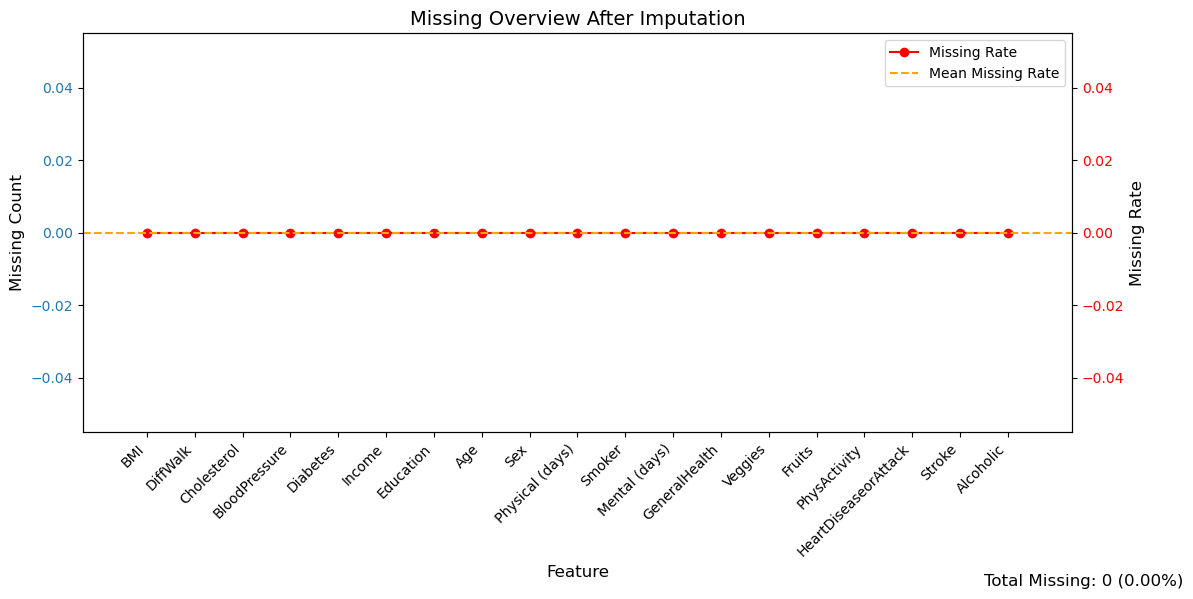

In [615]:
df = pd.read_csv('[Step5:BestImputed]diabetes_diagnosis.csv')
X,y = split_features_labels(df, label_col='Diabetes', verbose=False)
numeric_features, categorical_features = identify_feature_types(df, verbose=False)
plot_missing_statistics(df, title="Missing Overview After Imputation")

## 3.5 特征工程

本研究主要包括连续特征的变换与整体特征的降维处理。

### 3.5.1 特征变换

对于分类特征，由于其离散性质和编码方式，通常无法再进行额外的数值变换，因此主要对连续型特征进行处理。

#### (1) 特征情况分析

##### a. BMI

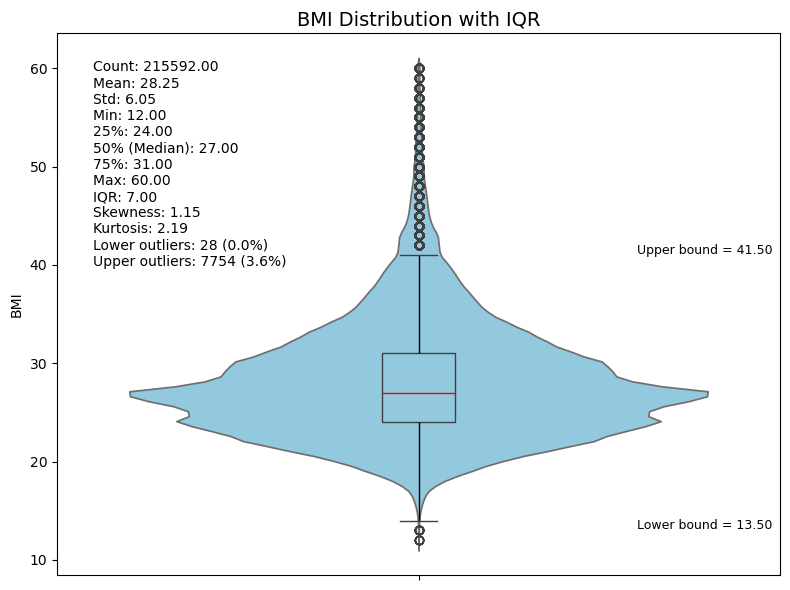

In [616]:
plot_single_continuous_distribution(df, column = "BMI")

BMI统计特征：
- 均值 28.25，标准差 6.05，取值范围 12–60。  
- 偏度：1.15（轻度右偏），峰度 2.19。  
分布特征：接近正态，但有一定右偏和长尾。  
建议处理：建模时标准化，当前保持原样。 

##### b. Mental (days)  

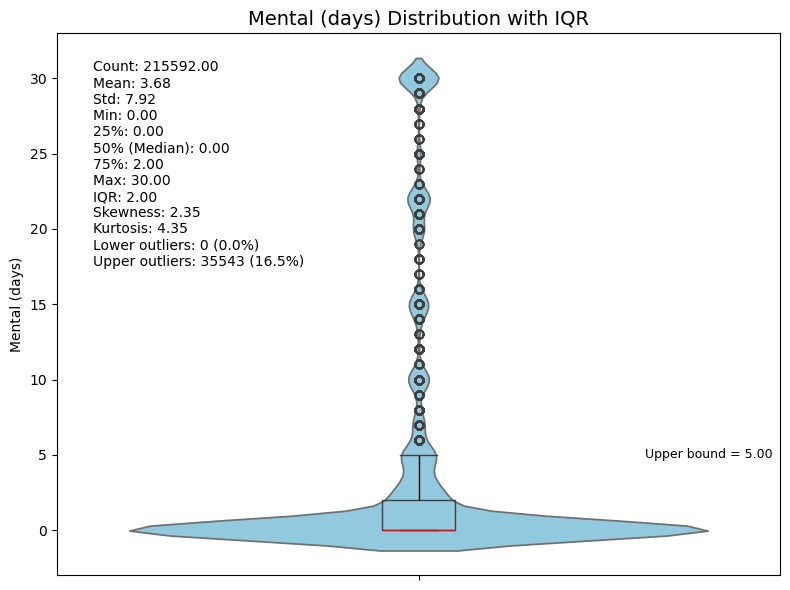

In [617]:
plot_single_continuous_distribution(df, column = "Mental (days)")

Mental (days)统计特征：
- 均值 3.68，中位数 0，取值 0–30。  
- 偏度：2.35（明显右偏），峰度 4.35。  
分布特征：大多数为 0，少数高值。  
建议处理：
- log1p 变换后分桶
- 新建二值变量（是否大于0）。 

##### c. Physical (days)

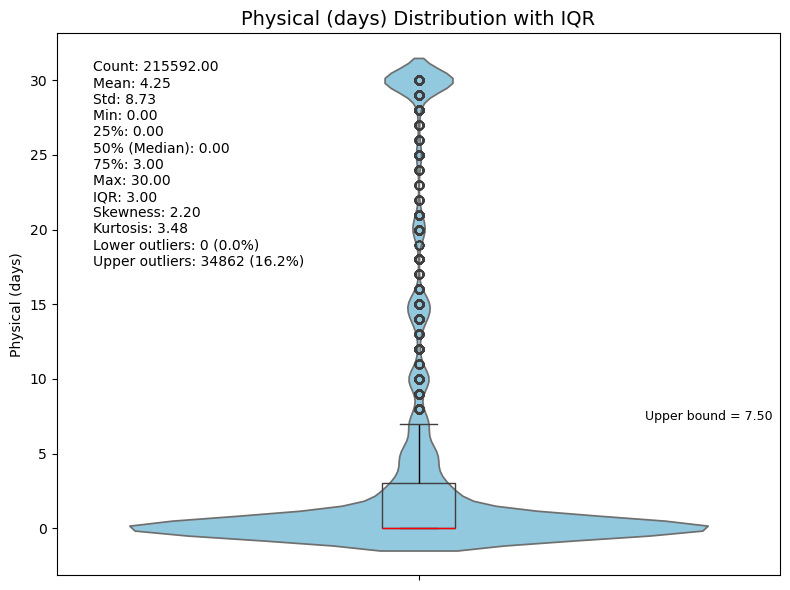

In [618]:
plot_single_continuous_distribution(df, column = "Physical (days)")

Physical (days)统计特征：
- 均值 4.25，中位数 0，取值 0–30。  
- 偏度：2.20（明显右偏），峰度 3.48。  
分布特征：大多数为 0，少数高值。  
建议处理：
- log1p 变换后分桶
- 新建二值变量（是否大于0）。 

##### d. Age

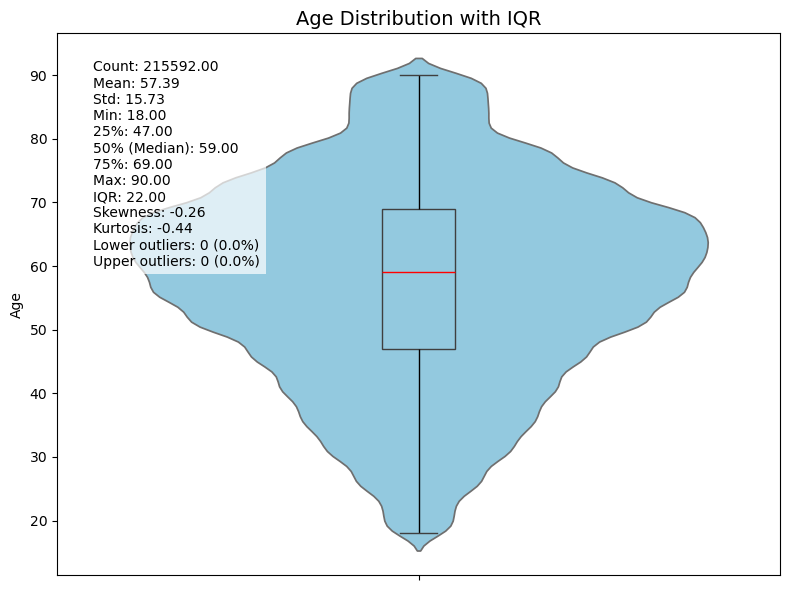

In [619]:
plot_single_continuous_distribution(df, column = "Age")

Age统计特征：
- 均值 57.39，标准差 15.73，取值 18–90。  
- 偏度：-0.26（轻微左偏），峰度 -0.44。  
分布特征：近似正态。  
建议处理：建模时标准化，当前保持原样；也可按年龄段分桶以增强解释性。

##### e. Income

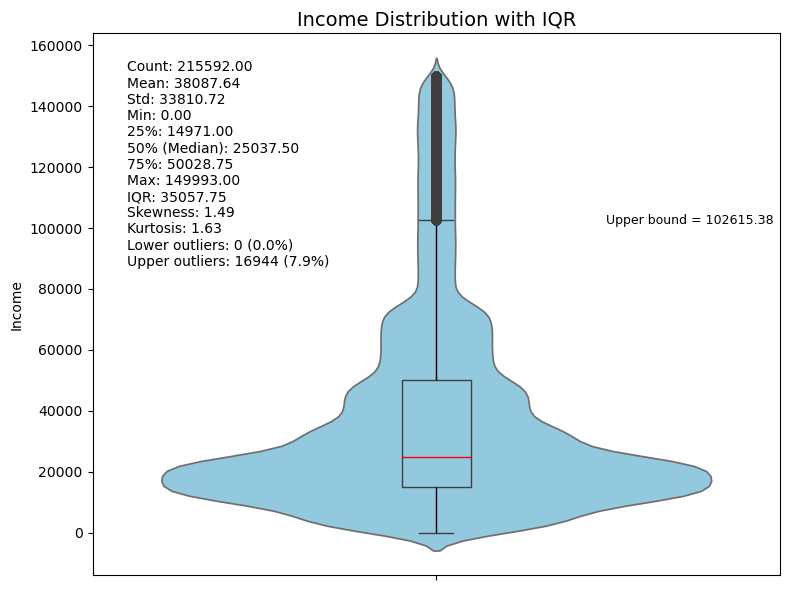

In [620]:
plot_single_continuous_distribution(df, column = "Income")

Income统计特征：均值 3.8 万，中位数 2.5 万，最大 15 万。  
偏度：1.49（明显右偏），峰度 1.63。  
分布特征：长尾分布，高收入拉高均值。  
建议处理：
- log1p 变换；
- 也可进一步分桶

#### （2）Mental (days)特征变换

##### a.二值化、log变换

In [621]:
def binarize_feature_threshold(df: pd.DataFrame, column: str, threshold: float = 0):
    """
    对指定特征进行阈值二元化，生成新列 <column>_bin。
    
    参数:
    - df: DataFrame
    - column: 待二元化列名
    - threshold: 阈值，默认 0（0/非0 分法），大于阈值为 1，否则为 0
    
    返回:
    - df: 原 df 增加新列
    """
    new_col = f"{column}_zero"
    df[new_col] = (df[column] > threshold).astype(int)
    
    # 输出新变量分布信息
    counts = df[new_col].value_counts()
    props = df[new_col].value_counts(normalize=True) * 100
    summary = pd.DataFrame({'Count': counts, 'Proportion (%)': props})
    print(f"Binarization (threshold={threshold}) result '{new_col}' for '{column}':")
    print(summary)
    
    return df

def log_transform_feature(df: pd.DataFrame, column: str, plot=True):
    """
    对指定特征进行 log1p 变换，生成新列 <column>_log，并可视化。
    
    参数:
    - df: DataFrame
    - column: 列名
    - plot: 是否调用 plot_single_continuous_distribution 绘图
    
    返回:
    - df: 原 df 增加新列
    """
    new_col = f"{column}_log"
    df[new_col] = np.log1p(df[column])
    
    # 可视化
    if plot:
        plot_single_continuous_distribution(df, new_col)
    
    print(f"Log1p transformation result for '{column}', new column: '{new_col}'")
    return df

Binarization (0/non0) result 'Mental (days)_zero' for 'Mental (days)':
                     Count  Proportion (%)
Mental (days)_zero                        
0                   145441       67.461223
1                    70151       32.538777


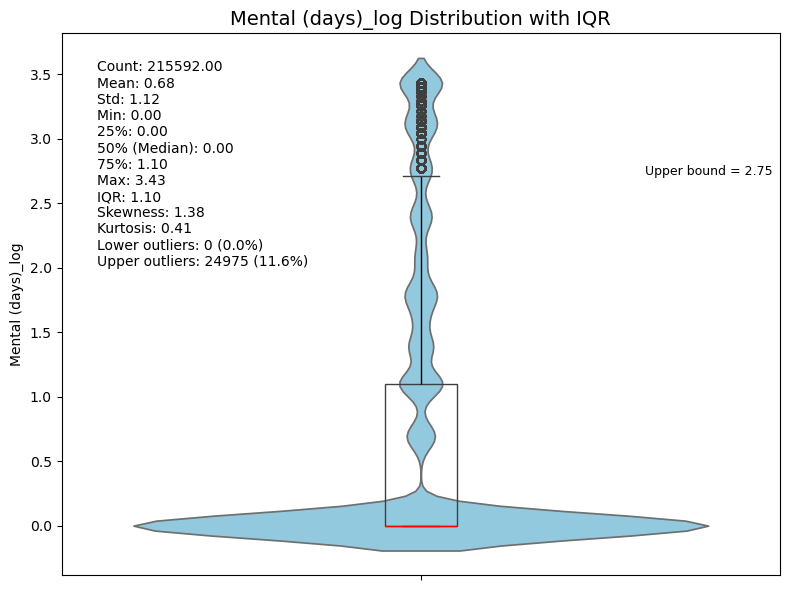

Log1p transformation result for 'Mental (days)', new column: 'Mental (days)_log'


In [622]:
df = binarize_feature_zero(df, column="Mental (days)")
df = log_transform_feature(df, column="Mental (days)")

##### b. 分桶

为了充分挖掘连续特征的信息，同时兼顾统计建模与业务解释性，本研究对连续特征采用三种分桶方法：

1. **等距分桶 (Equal-width binning)**  
   - 将变量取值范围平均划分为若干段（默认5等分），每个区间跨度相同。  
   - **优势**：简单直观，便于观察变量在不同取值区间的分布趋势。  
   - **适用场景**：适合变量取值范围较均匀、且希望保持每个区间物理意义一致的情况。  

2. **等频分桶 (Quantile binning)**  
   - 将变量按样本分位数划分，每个区间包含相同数量的样本。  
   - **优势**：可以缓解数据偏态或长尾影响，使每个分组样本量均衡，提高统计分析稳定性。  
   - **适用场景**：适合偏态分布的连续变量，如 BMI、Mental (days)，避免少数极端值主导分组效果。  

3. **业务分隔分桶 (Business-driven binning)**  
   - 根据领域知识或业务规则预设分隔线，将连续变量划分为具有实际解释意义的区间。  
   - **优势**：与业务或临床阈值对应，易于解释和后续决策。  
   - **适用场景**：心理健康指标、BMI、血压等指标，参考公共卫生标准或临床分级，如 Mental (days) 的 0天 / 1–13天 / 14–30天分组。  

**综合理由**：  
- 等距分桶提供直观的连续区间划分；  
- 等频分桶保证每组样本量均衡，增强统计分析的稳健性；  
- 业务分隔分桶赋予分组实际含义，便于解释和报告。  

因此，三个方法互为补充，可同时生成多个特征版本，用于对比分析。

In [623]:
def bin_feature_all(df: pd.DataFrame, column: str, bins: int = 5, business_bins: list = None, plot: bool = True):
    """
    对指定特征同时进行三种分桶：
    1. 等距分桶 (equal_width)
    2. 等频分桶 (quantile)
    3. 业务分隔分桶 (business)

    参数:
    - df: DataFrame
    - column: 待分桶列名
    - bins: 分桶数量（等距或等频）
    - business_bins: 自定义分隔列表（业务分隔方法必填）
    - plot: 是否绘制分布图

    返回:
    - df: 原 df 增加三列
    - new_cols: 新增列名列表
    """
    new_cols = []

    # 1. 等距分桶
    new_col_eq = f"{column}_equal_width"
    df[new_col_eq] = pd.cut(df[column], bins=bins, labels=False, include_lowest=True)
    new_cols.append(new_col_eq)

    # 2. 等频分桶
    new_col_q = f"{column}_quantile"
    df[new_col_q] = pd.qcut(df[column], q=bins, labels=False, duplicates='drop')
    new_cols.append(new_col_q)

    # 3. 业务分隔分桶
    if business_bins is not None:
        new_col_b = f"{column}_business"
        df[new_col_b] = pd.cut(df[column], bins=business_bins, labels=False, include_lowest=True)
        new_cols.append(new_col_b)
    else:
        print("Warning: business_bins 未提供，业务分隔分桶未生成。")

    # 可视化
    if plot and len(new_cols) > 0:
        plot_categorical_distributions(df, categorical_features=new_cols, n_cols=3, title=f"Binned Distributions of '{column}'")

    return df

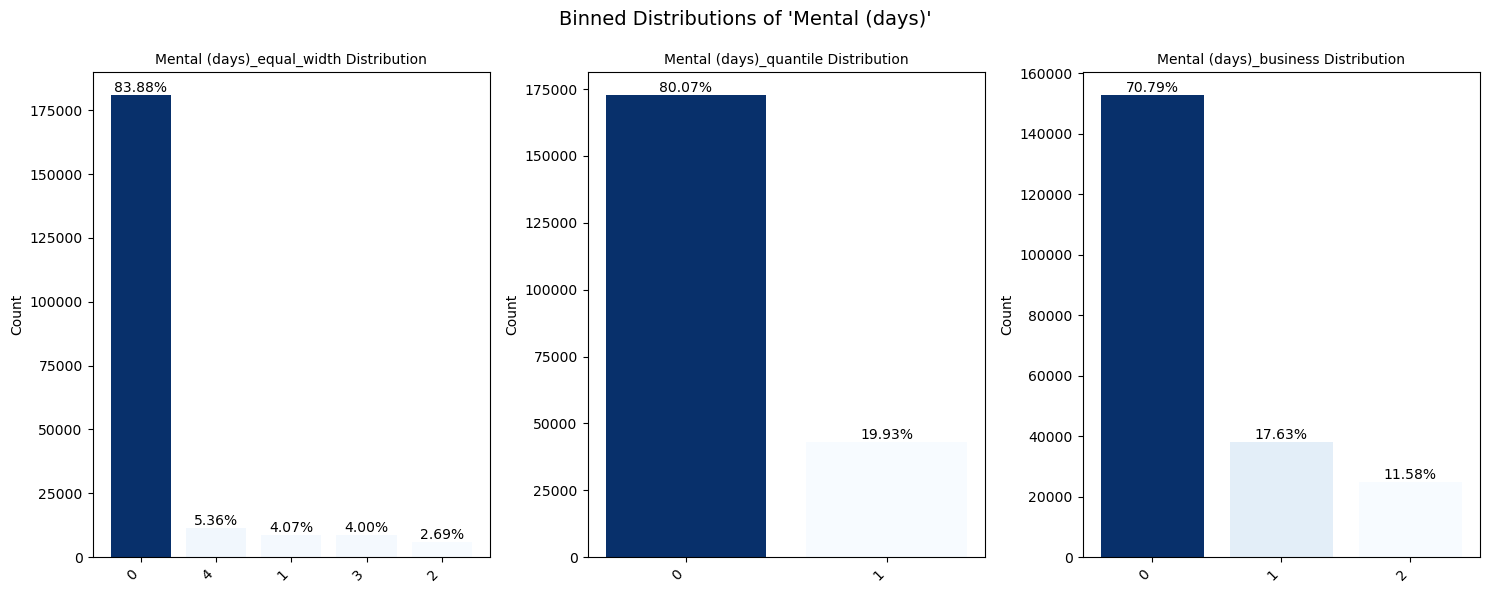

In [624]:
df = bin_feature_all(df, column="Mental (days)", bins=5, business_bins=[0, 1, 14, 31])

##### c. 变换效果评估

特征变换效果评估方法基于线性回归 R²：
1. 将单个原始特征生成多种变换组合，包括二元化、log1p、等距/等频/业务分桶，以及分桶或 log1p 与二元化的组合。  
2. 随后，针对每个特征集拟合目标变量，计算线性回归 R²，以衡量特征集对目标的线性解释能力。  

快速比较不同特征变换的解释力差异， R² 排序为特征选择提供直观参考，帮助判断哪些变换值得保留。

In [625]:
def build_feature_sets_single(df: pd.DataFrame, column: str):
    """
    根据指定单个特征和变换后的命名规则生成组合特征集。

    适用的变换：
    - 二元化: <col>_zero
    - log1p: <col>_log
    - 分桶:
        等距: <col>_equal_width
        等频: <col>_quantile
        业务逻辑: <col>_business
    - 组合: 分桶/二元化、log1p+二元化

    参数:
    - df: DataFrame
    - column: 原始列名（如 "Mental (days)"）

    返回:
    - feature_sets: dict, key=组合名称, value=对应列列表
    """
    feature_sets = {}
    short = column.split()[0]  # 取第一个词做短名，如 "Mental"

    # 二元化
    zero_col = f"{column}_zero"
    feature_sets[f"{short}_原始"] = [column]
    feature_sets[f"{short}_原始+二元化"] = [column, zero_col] if zero_col in df.columns else [column]

    # 分桶
    quant_col = f"{column}_quantile"
    equal_col = f"{column}_equal_width"
    business_col = f"{column}_business"

    if quant_col in df.columns:
        feature_sets[f"{short}_等频分桶"] = [quant_col]
    if equal_col in df.columns:
        feature_sets[f"{short}_等宽分桶"] = [equal_col]
    if business_col in df.columns:
        feature_sets[f"{short}_业务逻辑分桶"] = [business_col]

    # 分桶 + 二元化
    for b_col, b_name in zip([quant_col, equal_col, business_col],
                             ["等频分桶", "等宽分桶", "业务逻辑分桶"]):
        if b_col in df.columns and zero_col in df.columns:
            feature_sets[f"{short}_{b_name}+二元化"] = [b_col, zero_col]

    # log1p
    log_col = f"{column}_log"
    if log_col in df.columns:
        feature_sets[f"{short}_log1p"] = [log_col]

    # log1p + 二元化
    if log_col in df.columns and zero_col in df.columns:
        feature_sets[f"{short}_log1p+二元化"] = [log_col, zero_col]

    # 输出表格
    from tabulate import tabulate
    rows = [(k, len(v), v) for k, v in feature_sets.items()]
    print(tabulate(rows, headers=["feature_set", "n_feats", "features"], tablefmt="grid"))

    return feature_sets

In [626]:
feature_sets_mental = build_feature_sets_single(df, "Mental (days)")

+----------------------------+-----------+-----------------------------------------------------+
| feature_set                |   n_feats | features                                            |
+============================+===========+=====================================================+
| Mental_原始                |         1 | ['Mental (days)']                                   |
+----------------------------+-----------+-----------------------------------------------------+
| Mental_原始+二元化         |         2 | ['Mental (days)', 'Mental (days)_zero']             |
+----------------------------+-----------+-----------------------------------------------------+
| Mental_等频分桶            |         1 | ['Mental (days)_quantile']                          |
+----------------------------+-----------+-----------------------------------------------------+
| Mental_等宽分桶            |         1 | ['Mental (days)_equal_width']                       |
+----------------------------+-----------+---

In [627]:
def evaluate_feature_sets_r2(df: pd.DataFrame, feature_sets: dict, target: str = 'Diabetes'):
    """
    对多个特征集使用线性回归计算 R²，并以 tabulate 表格输出排序结果。

    参数:
    ----
    df : pd.DataFrame
        包含所有特征的 DataFrame
    feature_sets : dict
        key=特征集名称, value=对应列列表
    target : str
        目标列名（y），必须和特征列不重复

    返回:
    ----
    r2_results : pd.DataFrame
        包含每个特征集名称、R²，并按 R² 降序排序
    """
    from tabulate import tabulate

    r2_dict = {}
    y_target = df[target]

    for set_name, cols in feature_sets.items():
        # 只取存在于 DataFrame 的列
        X_input = df[[col for col in cols if col in df.columns]].fillna(0)
        # 调用 compute_r2 计算 R²
        r2 = compute_r2(X_input, y_target)
        r2_dict[set_name] = r2

    r2_results = pd.DataFrame({
        "feature_set": list(r2_dict.keys()),
        "R²": list(r2_dict.values())
    }).sort_values(by="R²", ascending=False).reset_index(drop=True)

    # 输出 tabulate 表格
    print("Feature sets R² ranking:")
    print(tabulate(r2_results, headers='keys', tablefmt='grid', floatfmt=".4f"))


In [628]:
evaluate_feature_sets_r2(df, feature_sets_mental)

Feature sets R² ranking:
+----+----------------------------+--------+
|    | feature_set                |     R² |
+====+============================+========+
|  0 | Mental_原始+二元化         | 0.0011 |
+----+----------------------------+--------+
|  1 | Mental_log1p+二元化        | 0.0011 |
+----+----------------------------+--------+
|  2 | Mental_原始                | 0.0011 |
+----+----------------------------+--------+
|  3 | Mental_等宽分桶+二元化     | 0.0011 |
+----+----------------------------+--------+
|  4 | Mental_等宽分桶            | 0.0011 |
+----+----------------------------+--------+
|  5 | Mental_业务逻辑分桶+二元化 | 0.0009 |
+----+----------------------------+--------+
|  6 | Mental_等频分桶+二元化     | 0.0009 |
+----+----------------------------+--------+
|  7 | Mental_等频分桶            | 0.0008 |
+----+----------------------------+--------+
|  8 | Mental_log1p               | 0.0008 |
+----+----------------------------+--------+
|  9 | Mental_业务逻辑分桶        | 0.0008 |
+----+--------------------------

根据线性回归 R² 评估结果，我们观察到**Mental_原始+二元化** 与 **Mental_log1p+二元化** 的 R² 略高于 **Mental_原始**，但整体 R² 水平仍然极低（约 0.0011），说明 **经过 log1p 或二元化处理的特征，对目标变量的线性解释能力提升非常有限**。  

由于作业限制，我们无法直接量化这些变换对非线性关系的潜在增益，但从理论上，二元化可提示特征是否存在非零状态的额外信息。考虑到我们的数据集样本数远大于特征数，不存在因增加二元化特征而导致的维度问题，因此我们决定 **将二元化特征作为新的特征加入特征集**，以补充原始特征的解释信息，同时保持特征维度在可控范围内。

##### d. 变换处理

In [629]:
drop_cols = ["Mental (days)_quantile", "Mental (days)_business", "Mental (days)_equal_width", "Mental (days)_log"]
df = drop_features_and_save(df, drop_cols, '[Step6:MentalTransform]diabetes_diagnosis.csv', plot=False)

剩余特征:
['BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'GeneralHealth', 'Mental (days)', 'Physical (days)', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'Diabetes', 'BloodPressure', 'Cholesterol', 'Alcoholic', 'Mental (days)_zero']
数据维度: (215592, 20)
数据已保存至: /Users/guocy/Projects/5310_a1/diabetes/[Step6:MentalTransform]diabetes_diagnosis.csv


#### （3）Physical (days)

##### a. 二值化、Log变换、分桶

Binarization (0/non0) result 'Physical (days)_zero' for 'Physical (days)':
                       Count  Proportion (%)
Physical (days)_zero                        
0                     136303       63.222661
1                      79289       36.777339


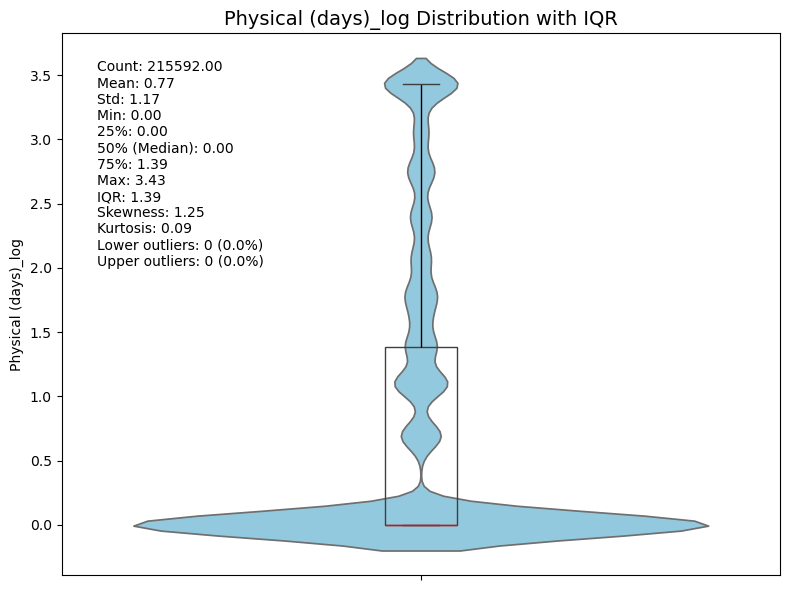

Log1p transformation result for 'Physical (days)', new column: 'Physical (days)_log'


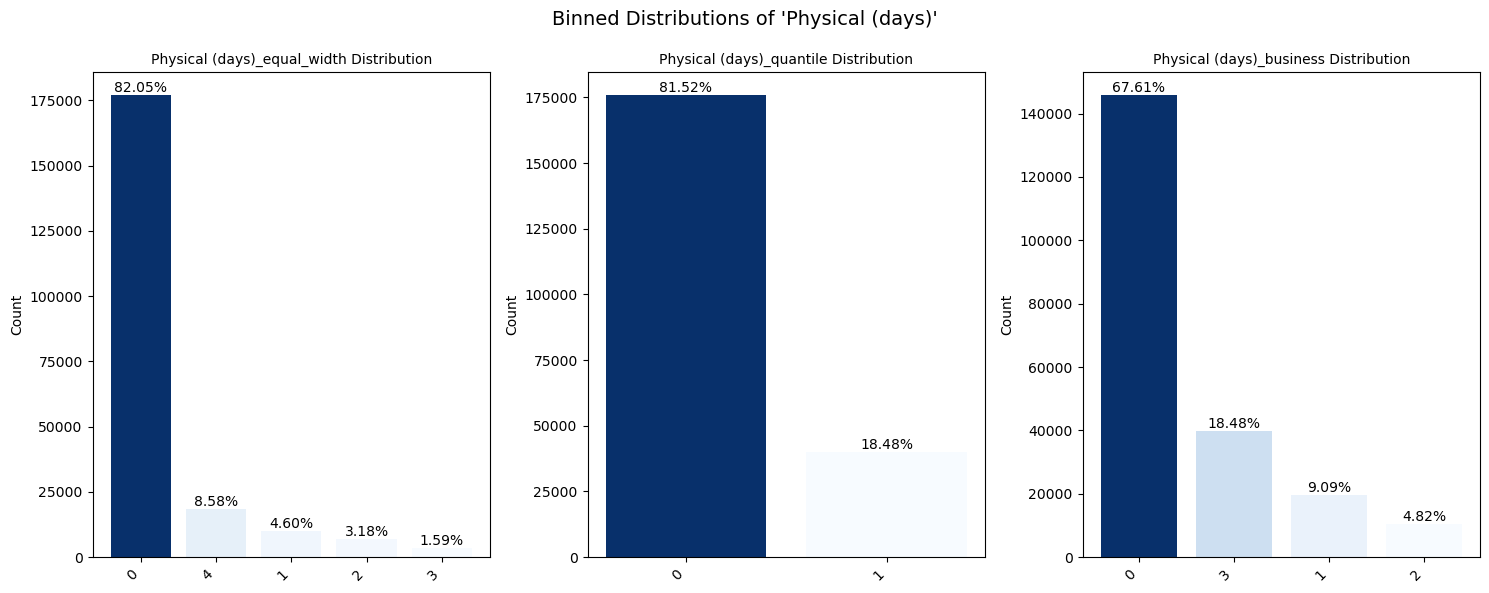

In [630]:
df = binarize_feature_zero(df, column="Physical (days)")
df = log_transform_feature(df, column="Physical (days)")
df = bin_feature_all(df, column="Physical (days)", bins=5, business_bins=[0, 1, 3, 5, 31])

##### b.变换效果评估与变换处理

In [631]:
feature_sets_physical = build_feature_sets_single(df, "Physical (days)")
evaluate_feature_sets_r2(df, feature_sets_physical)

+------------------------------+-----------+---------------------------------------------------------+
| feature_set                  |   n_feats | features                                                |
+==============================+===========+=========================================================+
| Physical_原始                |         1 | ['Physical (days)']                                     |
+------------------------------+-----------+---------------------------------------------------------+
| Physical_原始+二元化         |         2 | ['Physical (days)', 'Physical (days)_zero']             |
+------------------------------+-----------+---------------------------------------------------------+
| Physical_等频分桶            |         1 | ['Physical (days)_quantile']                            |
+------------------------------+-----------+---------------------------------------------------------+
| Physical_等宽分桶            |         1 | ['Physical (days)_equal_width']            

结果与Mental类似，我们决定 **将二元化特征作为新的特征加入特征集**，以补充原始特征的解释信息，同时保持特征维度在可控范围内。

In [632]:
drop_cols = ["Physical (days)_quantile", "Physical (days)_business", "Physical (days)_equal_width", "Physical (days)_log"]
df = drop_features_and_save(df, drop_cols, '[Step7:PhysicalTransform]diabetes_diagnosis.csv', plot=False)

剩余特征:
['BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'GeneralHealth', 'Mental (days)', 'Physical (days)', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'Diabetes', 'BloodPressure', 'Cholesterol', 'Alcoholic', 'Mental (days)_zero', 'Physical (days)_zero']
数据维度: (215592, 21)
数据已保存至: /Users/guocy/Projects/5310_a1/diabetes/[Step7:PhysicalTransform]diabetes_diagnosis.csv


#### （4）Income

##### a.二值化、Log变换、分桶

Binarization (threshold=25000) result 'Income_zero' for 'Income':
              Count  Proportion (%)
Income_zero                        
1            107896       50.046384
0            107696       49.953616


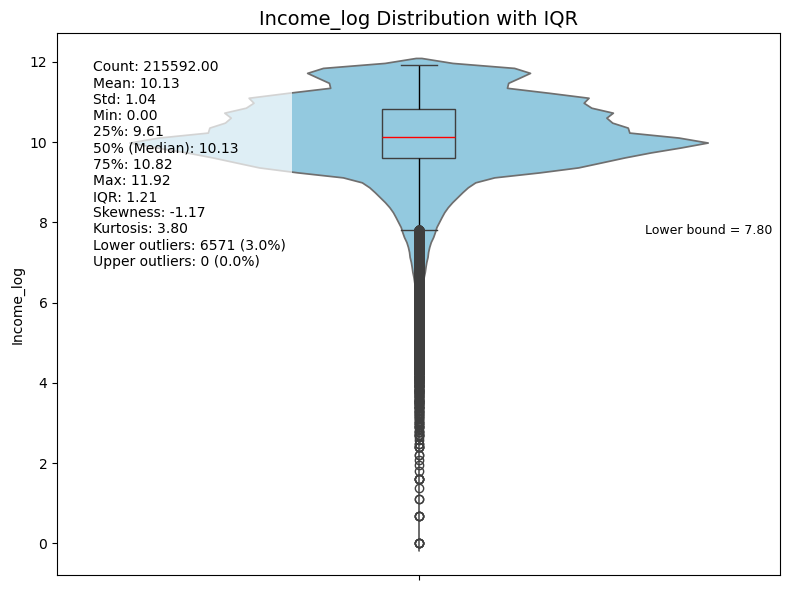

Log1p transformation result for 'Income', new column: 'Income_log'


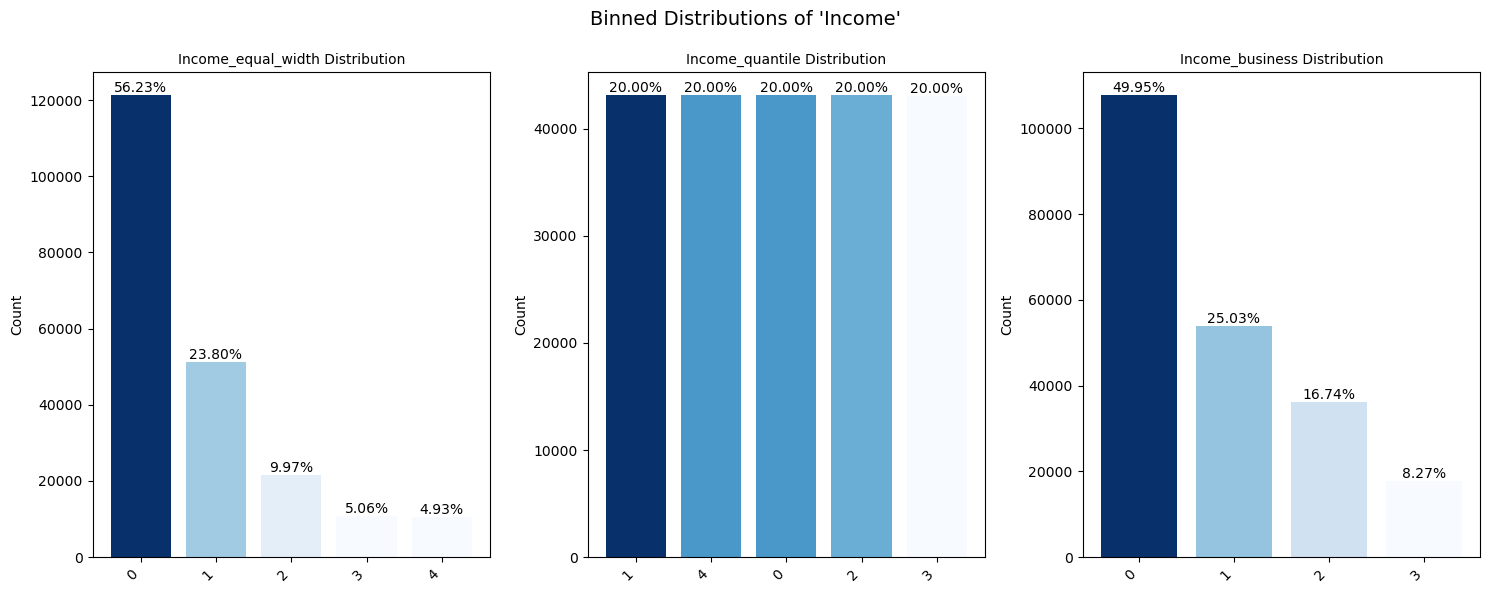

In [633]:
df = binarize_feature_threshold(df, "Income", threshold=25000)
df = log_transform_feature(df, column="Income")
df = bin_feature_all(df, column="Income", bins=5, business_bins=[0, 25000, 50000, 100000, 150000])

##### b.变换效果评估与变换处理

In [634]:
feature_sets_income = build_feature_sets_single(df, "Income")
evaluate_feature_sets_r2(df, feature_sets_income)

+----------------------------+-----------+---------------------------------------+
| feature_set                |   n_feats | features                              |
+============================+===========+=======================================+
| Income_原始                |         1 | ['Income']                            |
+----------------------------+-----------+---------------------------------------+
| Income_原始+二元化         |         2 | ['Income', 'Income_zero']             |
+----------------------------+-----------+---------------------------------------+
| Income_等频分桶            |         1 | ['Income_quantile']                   |
+----------------------------+-----------+---------------------------------------+
| Income_等宽分桶            |         1 | ['Income_equal_width']                |
+----------------------------+-----------+---------------------------------------+
| Income_业务逻辑分桶        |         1 | ['Income_business']                   |
+------------------------

与之前 Mental 特征不同，Income 的二元化和分桶操作没有实际意义，不会提供额外的线性解释能力。综合考虑，为保持数据原貌、避免不必要的处理，建议保留原始 Income 列，不做二元化或分桶。

In [635]:
drop_cols = ["Income_quantile", "Income_business", "Income_equal_width", "Income_log","Income_zero"]
df = drop_features_and_save(df, drop_cols, '[Step8:IncomeNoTransform]diabetes_diagnosis.csv', plot=False)

剩余特征:
['BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'GeneralHealth', 'Mental (days)', 'Physical (days)', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'Diabetes', 'BloodPressure', 'Cholesterol', 'Alcoholic', 'Mental (days)_zero', 'Physical (days)_zero']
数据维度: (215592, 21)
数据已保存至: /Users/guocy/Projects/5310_a1/diabetes/[Step8:IncomeNoTransform]diabetes_diagnosis.csv


In [163]:
def transform_days_features(df, cols=["Mental (days)", "Physical (days)"], plot=False):
    """
    生成仅数值型输出：
      *_any            -> int8 (0/1)
      *_log1p          -> float
      *_qcut           -> int8 (0..3, 等频四分位)
      *_cut            -> int8 (0..4, 等宽五等分)
      *_bin_logic      -> int8 (0..2, 业务逻辑: 0days/1-7/8-30)
    同名列将被覆盖。
    """
    n = len(df)
    for col in cols:
        base = col.replace(" ", "_").lower()  # 与你现有命名保持一致

        # 1) 二元化
        any_col = f"{base}_any"
        df[any_col] = (df[col].astype(float) > 0).astype("int8")

        # 2) log1p
        log_col = f"{base}_log1p"
        df[log_col] = np.log1p(df[col].astype(float))

        # 3) 等频分桶（四分位）→ 整数编码 0..3
        qcut_col = f"{base}_qcut"
        try:
            qcodes = pd.qcut(df[log_col], q=4, labels=False, duplicates="drop")
            # 如遇到重复边界导致缺失，用微扰重算
            if pd.isna(qcodes).any():
                qcodes = pd.qcut(df[log_col] + np.random.normal(0, 1e-6, n),
                                 q=4, labels=False)
        except Exception:
            qcodes = pd.qcut(df[log_col] + np.random.normal(0, 1e-6, n),
                             q=4, labels=False)
        df[qcut_col] = qcodes.astype("int8")

        # 4) 等宽分桶（5等分）→ 整数编码 0..4
        cut_col = f"{base}_cut"
        ccodes = pd.cut(df[log_col], bins=5, labels=False, include_lowest=True)
        # 可能出现极端边界NaN，做一次兜底
        if pd.isna(ccodes).any():
            lo, hi = df[log_col].min(), df[log_col].max()
            eps = (hi - lo) * 1e-9 if hi > lo else 1e-9
            ccodes = pd.cut(df[log_col].clip(lo - eps, hi + eps),
                            bins=5, labels=False, include_lowest=True)
        df[cut_col] = ccodes.astype("int8")

        # 5) 业务逻辑分桶（0, 1–7, 8–30）→ 整数编码 0..2
        logic_col = f"{base}_bin_logic"
        lcodes = pd.cut(df[col].astype(float),
                        bins=[-1, 0, 7, 30], labels=False, include_lowest=True)
        df[logic_col] = lcodes.astype("int8")

        # 可视化（可选）
        if plot:
            fig, axes = plt.subplots(2, 2, figsize=(12, 9))
            fig.suptitle(f"Feature engineering for {col}", fontsize=14)

            df[any_col].value_counts().sort_index().plot(kind="bar", ax=axes[0,0])
            axes[0,0].set_title(f"{any_col} (0/1)")

            df[log_col].hist(bins=30, ax=axes[0,1])
            axes[0,1].set_title(f"{log_col}")

            df[qcut_col].value_counts().sort_index().plot(kind="bar", ax=axes[1,0])
            axes[1,0].set_title(f"{qcut_col} (0..3)")

            df[cut_col].value_counts().sort_index().plot(kind="bar", ax=axes[1,1])
            axes[1,1].set_title(f"{cut_col} (0..4)")

            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(4,3))
            df[logic_col].value_counts().sort_index().plot(kind="bar")
            plt.title(f"{logic_col} (0..2)")
            plt.tight_layout()
            plt.show()

    return df

In [549]:
df = transform_days_features(df, cols=["Mental (days)", "Physical (days)"], plot=True)

NameError: name 'transform_days_features' is not defined

In [167]:
def evaluate_features(X, y, features, continuous_features, discrete_features):
    """
    X: pd.DataFrame 特征数据
    y: pd.Series 目标变量 (多分类)
    features: list, 要比较的特征名
    continuous_features: list, 属于连续特征
    discrete_features: list, 属于离散特征
    """
    results = []

    for feat in features:
        if feat in continuous_features:
            score = anova_eta_squared(X[feat], y)
            metric = "eta_squared"
        elif feat in discrete_features:
            score = cramers_v(X[feat], y)
            metric = "cramers_v"
        else:
            score = None
            metric = "N/A"
        
        results.append({
            "feature": feat,
            "metric": metric,
            "score": score
        })
    
    return pd.DataFrame(results).sort_values("score", ascending=False)


# ===== 特征划分 =====
features_mental = [
    "Mental (days)", "mental_(days)_log1p",
    "mental_(days)_any", "mental_(days)_qcut",
    "mental_(days)_cut", "mental_(days)_bin_logic"
]

features_physical = [
    "Physical (days)", "physical_(days)_log1p",
    "physical_(days)_any", "physical_(days)_qcut",
    "physical_(days)_cut", "physical_(days)_bin_logic"
]

continuous_features = [
    "Mental (days)", "mental_(days)_log1p",
    "Physical (days)", "physical_(days)_log1p"
]

discrete_features = list(set(features_mental + features_physical) - set(continuous_features))


# ===== 计算结果 =====
results_mental = evaluate_features(df, y, features_mental, continuous_features, discrete_features)
results_physical = evaluate_features(df, y, features_physical, continuous_features, discrete_features)

from tabulate import tabulate

print("Mental features:")
print(tabulate(results_mental, headers="keys", tablefmt="grid", floatfmt=".3f"))

print("\nPhysical features:")
print(tabulate(results_physical, headers="keys", tablefmt="grid", floatfmt=".3f"))

Mental features:
+----+-------------------------+-------------+---------+
|    | feature                 | metric      |   score |
+====+=========================+=============+=========+
|  3 | mental_(days)_qcut      | cramers_v   |   0.024 |
+----+-------------------------+-------------+---------+
|  4 | mental_(days)_cut       | cramers_v   |   0.023 |
+----+-------------------------+-------------+---------+
|  5 | mental_(days)_bin_logic | cramers_v   |   0.022 |
+----+-------------------------+-------------+---------+
|  2 | mental_(days)_any       | cramers_v   |   0.015 |
+----+-------------------------+-------------+---------+
|  0 | Mental (days)           | eta_squared |   0.001 |
+----+-------------------------+-------------+---------+
|  1 | mental_(days)_log1p     | eta_squared |   0.001 |
+----+-------------------------+-------------+---------+

Physical features:
+----+---------------------------+-------------+---------+
|    | feature                   | metric      | 

In [169]:
def evaluate_feature_sets_linear(X, y, feature_sets):
    """
    使用线性回归/逻辑回归评估不同特征集
    """
    results = []
    
    for name, feats in feature_sets.items():
        X_sub = sm.add_constant(X[feats])  # 加常数项
        model = sm.MNLogit(y, X_sub)  # 多分类逻辑回归 (如果是二分类也适用)
        result = model.fit(disp=False)
        
        results.append({
            "feature_set": name,
            "n_features": len(feats),
            "aic": result.aic,
            "bic": result.bic,
            "pseudo_r2": result.prsquared
        })
    
    return pd.DataFrame(results).sort_values("pseudo_r2", ascending=False)

+----+------------------+--------------+------------+------------+-------------+
|    | feature_set      |   n_features |        aic |        bic |   pseudo_r2 |
+====+==================+==============+============+============+=============+
|  3 | 原始+分桶+二元化 |           10 | 216876.677 | 217103.445 |       0.007 |
+----+------------------+--------------+------------+------------+-------------+
|  2 | 原始+分桶        |            8 | 216882.940 | 217068.477 |       0.007 |
+----+------------------+--------------+------------+------------+-------------+
|  1 | 原始+二元化      |            4 | 216908.873 | 217011.949 |       0.007 |
+----+------------------+--------------+------------+------------+-------------+
|  0 | 原始             |            2 | 216964.940 | 217026.786 |       0.006 |
+----+------------------+--------------+------------+------------+-------------+


In [170]:
# 生成按要求的 feature_sets（Mental 与 Physical 分开）
orig_cols = ["Mental (days)", "Physical (days)"]

feature_sets = {}
for col in orig_cols:
    base = col.replace(" ", "_").lower()       # e.g. "mental_(days)"
    short = base.split("_")[0].capitalize()    # "Mental" or "Physical"

    # 原始 / 原始+二元化（保留原始）
    feature_sets[f"{short}_原始"] = [col]
    feature_sets[f"{short}_原始+二元化"] = [col, f"{base}_any"]

    # 仅分桶（不包含原始）
    feature_sets[f"{short}_等频分桶"] = [f"{base}_qcut"]
    feature_sets[f"{short}_等宽分桶"] = [f"{base}_cut"]
    feature_sets[f"{short}_业务逻辑分桶"] = [f"{base}_bin_logic"]

    # 分桶 + 二元化（不包含原始）
    feature_sets[f"{short}_等频分桶+二元化"] = [f"{base}_qcut", f"{base}_any"]
    feature_sets[f"{short}_等宽分桶+二元化"] = [f"{base}_cut", f"{base}_any"]
    feature_sets[f"{short}_业务逻辑分桶+二元化"] = [f"{base}_bin_logic", f"{base}_any"]

# 检查
from tabulate import tabulate
rows = [(k, len(v), v) for k,v in feature_sets.items()]
print(tabulate(rows, headers=["feature_set","n_feats","features"], tablefmt="grid"))

+------------------------------+-----------+------------------------------------------------------+
| feature_set                  |   n_feats | features                                             |
+==============================+===========+======================================================+
| Mental_原始                  |         1 | ['Mental (days)']                                    |
+------------------------------+-----------+------------------------------------------------------+
| Mental_原始+二元化           |         2 | ['Mental (days)', 'mental_(days)_any']               |
+------------------------------+-----------+------------------------------------------------------+
| Mental_等频分桶              |         1 | ['mental_(days)_qcut']                               |
+------------------------------+-----------+------------------------------------------------------+
| Mental_等宽分桶              |         1 | ['mental_(days)_cut']                                |
+--------------

In [171]:
results_linear = evaluate_feature_sets_linear(df, y, feature_sets)
print(tabulate(results_linear, headers="keys", tablefmt="grid", floatfmt=".3f"))

+----+------------------------------+--------------+------------+------------+-------------+
|    | feature_set                  |   n_features |        aic |        bic |   pseudo_r2 |
+====+==============================+==============+============+============+=============+
| 14 | Physical_等宽分桶+二元化     |            2 | 217068.780 | 217130.626 |       0.006 |
+----+------------------------------+--------------+------------+------------+-------------+
|  9 | Physical_原始+二元化         |            2 | 217097.177 | 217159.023 |       0.006 |
+----+------------------------------+--------------+------------+------------+-------------+
| 11 | Physical_等宽分桶            |            1 | 217105.601 | 217146.831 |       0.006 |
+----+------------------------------+--------------+------------+------------+-------------+
|  8 | Physical_原始                |            1 | 217127.832 | 217169.062 |       0.006 |
+----+------------------------------+--------------+------------+------------+----------

我们针对单变量线性回归（多项式逻辑回归）对 **Mental (days)** 与 **Physical (days)** 的不同特征处理方法进行了比较，处理方式包括：

1. 原始特征
2. 原始 + 二元化
3. 分桶（等频/等宽/业务逻辑）
4. 分桶 + 二元化

通过 **AIC、BIC、pseudo-R²** 指标评估模型拟合效果。

**Mental (days)**

- **原始+二元化**略优于原始，AIC/BIC下降，但 pseudo-R² 改变微小。
- **分桶单独使用**未明显提升拟合度，反而 AIC/BIC 有时上升。
- **分桶+二元化**略优于分桶单独使用（尤其等宽分桶+二元化），但整体 pseudo-R² 仍极低（0.001）。
- **结论**：Mental 对目标类别的解释力有限，单变量层面优化收益微小。

**Physical (days)**

- **原始+二元化**比原始略优，AIC/BIC下降约 30~35。
- **等宽分桶+二元化**组合效果最佳（AIC 最低，pseudo-R²=0.006）。
- **分桶单独使用**（尤其等频和业务逻辑分桶）效果一般，有时略差于原始。
- **结论**：Physical 信息量比 Mental 高，二元化或分桶+二元化能够带来微小提升，但总体单变量贡献仍属弱特征。

分桶+二元化收益微弱，单变量解释力低，不推荐单独使用该方法。  


=== 数据集基本信息 ===
维度: (221372, 19)
=== 连续特征分布（小提琴图） ===


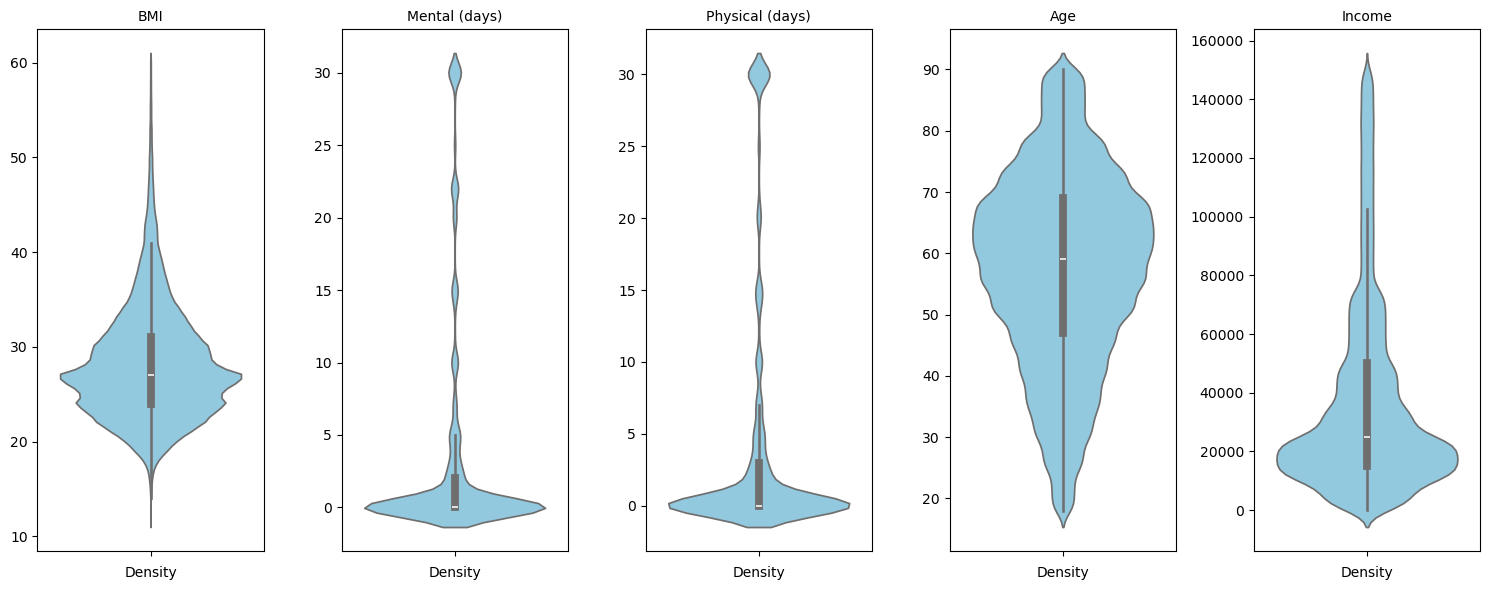


=== 分类特征分布（柱状图） ===
⚠️ 警告：以下分类列在 DataFrame 中不存在，将被跳过：['CholCheck', 'AnyHealthcare', 'NoDocbcCost']


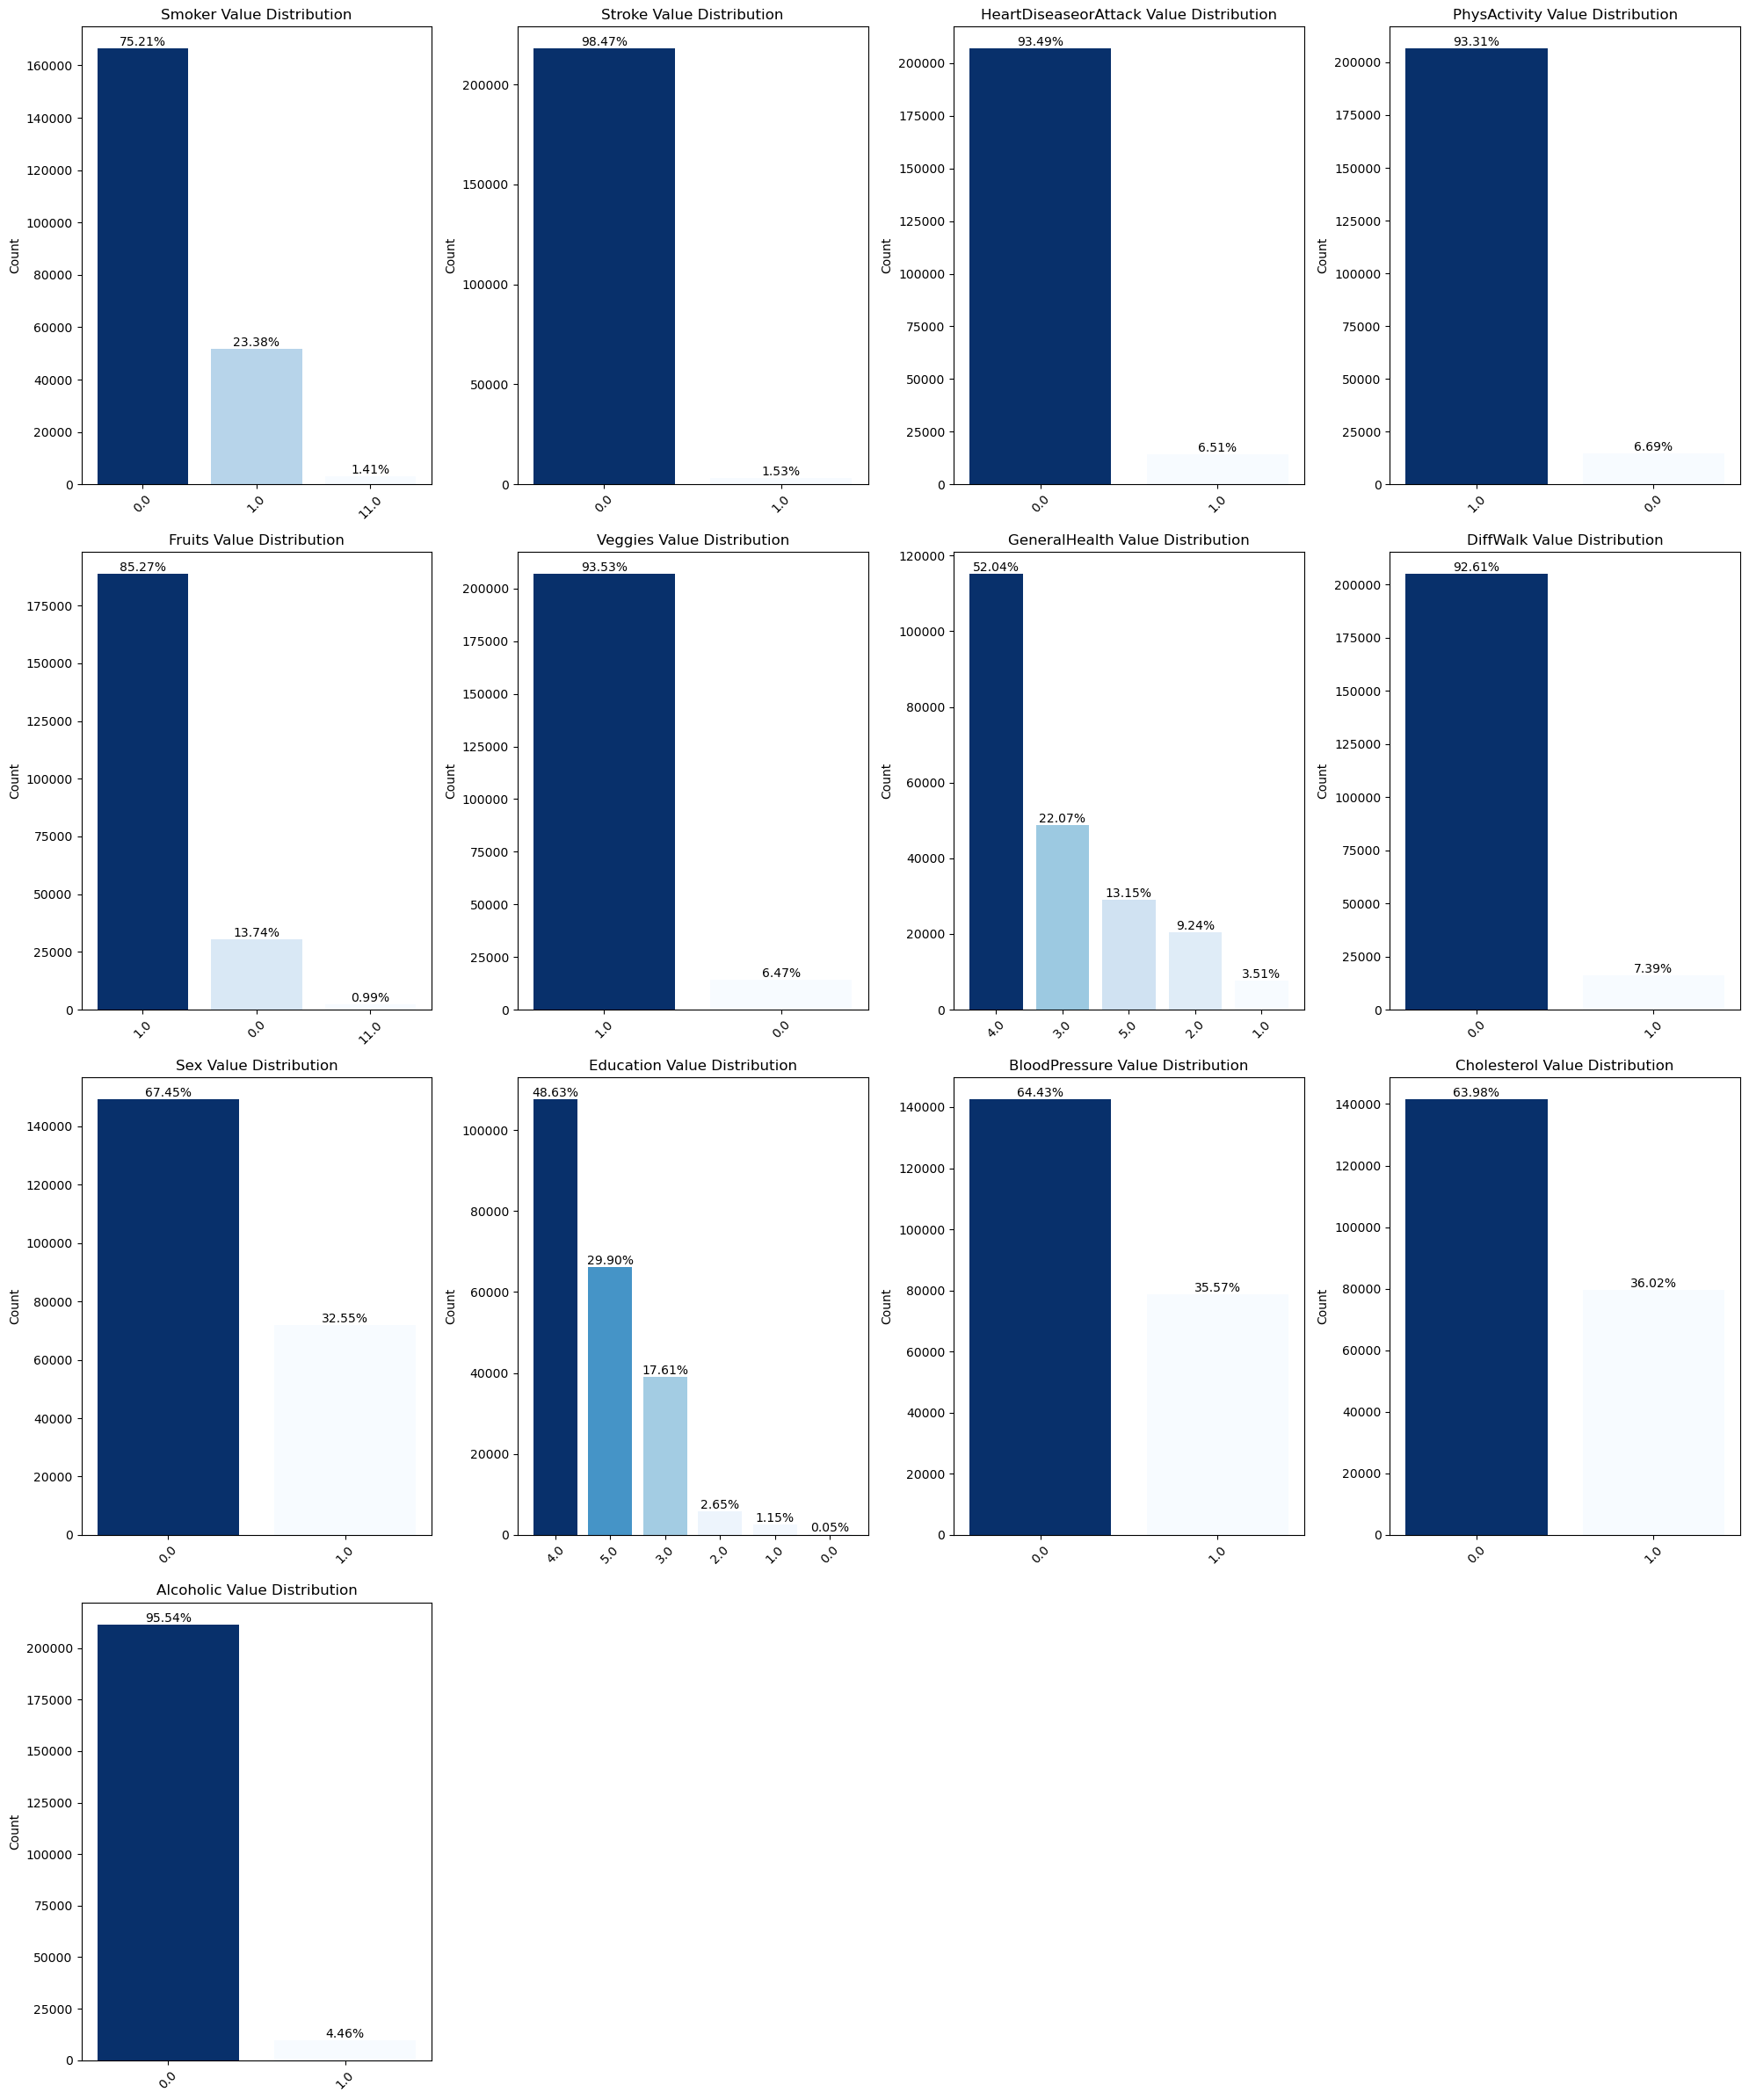

=== 缺失值信息（柱状图） ===


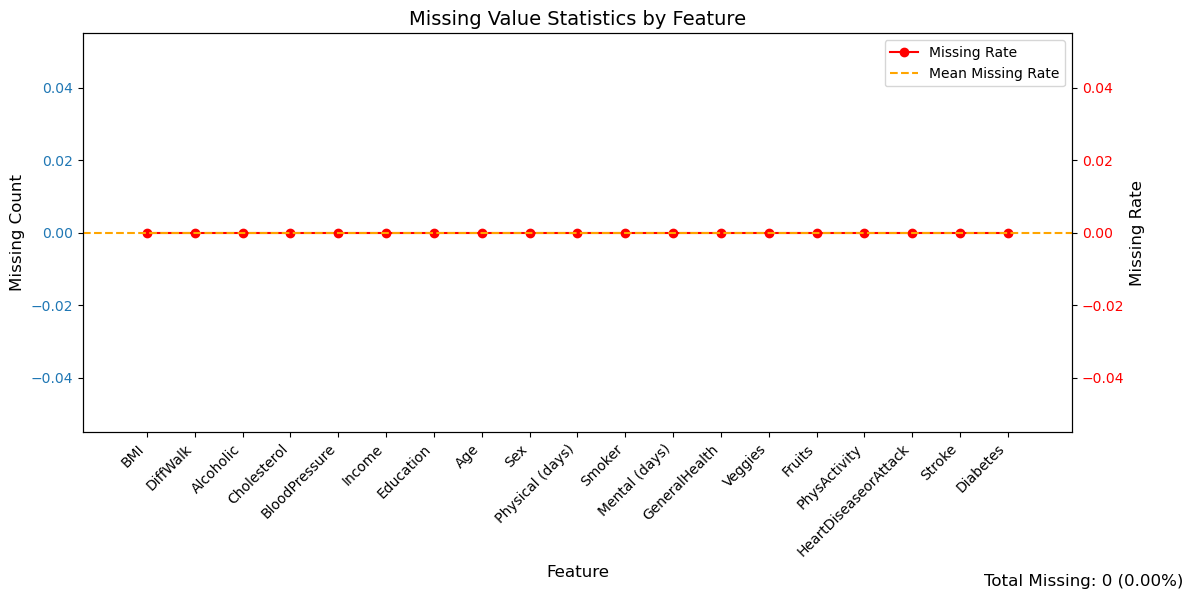

In [172]:
df,X,y = load_preprocess_plot('diabetes_diagnosis_complete.csv', numeric_features, categorical_features,do_plot=True)

#### 3.4.2 降维

数据维度与特征数量
- 数据集维度: **(221,372, 19)**  
- 特征数量适中（19 个特征），远低于样本数量 (n_features << n_samples)，无需强制降维。
- 特征冗余有限，主要集中在少数特征。  
- 多数特征信息独立，降维可能丢失有价值信息。

**综合判断**：
> 当前数据集不需要额外进行降维处理。  
> 建议在模型训练阶段直接使用原始或经过轻微编码/二元化的特征即可，同时监控 GeneralHealth 与 DiffWalk 的共线性情况。

# 四、探索性数据分析

=== 数据集基本信息 ===
维度: (221372, 19)
=== 连续特征分布（小提琴图） ===


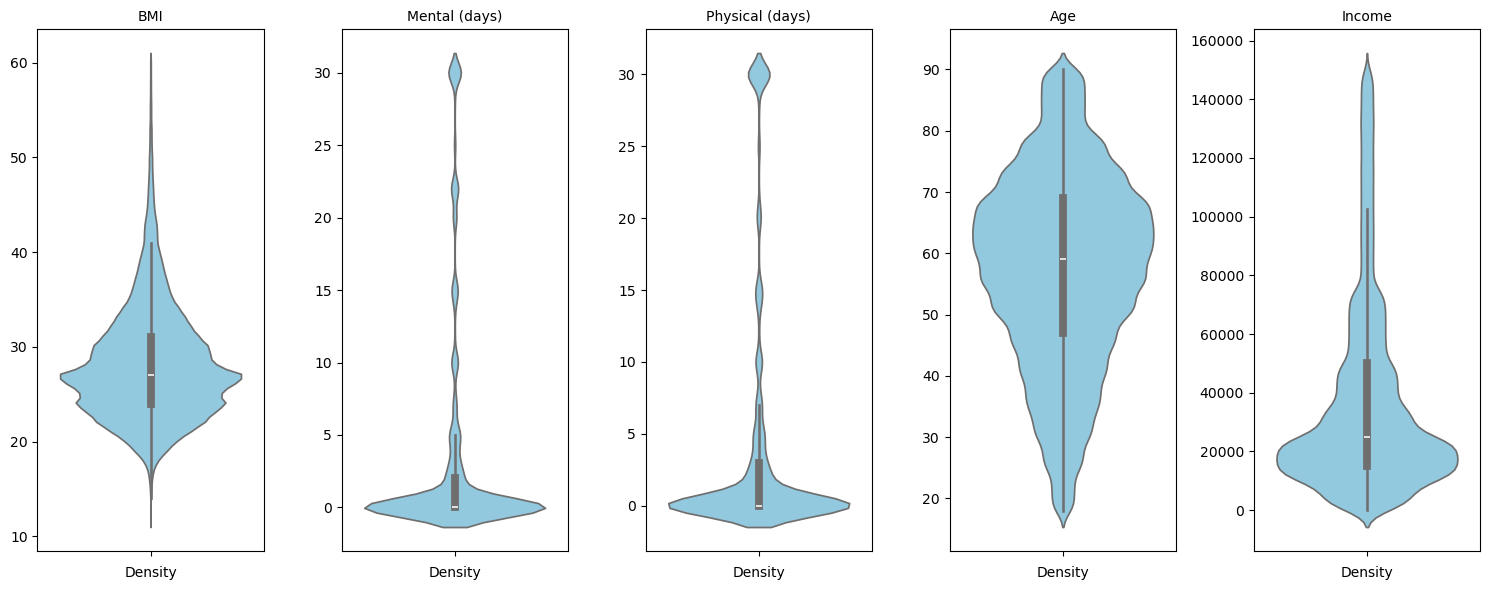


=== 分类特征分布（柱状图） ===
⚠️ 警告：以下分类列在 DataFrame 中不存在，将被跳过：['CholCheck', 'AnyHealthcare', 'NoDocbcCost']


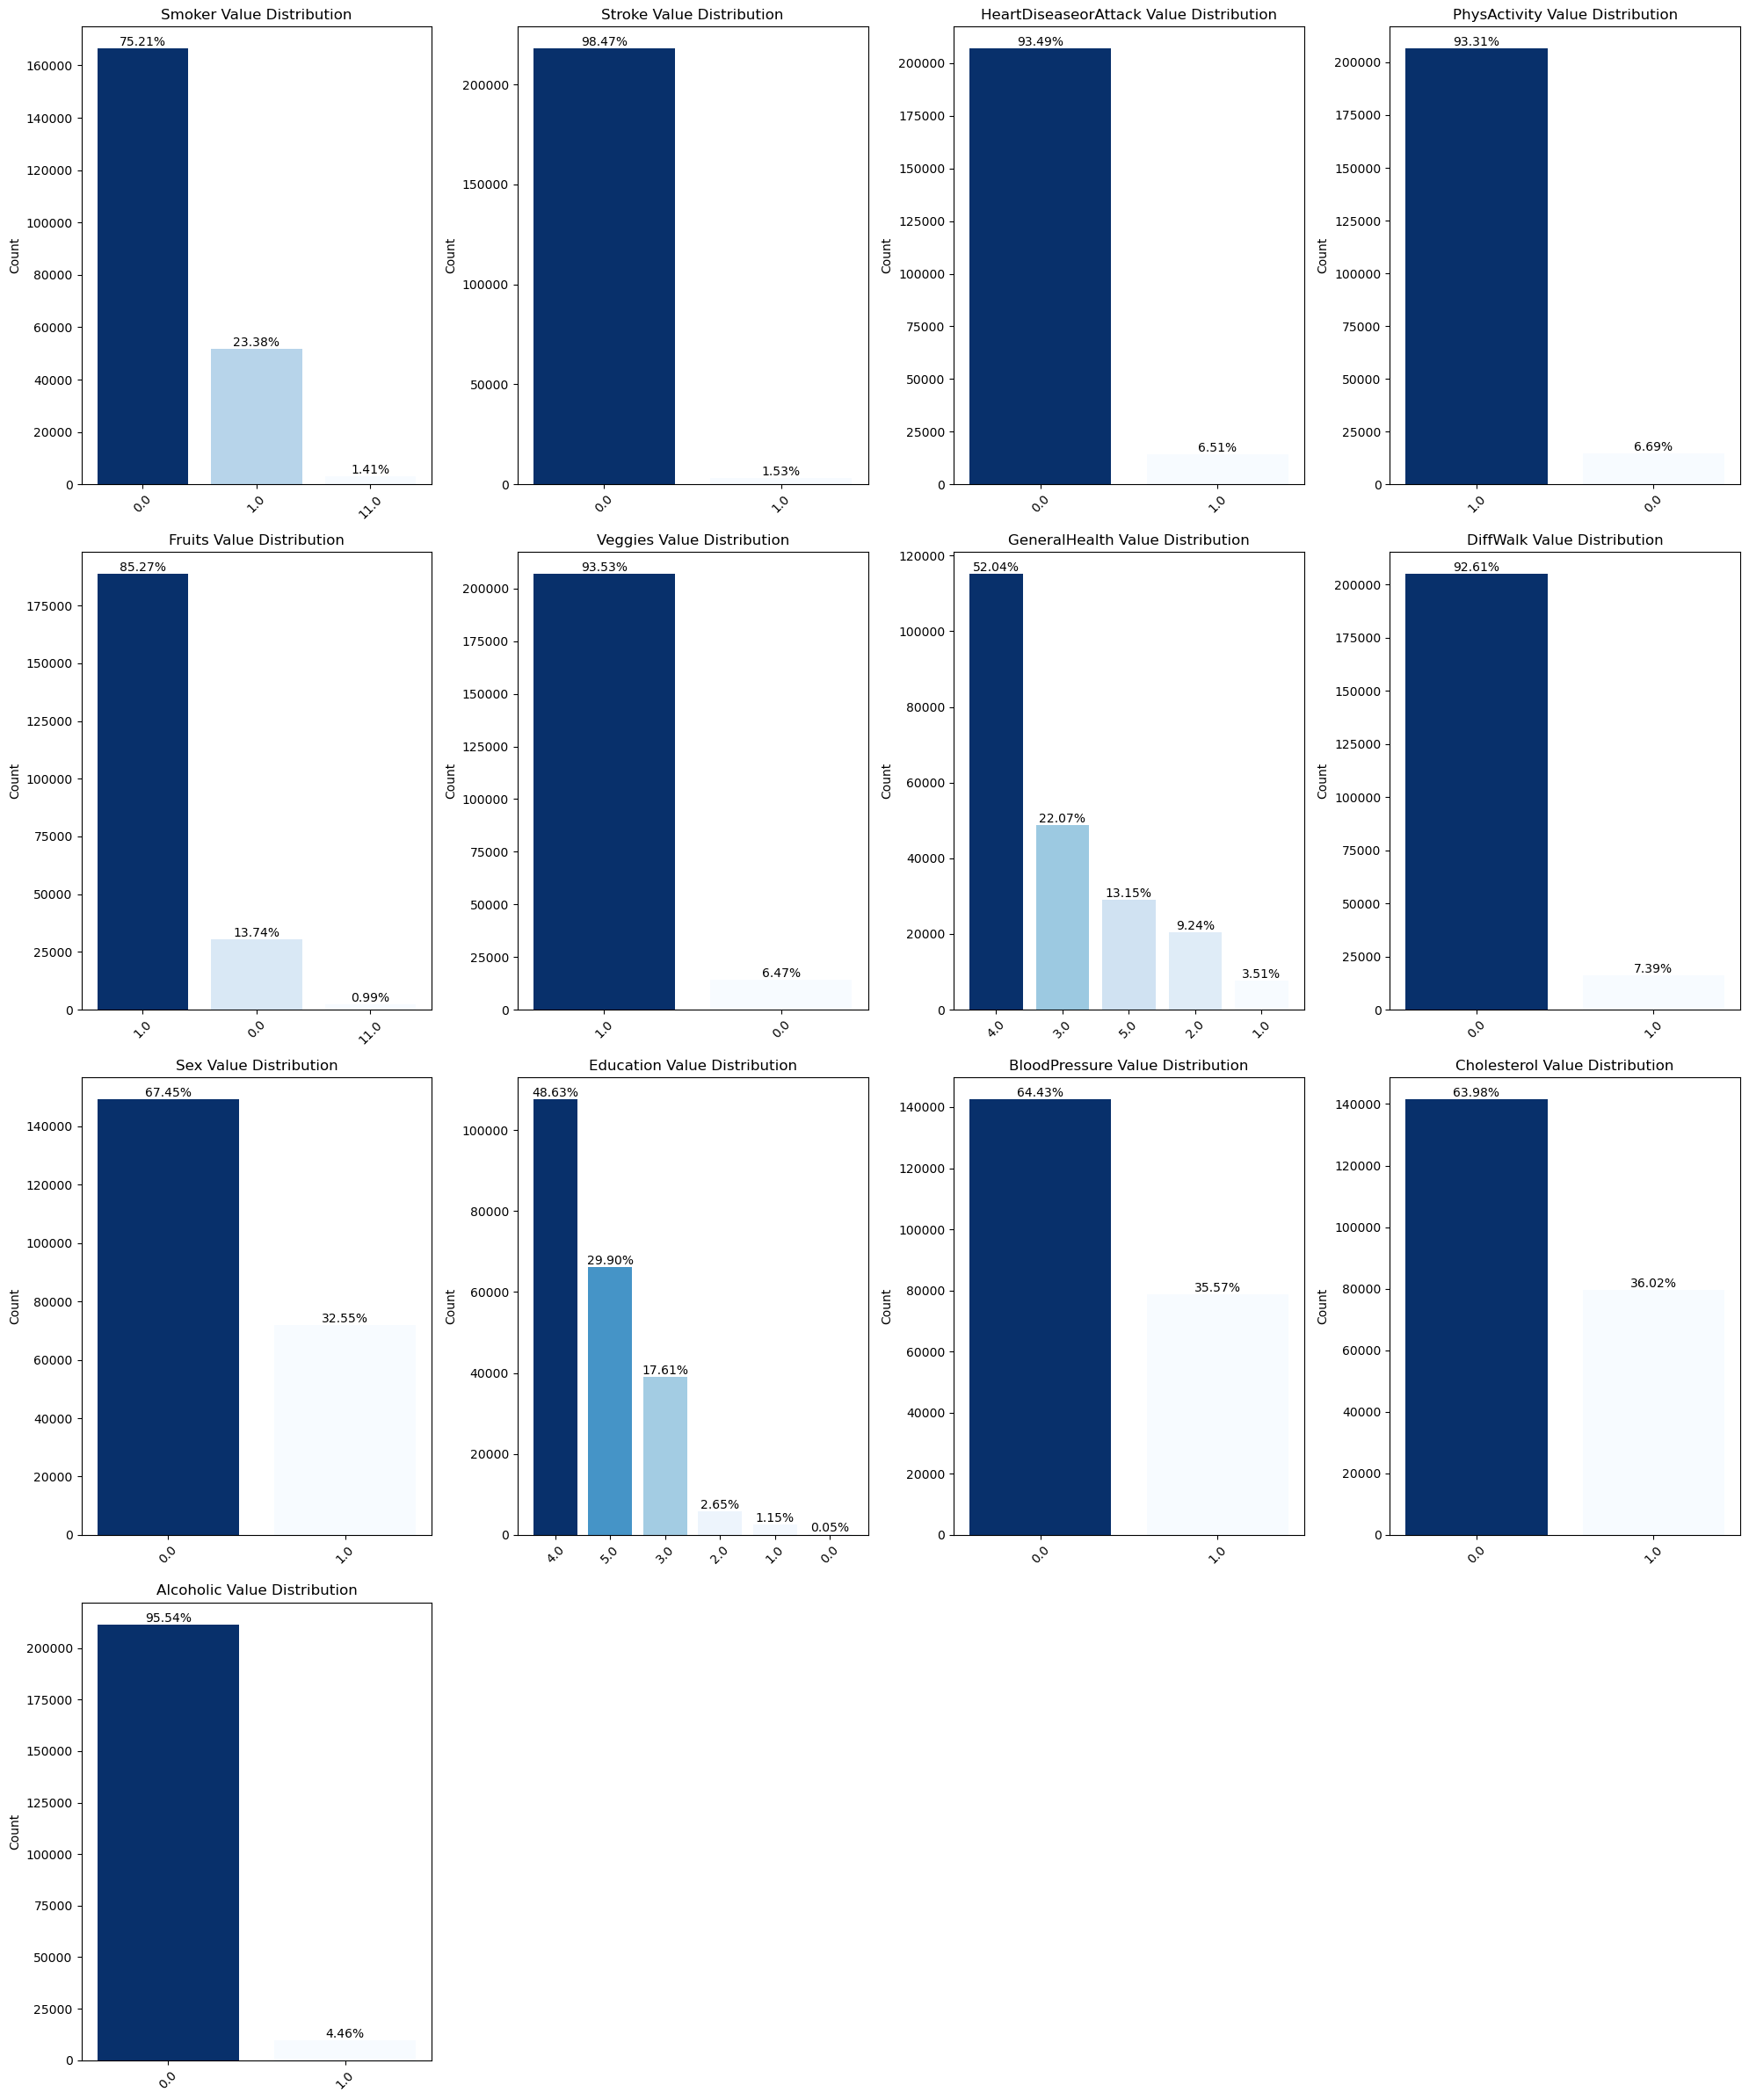

=== 缺失值信息（柱状图） ===


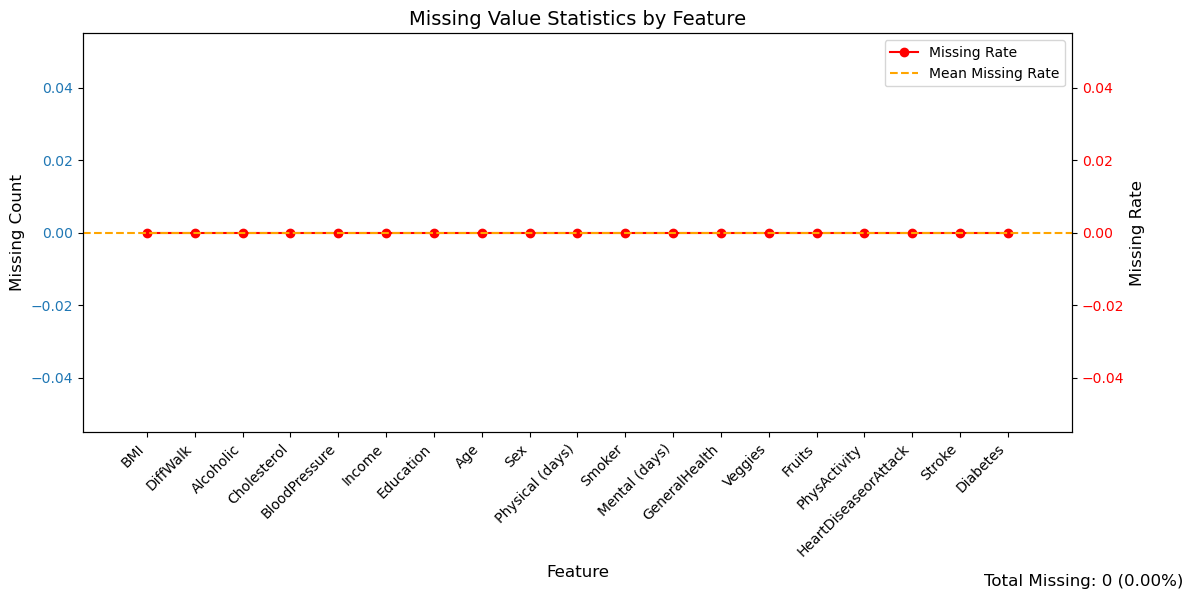

In [203]:
df, X, y = load_preprocess_plot('diabetes_diagnosis_complete.csv', numeric_features, categorical_features, do_plot=True)

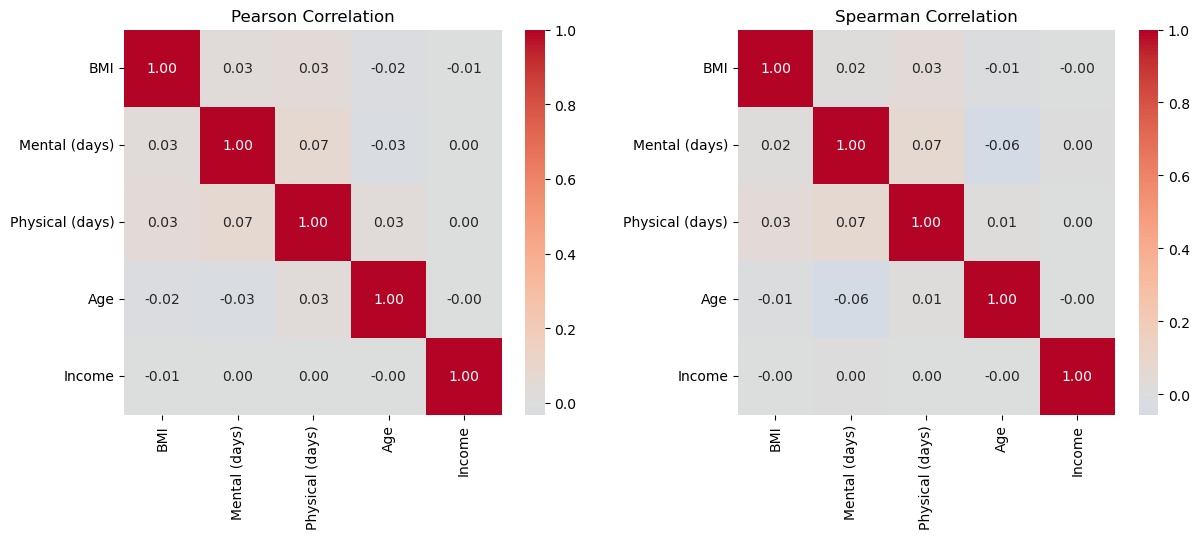

In [198]:
plot_numeric_correlations(df,numeric_features=numeric_features)

警告：以下特征在数据中不存在，将被忽略: ['CholCheck', 'AnyHealthcare', 'NoDocbcCost']


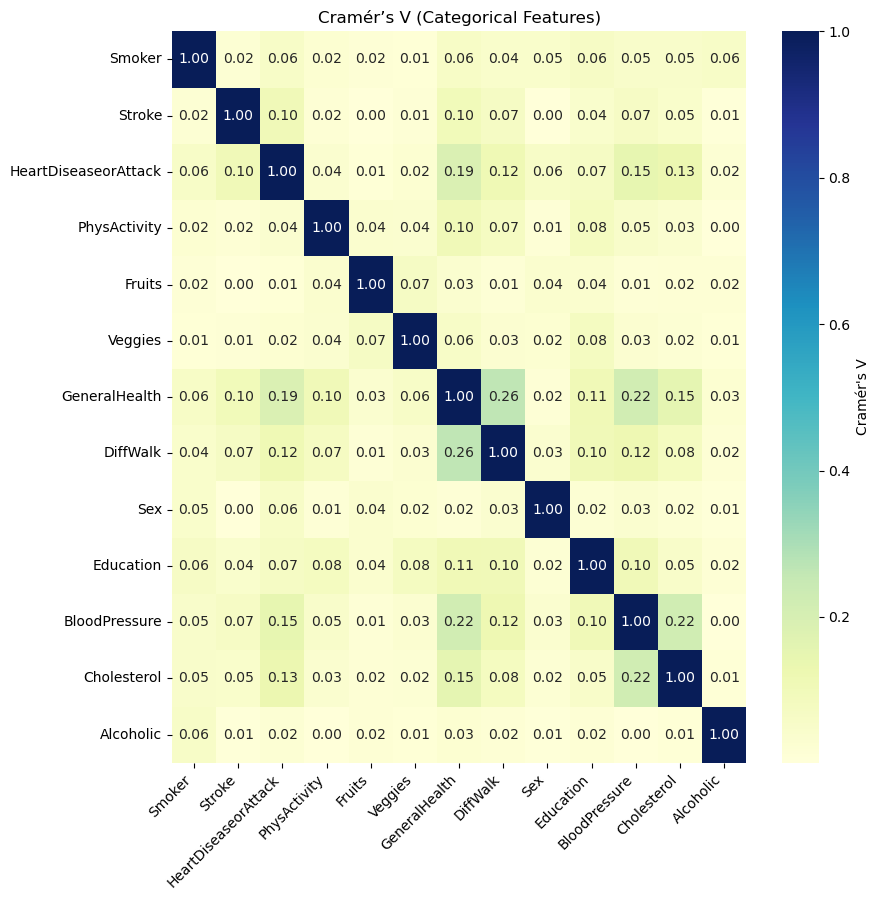

In [206]:
plot_cramers_v(df, categorical_features=categorical_features, per_feature_size=0.7)

In [213]:
def plot_scatter_matrix(df: pd.DataFrame, numeric_features: list, sample_size: int = 500):
    """
    绘制数值型特征的散点矩阵和对角线直方图。

    参数：
    ----
    df : pd.DataFrame
        输入的数据集
    numeric_features : list
        需要绘制散点矩阵的数值型特征列表
    sample_size : int, default=500
        为提高绘图效率，随机采样的数据行数上限

    返回：
    ----
    None，直接显示图形
    """
    sampled_X = df.sample(min(sample_size, len(df)), random_state=42).reset_index(drop=True)
    features = list(numeric_features)
    n = len(features)

    fig, axes = plt.subplots(n, n, figsize=(max(6, n*3), max(6, n*3)), squeeze=False)
    fig.suptitle("Scatter Matrix of Continuous Features", y=1.02)

    for i, yvar in enumerate(features):
        for j, xvar in enumerate(features):
            ax = axes[i, j]
            if i == j:
                sns.histplot(sampled_X[xvar].dropna(), bins='auto', edgecolor="black", ax=ax)
            else:
                sns.regplot(
                    data=sampled_X, x=xvar, y=yvar, ax=ax,
                    order=3,
                    line_kws={"lw": 2, "alpha": 0.8},
                    scatter_kws={"s": 8, "alpha": 0.4, "edgecolor": "k", "linewidths": 0.3}
                )

            if j > 0:
                ax.set_ylabel("")
            if i < n - 1:
                ax.set_xlabel("")

    plt.tight_layout()
    plt.show()

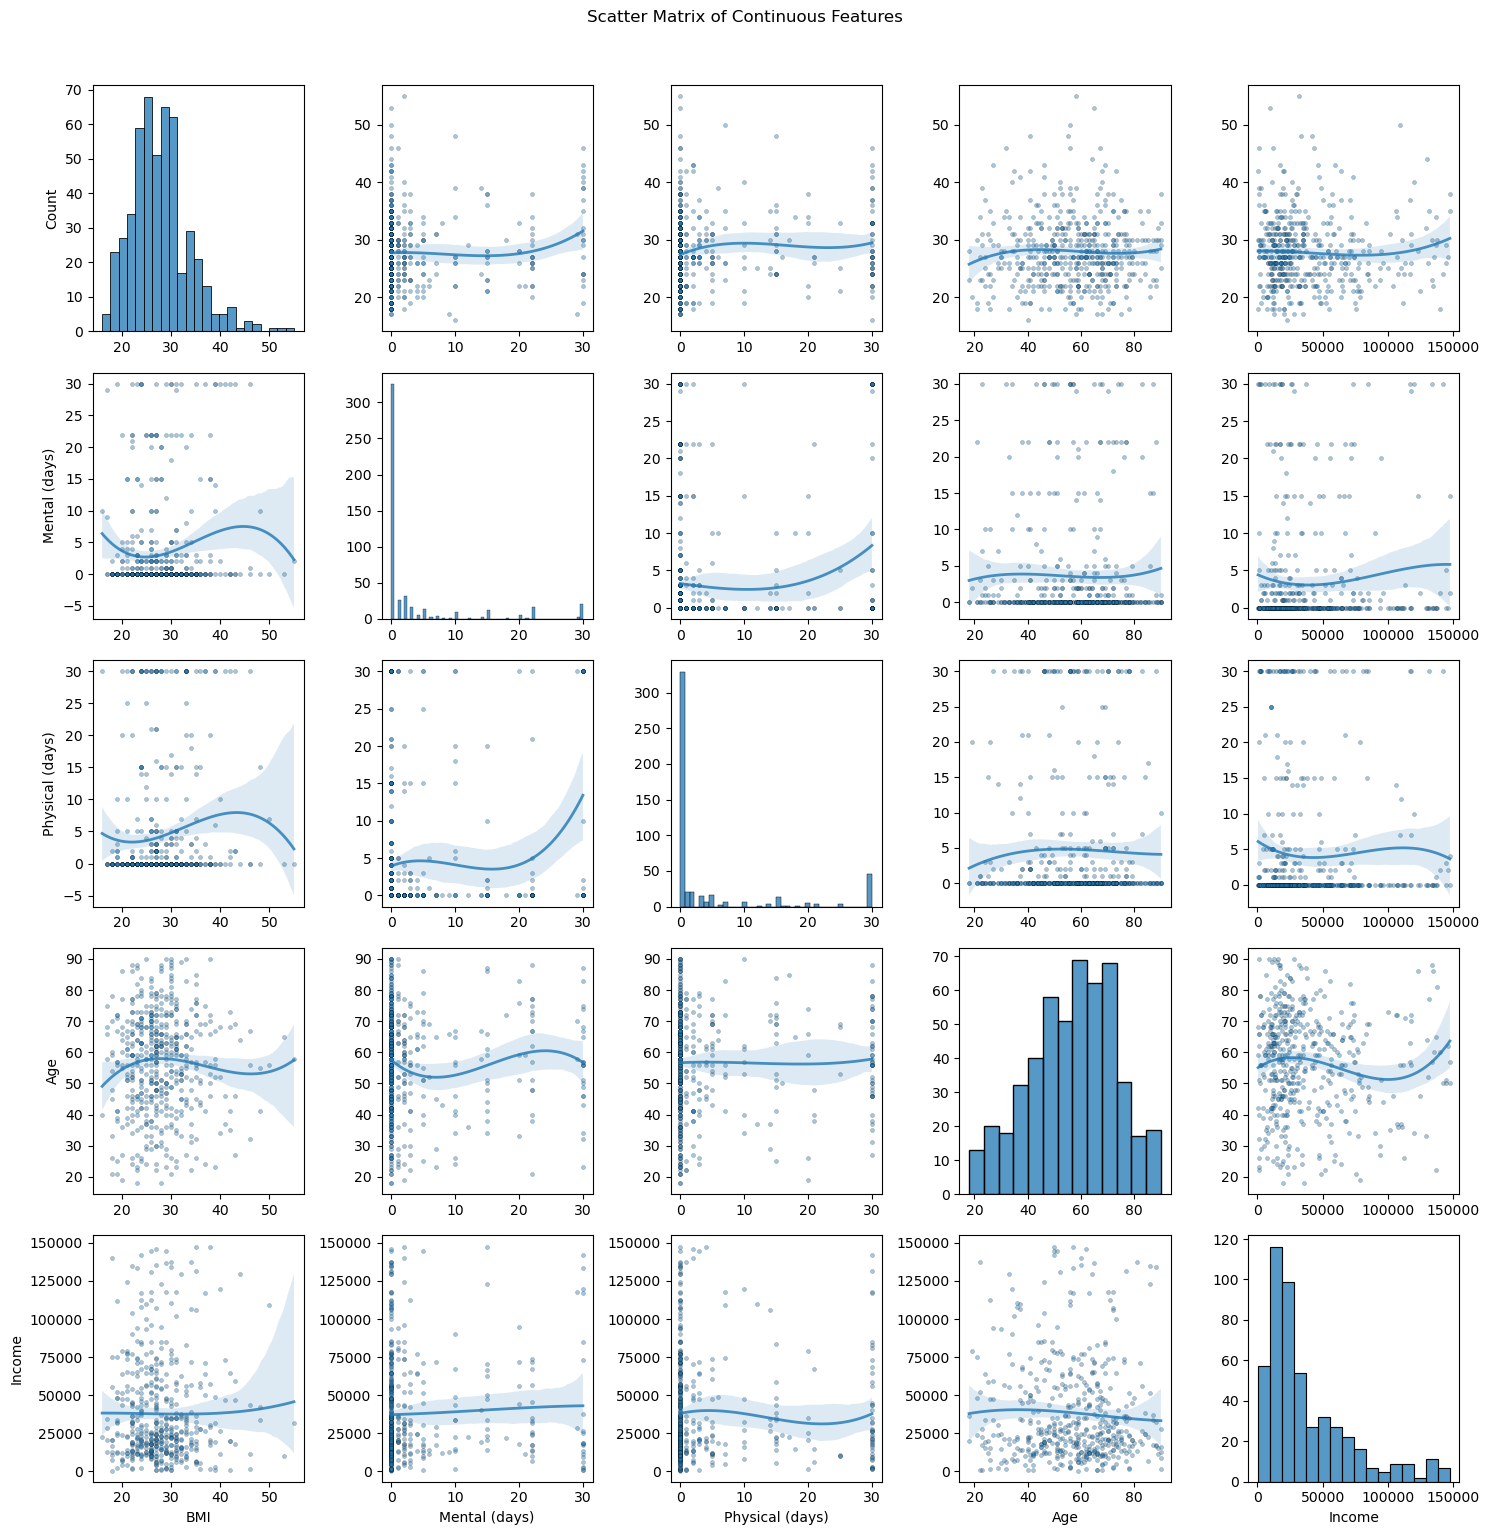

In [214]:
plot_scatter_matrix(df, numeric_features=numeric_features)